## Overview

This notebook is adapted for cosmological purposes from THIS ONE for compression of lossy data using neural networks and [TensorFlow Compression](https://github.com/tensorflow/compression).

Lossy compression involves making a trade-off between **rate**, the expected number of bits needed to encode a sample, and **distortion**, the expected error in the reconstruction of the sample.  Relevant papers [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704), [this paper](https://arxiv.org/abs/2007.03034) targeted at people familiar with classical data compression, or [this survey](https://arxiv.org/abs/2202.06533) targeted at a machine learning audience.


## Setup

Import library dependencies.

Install Tensorflow Compression via `pip` for Colab implementation as this needs to be installed for each runtime

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
#This is for TPUs
try:
    # This address identifies the TPU we'll use when configuring TensorFlow.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Please connect to a TPU runtime.")

Running on TPU  ['10.59.17.90:8470']


In [2]:
 %%bash
 # # Installs the latest version of TFC compatible with the installed TF version.
 read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
 pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"
 #pip install tensorflow-compression

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.5/262.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.23.0
    Uninstalling tensorflow-probability-0.23.0:
      Successfully uninstalled tensorflow-probability-0.23.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninsta

In [15]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds
import os

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

use_COLAB = 1 #1 is for on colab, and 2 is for on local machine but using colab

if use_COLAB >= 1:
  if use_COLAB == 2: # for running in VS CODE
      from colabcode import ColabCode
      ColabCode(port=10000)
  #mount drive
  from google.colab import drive
  drive.mount('/content/gdrive')

  WORK_AREA = '/content/gdrive/My Drive/weaklensing_ML/' #columbialensing/
  os.chdir(WORK_AREA)






2.15.0
Num GPUs Available:  1
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds
import re
import random
import numpy as np
import os
from astropy.io import fits

# Specify the directory containing the .tar files
directory_path = './columbialensing/'


# image_size
image_size = 1024
sub_image_size = 64 #needs to divide image into these units; must divide evenly image_size
                    #division is using that it is unlikely there are learnable correlations
                    #that allow one to compress the data on large scales in the images
                    #dividing images gives more samples to learn correlations



number_subimages_across =image_size//sub_image_size


number_image_files = 512
suffix = f"_{image_size}"
extract_tarfiles = False  #if I need to extract tarfiles

run_suffix = rf"im{image_size}"



def get_labels_for_file(dir_name):
    """
    Extracts labels from the tar file name.
    For the file "Om0.183_si0.958_256.tar", the labels will be [0.183, 0.958].

    Args:
    - tar_file_name (str): Name of the tar file.

    Returns:
    - list: List containing the two labels extracted from the filename.
    """
    # Split the filename on underscores
    parts = dir_name.split('_')

    # Extract the numeric values for 'Om' and 'si'
    om_label = float(parts[0][2:])
    si_label = float(parts[1][2:])

    return [om_label, si_label]

#now loop through all files in the
pattern = re.compile(rf"{suffix}$")
#all_directories = [f for f in os.listdir(directory_path) if pattern.search(f)]
all_directories = ["Om0.268_si0.801"] # "Om0.283_si0.805_256"
num_cosmologies = len(all_directories)


random.shuffle(all_directories) #this makes it so that there is no particular order for the directories
#print(all_directories)

#tensor of labels; there are two labels for each
numsubimages = number_subimages_across**2
number_images = number_image_files*numsubimages
#cosmology_labels = np.empty((len(all_directories), number_images, 2), dtype=np.float16)

print("num_cosmologies = ", num_cosmologies, numsubimages, number_subimages_across)

RMS =0 #first time set to zero
data_array = np.empty((num_cosmologies, number_images, sub_image_size, sub_image_size), dtype=np.float32)
print("created array")
for idy, dir_name in enumerate(all_directories):
    print(idy)
    #if idy%10 ==0:
    print("reading in", dir_name)
    dir_path = os.path.join(directory_path, dir_name)

    all_files = os.listdir(dir_path)
    fits_files = [f for f in all_files if f.endswith('.fits')]



    for idx, file in enumerate(fits_files):
        with fits.open(os.path.join(dir_path, file)) as hdul:

            original_data = hdul[0].data #take log of data

            if RMS == 0: #get RMS to divide by for first file to normalize everything
                RMS = np.sqrt(np.var(hdul[0].data))
                print(f"RMS={RMS}")

            ##get rid of NANs, which affects a few files
            #if np.isnan(original_data).any():
            #    continue
            #I've cleaned this out already
            for i in range(number_subimages_across):
                for j in range(number_subimages_across):
                    data_array[idy][numsubimages*idx+ number_subimages_across*i+j] = original_data[sub_image_size*i:sub_image_size*(i+1),\
                                                                  sub_image_size*j:sub_image_size*(j+1)]/RMS
    #since all fits files in one directory have the same label
    #cosmology = get_labels_for_file(dir_name)
    #cosmology_labels[idy] = np.array([cosmology for i in range(number_fits_files)])


    print("done with reading in")
    #flatten data_array[idy][numsubimages*idx+ number_subimages_across*i+j]
WL_tensor = tf.convert_to_tensor(data_array)

WL_tensor = tf.reshape(WL_tensor, (-1, WL_tensor.shape[2], WL_tensor.shape[3]));

WL_tensor = WL_tensor[..., np.newaxis]  # Add channel dimension

num_cosmologies =  1 256 16
created array
0
reading in Om0.268_si0.801
RMS=0.016497720032930374
done with reading in


## Define the trainer model.

Because the model resembles an autoencoder, and we need to perform a different set of functions during training and inference, the setup is a little different from, say, a classifier.

The training model consists of three parts:
- the **analysis** (or encoder) transform, converting from the image into a latent space,
- the **synthesis** (or decoder) transform, converting from the latent space back into image space, and
- a **prior** and entropy model, modeling the marginal probabilities of the latents.

First, define the transforms:

In [17]:
def make_analysis_transform(latent_dims, stride=2, activation="leaky_relu", channels=48, kernel_size=5):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          channels//2, kernel_size, use_bias=True, strides=stride, padding="same",
          activation=activation, name="conv_1"),
      tf.keras.layers.Conv2D(
          channels, kernel_size, use_bias=True, strides=stride, padding="same",
          activation=activation, name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          latent_dims*2, use_bias=True, activation=activation, name="fc_1"),  #this was set at 500 when I had good results for latent_dims=1000, so make sure this is okay
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")



In [18]:
def make_synthesis_transform(latent_dims, stride=2, activation="leaky_relu", channels=48, kernel_size=5):
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          latent_dims*2, use_bias=True, activation="leaky_relu", name="fc_1"), #this was set at 500 when I had good results for latent_dims=1000, so make sure this is okay
      tf.keras.layers.Dense(
          (sub_image_size//4)**2*channels, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((sub_image_size//4, sub_image_size//4, channels)),
      tf.keras.layers.Conv2DTranspose(
          channels//2, kernel_size, use_bias=True, strides=stride, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          1, kernel_size, use_bias=True, strides=stride, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")


The trainer holds an instance of both transforms, as well as the parameters of the prior.

Its `call` method is set up to compute:
- **rate**, an estimate of the number of bits needed to represent the batch of digits, and
- **distortion**, the mean absolute difference between the pixels of the original digits and their reconstructions.


In [19]:
class CosmologyCompressionTrainer(tf.keras.Model):
    """Model that trains a compressor/decompressor for cosmology."""

    def __init__(self, latent_dims):
      super().__init__()
      self.analysis_transform = make_analysis_transform(latent_dims)
      self.synthesis_transform = make_synthesis_transform(latent_dims)
      self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

    @property
    def prior(self):
      return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

    def call(self, x, training):
      """Computes rate and distortion losses."""
      # Ensure inputs are floats in the range (0, 1).
      #x = WL_tensor #tf.cast(x, self.compute_dtype) / 255.
      x = tf.reshape(x, (-1, sub_image_size, sub_image_size, 1))

      # Compute latent space representation y, perturb it and model its entropy,
      # then compute the reconstructed pixel-level representation x_hat.
      y = self.analysis_transform(x)
      entropy_model = tfc.ContinuousBatchedEntropyModel(
          self.prior, coding_rank=1, compression=False)
      y_tilde, rate = entropy_model(y, training=training)
      x_tilde = self.synthesis_transform(y_tilde)

      # Average number of bits per pixel digit.
      rate = tf.reduce_mean(rate)

      # Mean absolute difference across pixels.
      distortion = tf.reduce_mean(abs(x - x_tilde))

      return dict(rate=rate, distortion=distortion)



### Compute rate and distortion.

Let's walk through this step by step, using one image from the training set. Load the MNIST dataset for training and validation:

In [20]:
split_ratio = 0.8

total_size = len(WL_tensor)
train_size = int(split_ratio * total_size)
dataset = tf.data.Dataset.from_tensor_slices(WL_tensor)

training_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

print(total_size)

#training_dataset, validation_dataset = tfds.load(
#    "mnist",
#    split=["train", "test"],
#    shuffle_files=True,
#    as_supervised=True,
#    with_info=False,
#)


#


131072


And extract one image $x$:

tf.Tensor(
[[-0.50377345 -0.34110388 -0.3827849  ...  0.5156797   0.7483589
   1.34461   ]
 [-0.52471113 -0.33768407 -0.40279126 ...  1.040492    1.5758135
   2.108855  ]
 [-0.6927992  -0.48732606 -0.54809433 ...  2.2895446   3.2455938
   3.659007  ]
 ...
 [-1.578237   -1.3434688  -1.3630779  ... -0.9081721  -1.0003366
  -1.0092155 ]
 [-1.5966034  -1.3758609  -1.4271088  ... -0.82323205 -0.8227951
  -0.91727024]
 [-1.6001022  -1.3529824  -1.427125   ... -0.6925693  -0.77019495
  -0.88108957]], shape=(64, 64), dtype=float32)
Data type: <dtype: 'float32'>
Shape: (64, 64, 1)


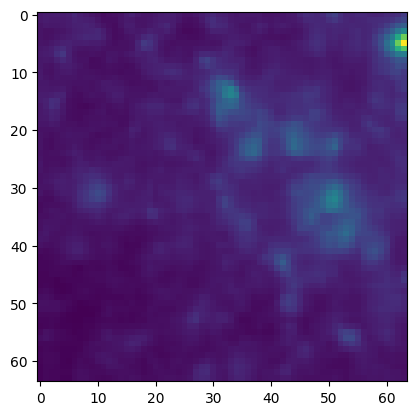

In [21]:

(x), =validation_dataset.take(1)
#for x in validation_dataset.take(4):
print(tf.squeeze(x))


plt.imshow(tf.squeeze(x))
print(f"Data type: {x.dtype}")
print(f"Shape: {x.shape}")


To get the latent representation $y$, we need to cast it to `float32`, add a batch dimension, and pass it through the analysis transform.

In [22]:
output_dim = 1000

#x = tf.cast(x, tf.float32) / 255.
x = tf.reshape(x, (-1, sub_image_size, sub_image_size, 1))
y = make_analysis_transform(output_dim)(x)

print("y:", y)


y: tf.Tensor(
[[ 2.67361403e-02  1.38256371e-01 -5.60557246e-02  6.25695661e-02
   1.89439934e-02 -1.71782464e-01 -3.22918296e-02  8.41657817e-02
   8.47395808e-02 -1.77478716e-02  4.12774347e-02  1.07908383e-01
  -1.61061242e-01  1.37589723e-02 -1.63904697e-01  2.37155169e-01
  -4.40782309e-03  1.95254356e-01  5.58050461e-02  3.95260826e-02
   4.39713299e-02  1.15347348e-01 -3.54618952e-02 -6.78572655e-02
   3.31395477e-01  8.36649388e-02  6.79847449e-02  3.84602174e-02
  -3.37006003e-02  1.38742253e-02  1.18354104e-01  7.06087798e-02
  -1.02319844e-01 -1.56006783e-01  5.58660515e-02  1.53314680e-01
   7.75077045e-02 -9.67362970e-02  6.95816576e-02 -8.53828341e-03
   7.01126605e-02 -5.23020700e-03  5.71721792e-03  1.09219879e-01
  -6.13495484e-02 -2.81894375e-02 -1.67225555e-01  1.21844113e-01
  -1.24598429e-01  1.41030401e-02 -1.54288441e-01  1.53182209e-01
   6.51731119e-02 -1.76868081e-01 -5.06623946e-02 -1.09883755e-01
   1.07496552e-01 -2.96660848e-02  1.58462331e-01  1.86568230e

The latents will be quantized at test time. To model this in a differentiable way during training, we add uniform noise in the interval $(-.5, .5)$ and call the result $\tilde y$. This is the same terminology as used in the paper [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704).

The "prior" is a probability density that we train to model the marginal distribution of the noisy latents. For example, it could be a set of independent [logistic distributions](https://en.wikipedia.org/wiki/Logistic_distribution) with different scales for each latent dimension. `tfc.NoisyLogistic` accounts for the fact that the latents have additive noise. As the scale approaches zero, a logistic distribution approaches a dirac delta (spike), but the added noise causes the "noisy" distribution to approach the uniform distribution instead.

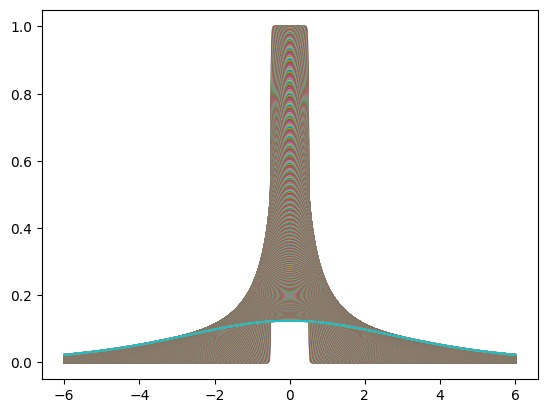

In [23]:
prior = tfc.NoisyLogistic(loc=0., scale=tf.linspace(.01, 2., output_dim))
#prior = tfc.NoisyLogistic(loc=0., scale=tf.linspace(.001, .1, output_dim))

_ = tf.linspace(-6., 6., 501)[:, None]
plt.plot(_, prior.prob(_));


During training, `tfc.ContinuousBatchedEntropyModel` adds uniform noise, and uses the noise and the prior to compute a (differentiable) upper bound on the rate (the average number of bits necessary to encode the latent representation). That bound can be minimized as a loss.

In [24]:
entropy_model = tfc.ContinuousBatchedEntropyModel(
    prior, coding_rank=1, compression=False)
y_tilde, rate = entropy_model(y, training=True)

print("rate:", rate)
#print("y_tilde:", y_tilde)


rate: tf.Tensor([1894.1917], shape=(1,), dtype=float32)


Lastly, the noisy latents are passed back through the synthesis transform to produce an image reconstruction $\tilde x$. Distortion is the error between original image and reconstruction. Obviously, with the transforms untrained, the reconstruction is not very useful.

(1, 64, 64, 1) (1, 64, 64, 1) <dtype: 'float32'> <dtype: 'float32'>
distortion: tf.Tensor(0.8618526, shape=(), dtype=float32)
distortion: tf.Tensor(0.8616541, shape=(), dtype=float32)
Data type: <dtype: 'float32'>
Shape: (64, 64, 1)


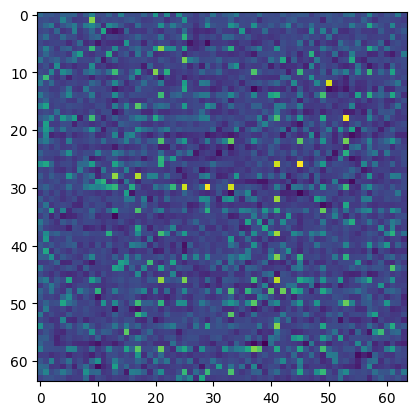

In [25]:
x_tilde = make_synthesis_transform(output_dim)(y_tilde)

#print(make_synthesis_transform(output_dim)(y))

print(np.shape(x_tilde), np.shape(x), x_tilde.dtype, x.dtype)
# Mean absolute difference across pixels.
distortion = tf.reduce_mean(abs(x - x_tilde))
print("distortion:", distortion)

print("distortion:",tf.reduce_mean(abs(make_synthesis_transform(output_dim)(y)*0 - x)))

x_tilde = x_tilde[0] #, tf.uint8)
plt.imshow(tf.squeeze(x_tilde))
print(f"Data type: {x_tilde.dtype}")
print(f"Shape: {x_tilde.shape}")


For every batch of digits, calling the `MNISTCompressionTrainer` produces the rate and distortion as an average over that batch:


In [26]:
(example_batch), = validation_dataset.batch(32).take(1)
trainer = CosmologyCompressionTrainer(output_dim)
example_output = trainer(example_batch)

print("rate: ", example_output["rate"])
print("distortion: ", example_output["distortion"])


rate:  tf.Tensor(2029.8718, shape=(), dtype=float32)
distortion:  tf.Tensor(0.76156104, shape=(), dtype=float32)


In the next section, we set up the model to do gradient descent on these two losses.

## Train the model.

We compile the trainer in a way that it optimizes the rate–distortion Lagrangian, that is, a sum of rate and distortion, where one of the terms is weighted by Lagrange parameter $\lambda$.

This loss function affects the different parts of the model differently:
- The analysis transform is trained to produce a latent representation that achieves the desired trade-off between rate and distortion.
- The synthesis transform is trained to minimize distortion, given the latent representation.
- The parameters of the prior are trained to minimize the rate given the latent representation. This is identical to fitting the prior to the marginal distribution of latents in a maximum likelihood sense.

In [27]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_compression_trainer(lmbda, latent_dims=output_dim):
  trainer = CosmologyCompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer


Next, train the model. The human annotations are not necessary here, since we just want to compress the images, so we drop them using a `map` and instead add "dummy" targets for rate and distortion.

In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

class LearningRateLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()  # In case it's a tensor, convert it to a numpy array
        print(f"Epoch {epoch+1}: Learning Rate is {lr}")


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=0.00001)
callbacks = [reduce_lr, LearningRateLogger()]

def add_rd_targets(image):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)




def train_model(batch_size):

  trainer.fit(
      training_dataset.map(add_rd_targets).batch(batch_size).prefetch(tf.data.AUTOTUNE),
      epochs=20,
      validation_data=validation_dataset.map(add_rd_targets).batch(batch_size).cache(),
      validation_freq=1, shuffle=True,
      verbose=1,
      callbacks=callbacks
  )
  return trainer

def reset_learning_rate(new_lr, trainer):
    if hasattr(trainer.optimizer.learning_rate, 'assign'):
        # For optimizers with dynamic learning rate (like schedules)
        trainer.optimizer.learning_rate.assign(new_lr)
    else:
        # For static learning rates
        trainer.optimizer.learning_rate = new_lr



#lmbda=20000
lmbda=1000000 # a million is motivated by desire for 1% accuracy which I expect will need at least 10^4 bits for our 64^2 images (a couple per pixel)
untrained = True  #flag when running for first time
reset_learning = True
if untrained: #if I haven't compiled the model
  trainer = make_compression_trainer(lmbda, output_dim)
  untrained = False

if reset_learning:
  reset_learning_rate(1e-3, trainer)
  reset_learning = False


batch_size = 2048
trainer = train_model(batch_size)


Epoch 1: Learning Rate is 0.0010000000474974513
Epoch 1/20


TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__train_function() missing 1 required positional argument: 'steps_per_execution'


For record, I've acheved a loss of 13% for about 4200 bits total, but this was with werid choices for layers (I had a bottleneck layer with 500 neurons).  I think now something isn't working so well and loss is increasing.

## Compress images.

For compression and decompression at test time, we split the trained model in two parts:

- The encoder side consists of the analysis transform and the entropy model.
- The decoder side consists of the synthesis transform and the same entropy model.

At test time, the latents will not have additive noise, but they will be quantized and then losslessly compressed, so we give them new names. We call them and the image reconstruction $\hat x$ and $\hat y$, respectively (following [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704)).

In [ ]:
class Compressor(tf.keras.Model):
  """Compresses MNIST images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype)  #/ 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits


In [ ]:
class Decompressor(tf.keras.Model):
  """Decompresses MNIST images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return x_hat #tf.saturate_cast(tf.round(x_hat), tf.uint8)


When instantiated with `compression=True`, the entropy model converts the learned prior into tables for a range coding algorithm. When calling `compress()`, this algorithm is invoked to convert the latent space vector into bit sequences. The length of each binary string approximates the information content of the latent (the negative log likelihood of the latent under the prior).

The entropy model for compression and decompression must be the same instance, because the range coding tables need to be exactly identical on both sides. Otherwise, decoding errors can occur.

In [ ]:
def make_cosmology_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = Compressor(trainer.analysis_transform, entropy_model)
  decompressor = Decompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_cosmology_codec(trainer)


Grab 16 images from the validation dataset. You can select a different subset by changing the argument to `skip`.

Data type: <dtype: 'float32'>
Shape: (16, 64, 64, 1)


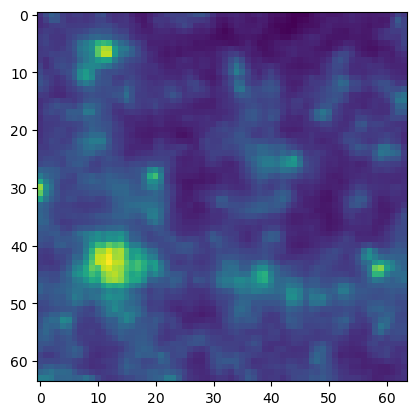

In [ ]:
(originals), = validation_dataset.batch(16).skip(3).take(1)

plt.imshow(tf.squeeze(originals[0]))
print(f"Data type: {originals.dtype}")
print(f"Shape: {originals.shape}")


Compress them to strings, and keep track of each of their information content in bits.

In [ ]:
strings, entropies = compressor(originals)

print(f"String representation of first file in hexadecimal: 0x{strings[6].numpy().hex()}, {strings[3].numpy().hex()}")
print(len(strings[10].numpy().hex()))
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")


String representation of first file in hexadecimal: 0xfb9e8ee94e3c52d517755fb6e1a9fb1a0f6c6ca76f4e8cfce9235b4d3dc46331931a2cb847928e5865da69e51983e6b09bd636df764cc7052bb4f5028b34f59a6958843af9c8c9e7c2422f01e1b46e9c545c35f7057943ceb4483e3b5af216f1c1dae4bb0cba1dee20d78443c0468a95ed537e7dc377ad11da82484cdc651b4adf5a32602f8f90e08042fa105c86d95d835316dca93a1f092f6302b27825eac035ddff012f4f1dc86eba0ccce66abca491083ae9829cdeec40bf294c6657ed59c84bc9cbc2a93cdf046263e23cecab87b7e19765a9718b348e14013707501c3ac4a30a95630aa784c39fb543a58e4e07d9b0fca62c08fd90a614fdb9a4e92683e8b270298824c4e38b003a63016a8beb6a46d06e65aa5006c3490f6169caeab19c2e19dcbf041d5f064d8b356f2541faf9204fdbf316065274e23df4ff0c972b233ba9d054c956977d5c9b96dde8447ff658def65ba1025a4b0861e2d508c62d5b02666c8cc5ba4d318c932741c5a7e42771ca4c003e78039c63b6110f1b0993f4c217b7b4a3fc614185d2ede214ecf97f4e9dfab67c333e5996b7c0953eea84c18581f6d99d9678f9d898534d7cfe3847d969a62362bb41ca425fa69dec087a16124ad91f475dfb160cbee3bee8e95a4739e947e98508e2ec

Decompress the images back from the strings.

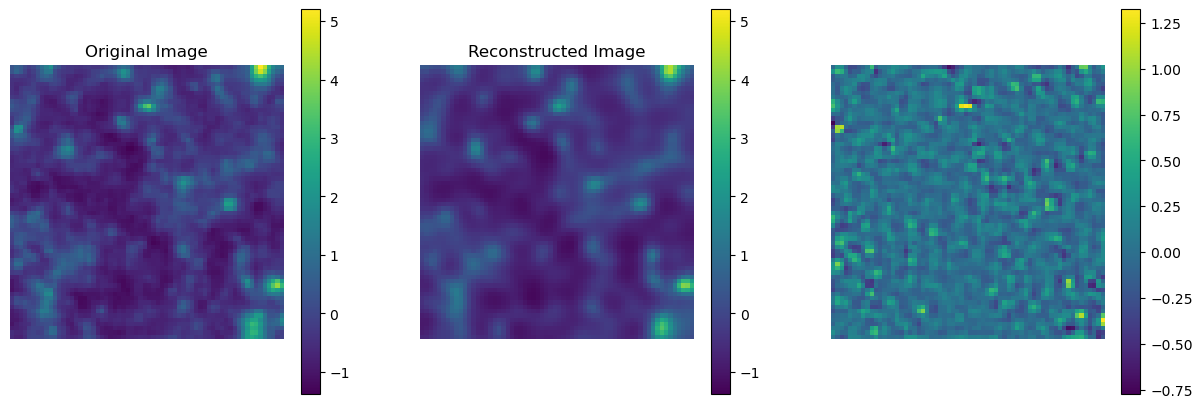

In [ ]:
num_image = 10
reconstructions = decompressor(strings)

# Assuming originals and reconstructions are your datasets
original_image = tf.squeeze(originals[num_image])
reconstructed_image = tf.squeeze(reconstructions[num_image])

# Determine the min and max values across both images for consistent scaling
vmin = min(original_image.numpy().min(), reconstructed_image.numpy().min())
vmax = max(original_image.numpy().max(), reconstructed_image.numpy().max())


# Set up a figure with two subplots
plt.figure(figsize=(15, 5))  # You can adjust the figure size as needed

# Display the original image
plt.subplot(1, 3, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(original_image, vmin=vmin, vmax=vmax)
plt.title('Original Image')
plt.axis('off')  # Turn off axis numbers and labels
plt.colorbar()

# Display the reconstructed image
plt.subplot(1, 3, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(reconstructed_image, vmin=vmin, vmax=vmax)
plt.title('Reconstructed Image')
plt.axis('off')  # Turn off axis numbers and labels
plt.colorbar()


# Determine the scale for the difference image
difference_image = original_image - reconstructed_image
diff_vmin = difference_image.numpy().min()
diff_vmax = difference_image.numpy().max()
plt.subplot(1, 3, 3)
image_display= plt.imshow(difference_image, vmin=diff_vmin, vmax=diff_vmax)
plt.axis('off')  # Turn off axis numbers and labels
plt.colorbar()


plt.show()


calculate power spectrum of images

46 [[0.         1.         2.         ... 3.         2.         1.        ]
 [1.         1.41421356 2.23606798 ... 3.16227766 2.23606798 1.41421356]
 [2.         2.23606798 2.82842712 ... 3.60555128 2.82842712 2.23606798]
 ...
 [3.         3.16227766 3.60555128 ... 4.24264069 3.60555128 3.16227766]
 [2.         2.23606798 2.82842712 ... 3.60555128 2.82842712 2.23606798]
 [1.         1.41421356 2.23606798 ... 3.16227766 2.23606798 1.41421356]]
46 [[0.         1.         2.         ... 3.         2.         1.        ]
 [1.         1.41421356 2.23606798 ... 3.16227766 2.23606798 1.41421356]
 [2.         2.23606798 2.82842712 ... 3.60555128 2.82842712 2.23606798]
 ...
 [3.         3.16227766 3.60555128 ... 4.24264069 3.60555128 3.16227766]
 [2.         2.23606798 2.82842712 ... 3.60555128 2.82842712 2.23606798]
 [1.         1.41421356 2.23606798 ... 3.16227766 2.23606798 1.41421356]]


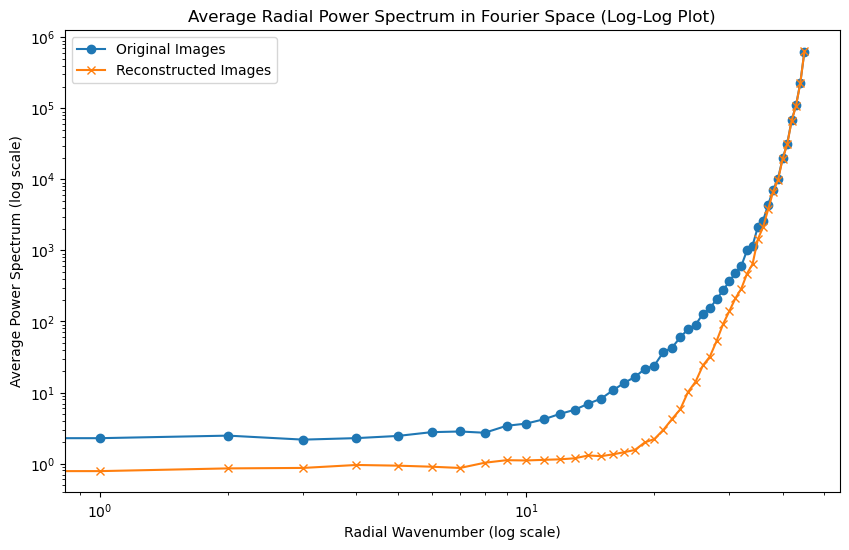

In [ ]:
def fft_radial_distance(shape):
    # Create indices for the Fourier space
    kx, ky = np.meshgrid(np.fft.fftfreq(shape[1]), np.fft.fftfreq(shape[0]))
    k = np.sqrt(kx**2 + ky**2)*sub_image_size  # Calculate radial distance in Fourier space
    return k

def radial_bin_average(image_fft, radial_dist):
    # Calculate the magnitude of the FFT (power spectrum)
    magnitude = np.abs(image_fft)**2

    # Bin the values based on radial distance
    radial_dist_int = np.rint(radial_dist).astype(int)
    tbin = np.bincount(radial_dist_int.ravel(), magnitude.ravel())
    nr = np.bincount(radial_dist_int.ravel())
    #print(tbin, nr)
    radial_profile = tbin / nr
    return radial_profile

def average_fft_power_spectrum(images):
    num_images = len(images)
    shape = images[0].shape
    radial_dist = fft_radial_distance(shape)

    # Calculate the maximum bin index, rounding up to the nearest integer
    max_bin_index = int(np.ceil(np.max(radial_dist)))
    print(max_bin_index, radial_dist)

    # Initialize the sum of radial power spectra
    sum_radial_power_spectrum = np.zeros(max_bin_index)

    for image in images:
        fft_image = np.fft.fftshift(np.fft.fft2(image))
        radial_power_spectrum = radial_bin_average(fft_image, radial_dist)
        sum_radial_power_spectrum += radial_power_spectrum

    # Average across all images
    avg_radial_power_spectrum = sum_radial_power_spectrum / num_images
    return avg_radial_power_spectrum


# Assuming originals and reconstructions are lists of numpy arrays
avg_radial_power_spectrum_originals = average_fft_power_spectrum(tf.squeeze(originals))
avg_radial_power_spectrum_reconstructions = average_fft_power_spectrum(tf.squeeze(reconstructions))

plt.figure(figsize=(10, 6))

# Plot for originals with markers
plt.loglog(avg_radial_power_spectrum_originals, label='Original Images', marker='o', linestyle='-')

# Plot for reconstructions with markers
plt.loglog(avg_radial_power_spectrum_reconstructions, label='Reconstructed Images', marker='x', linestyle='-')

plt.xlabel('Radial Wavenumber (log scale)')
plt.ylabel('Average Power Spectrum (log scale)')
plt.title('Average Radial Power Spectrum in Fourier Space (Log-Log Plot)')
plt.legend()

plt.show()



Display each of the 16 original digits together with its compressed binary representation, and the reconstructed digit.

In [ ]:
#@title

def display_digits(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((sub_image_size, sub_image_size//2), tf.float32),
        tf.squeeze(reconstructions[i]),
    ], 1)
    print(originals[i])

    axes[i].imshow(image)
    #axes[i].text(
    #    .5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
    #    ha="center", va="top", color="white", fontsize="small",
    #    transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)


InvalidArgumentError: cannot compute ConcatV2 as input #1(zero-based) was expected to be a float tensor but is a uint8 tensor [Op:ConcatV2] name: concat

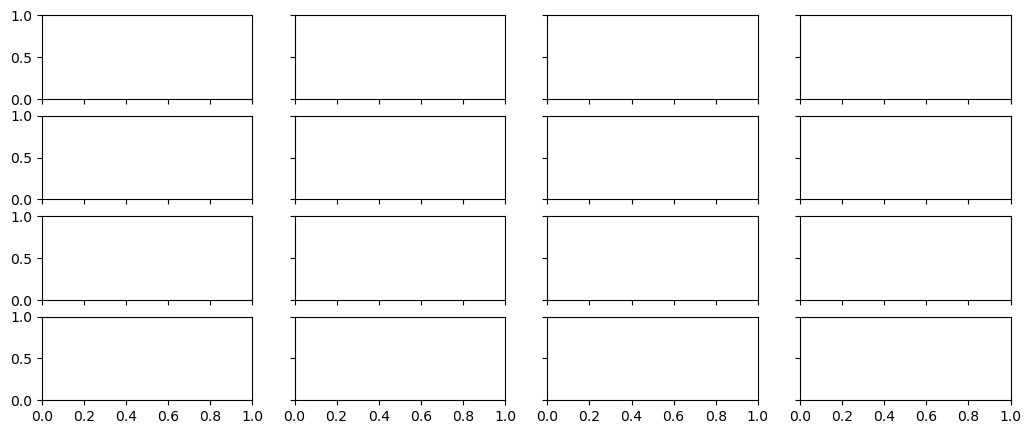

In [ ]:
display_digits(originals, strings, entropies, reconstructions)


Note that the length of the encoded string differs from the information content of each digit.

This is because the range coding process works with discrete probabilities, and has a small amount of overhead. So, especially for short strings, the correspondence is only approximate. However, range coding is **asymptotically optimal**: in the limit, the expected bit count will approach the cross entropy (the expected information content), for which the rate term in the training model is an upper bound.

## The rate–distortion trade-off

Above, the model was trained for a specific trade-off (given by `lmbda=2000`) between the average number of bits used to represent each digit and the incurred error in the reconstruction.

What happens when we repeat the experiment with different values?

Let's start by reducing $\lambda$ to 500.

In [ ]:
def train_and_visualize_model(lmbda):
  trainer = train_mnist_model(lmbda=lmbda)
  compressor, decompressor = make_mnist_codec(trainer)
  strings, entropies = compressor(originals)
  reconstructions = decompressor(strings)
  display_digits(originals, strings, entropies, reconstructions)

train_and_visualize_model(lmbda=500)


NameError: name 'train_mnist_model' is not defined

The bit rate of our code goes down, as does the fidelity of the digits. However, most of the digits remain recognizable.

Let's reduce $\lambda$ further.

Epoch 1/15



  1/469 [..............................] - ETA: 14:02 - loss: 140.1317 - distortion_loss: 0.1241 - rate_loss: 102.9066 - distortion_pass_through_loss: 0.1241 - rate_pass_through_loss: 102.9066


  4/469 [..............................] - ETA: 8s - loss: 142.1121 - distortion_loss: 0.1310 - rate_loss: 102.8232 - distortion_pass_through_loss: 0.1310 - rate_pass_through_loss: 102.8232   


  7/469 [..............................] - ETA: 9s - loss: 142.2690 - distortion_loss: 0.1319 - rate_loss: 102.7137 - distortion_pass_through_loss: 0.1319 - rate_pass_through_loss: 102.7137


 10/469 [..............................] - ETA: 8s - loss: 142.2438 - distortion_loss: 0.1321 - rate_loss: 102.6068 - distortion_pass_through_loss: 0.1321 - rate_pass_through_loss: 102.6068


 13/469 [..............................] - ETA: 8s - loss: 141.9860 - distortion_loss: 0.1316 - rate_loss: 102.5092 - distortion_pass_through_loss: 0.1316 - rate_pass_through_loss: 102.5092


 16/469 [>.............................] - ETA: 8s - loss: 141.6658 - distortion_loss: 0.1309 - rate_loss: 102.4044 - distortion_pass_through_loss: 0.1309 - rate_pass_through_loss: 102.4044


 19/469 [>.............................] - ETA: 8s - loss: 141.4616 - distortion_loss: 0.1305 - rate_loss: 102.3054 - distortion_pass_through_loss: 0.1305 - rate_pass_through_loss: 102.3054


 22/469 [>.............................] - ETA: 8s - loss: 141.3124 - distortion_loss: 0.1303 - rate_loss: 102.2155 - distortion_pass_through_loss: 0.1303 - rate_pass_through_loss: 102.2155


 25/469 [>.............................] - ETA: 8s - loss: 140.9907 - distortion_loss: 0.1296 - rate_loss: 102.1236 - distortion_pass_through_loss: 0.1296 - rate_pass_through_loss: 102.1236


 28/469 [>.............................] - ETA: 8s - loss: 140.8795 - distortion_loss: 0.1295 - rate_loss: 102.0287 - distortion_pass_through_loss: 0.1295 - rate_pass_through_loss: 102.0287


 31/469 [>.............................] - ETA: 8s - loss: 140.6079 - distortion_loss: 0.1289 - rate_loss: 101.9410 - distortion_pass_through_loss: 0.1289 - rate_pass_through_loss: 101.9410


 34/469 [=>............................] - ETA: 8s - loss: 140.3509 - distortion_loss: 0.1283 - rate_loss: 101.8566 - distortion_pass_through_loss: 0.1283 - rate_pass_through_loss: 101.8566


 37/469 [=>............................] - ETA: 8s - loss: 140.0090 - distortion_loss: 0.1275 - rate_loss: 101.7728 - distortion_pass_through_loss: 0.1275 - rate_pass_through_loss: 101.7728


 40/469 [=>............................] - ETA: 8s - loss: 139.7074 - distortion_loss: 0.1267 - rate_loss: 101.6872 - distortion_pass_through_loss: 0.1267 - rate_pass_through_loss: 101.6872


 43/469 [=>............................] - ETA: 8s - loss: 139.5062 - distortion_loss: 0.1264 - rate_loss: 101.5959 - distortion_pass_through_loss: 0.1264 - rate_pass_through_loss: 101.5959


 46/469 [=>............................] - ETA: 7s - loss: 139.2752 - distortion_loss: 0.1259 - rate_loss: 101.5066 - distortion_pass_through_loss: 0.1259 - rate_pass_through_loss: 101.5066


 49/469 [==>...........................] - ETA: 7s - loss: 139.0801 - distortion_loss: 0.1255 - rate_loss: 101.4252 - distortion_pass_through_loss: 0.1255 - rate_pass_through_loss: 101.4252


 52/469 [==>...........................] - ETA: 7s - loss: 138.8545 - distortion_loss: 0.1250 - rate_loss: 101.3455 - distortion_pass_through_loss: 0.1250 - rate_pass_through_loss: 101.3455


 55/469 [==>...........................] - ETA: 7s - loss: 138.5775 - distortion_loss: 0.1243 - rate_loss: 101.2775 - distortion_pass_through_loss: 0.1243 - rate_pass_through_loss: 101.2775


 58/469 [==>...........................] - ETA: 7s - loss: 138.3111 - distortion_loss: 0.1237 - rate_loss: 101.2141 - distortion_pass_through_loss: 0.1237 - rate_pass_through_loss: 101.2141


 61/469 [==>...........................] - ETA: 7s - loss: 138.0131 - distortion_loss: 0.1229 - rate_loss: 101.1490 - distortion_pass_through_loss: 0.1229 - rate_pass_through_loss: 101.1490


 64/469 [===>..........................] - ETA: 7s - loss: 137.7419 - distortion_loss: 0.1222 - rate_loss: 101.0815 - distortion_pass_through_loss: 0.1222 - rate_pass_through_loss: 101.0815


 67/469 [===>..........................] - ETA: 7s - loss: 137.4379 - distortion_loss: 0.1214 - rate_loss: 101.0128 - distortion_pass_through_loss: 0.1214 - rate_pass_through_loss: 101.0128


 70/469 [===>..........................] - ETA: 7s - loss: 137.1212 - distortion_loss: 0.1206 - rate_loss: 100.9406 - distortion_pass_through_loss: 0.1206 - rate_pass_through_loss: 100.9406


 73/469 [===>..........................] - ETA: 7s - loss: 136.7733 - distortion_loss: 0.1197 - rate_loss: 100.8680 - distortion_pass_through_loss: 0.1197 - rate_pass_through_loss: 100.8680


 76/469 [===>..........................] - ETA: 7s - loss: 136.4693 - distortion_loss: 0.1189 - rate_loss: 100.7997 - distortion_pass_through_loss: 0.1189 - rate_pass_through_loss: 100.7997


 79/469 [====>.........................] - ETA: 7s - loss: 136.1320 - distortion_loss: 0.1180 - rate_loss: 100.7402 - distortion_pass_through_loss: 0.1180 - rate_pass_through_loss: 100.7402


 82/469 [====>.........................] - ETA: 7s - loss: 135.8003 - distortion_loss: 0.1171 - rate_loss: 100.6744 - distortion_pass_through_loss: 0.1171 - rate_pass_through_loss: 100.6744


 85/469 [====>.........................] - ETA: 7s - loss: 135.4525 - distortion_loss: 0.1161 - rate_loss: 100.6076 - distortion_pass_through_loss: 0.1161 - rate_pass_through_loss: 100.6076


 88/469 [====>.........................] - ETA: 7s - loss: 135.1199 - distortion_loss: 0.1152 - rate_loss: 100.5469 - distortion_pass_through_loss: 0.1152 - rate_pass_through_loss: 100.5469


 91/469 [====>.........................] - ETA: 7s - loss: 134.7682 - distortion_loss: 0.1143 - rate_loss: 100.4854 - distortion_pass_through_loss: 0.1143 - rate_pass_through_loss: 100.4854


 94/469 [=====>........................] - ETA: 6s - loss: 134.4530 - distortion_loss: 0.1134 - rate_loss: 100.4248 - distortion_pass_through_loss: 0.1134 - rate_pass_through_loss: 100.4248


 97/469 [=====>........................] - ETA: 6s - loss: 134.1208 - distortion_loss: 0.1125 - rate_loss: 100.3610 - distortion_pass_through_loss: 0.1125 - rate_pass_through_loss: 100.3610


100/469 [=====>........................] - ETA: 6s - loss: 133.8273 - distortion_loss: 0.1118 - rate_loss: 100.3008 - distortion_pass_through_loss: 0.1118 - rate_pass_through_loss: 100.3008


103/469 [=====>........................] - ETA: 6s - loss: 133.5304 - distortion_loss: 0.1110 - rate_loss: 100.2340 - distortion_pass_through_loss: 0.1110 - rate_pass_through_loss: 100.2340


106/469 [=====>........................] - ETA: 6s - loss: 133.2116 - distortion_loss: 0.1102 - rate_loss: 100.1664 - distortion_pass_through_loss: 0.1102 - rate_pass_through_loss: 100.1664


109/469 [=====>........................] - ETA: 6s - loss: 132.9002 - distortion_loss: 0.1093 - rate_loss: 100.1036 - distortion_pass_through_loss: 0.1093 - rate_pass_through_loss: 100.1036


112/469 [======>.......................] - ETA: 6s - loss: 132.6237 - distortion_loss: 0.1086 - rate_loss: 100.0385 - distortion_pass_through_loss: 0.1086 - rate_pass_through_loss: 100.0385


115/469 [======>.......................] - ETA: 6s - loss: 132.3581 - distortion_loss: 0.1079 - rate_loss: 99.9742 - distortion_pass_through_loss: 0.1079 - rate_pass_through_loss: 99.9742  


118/469 [======>.......................] - ETA: 6s - loss: 132.0652 - distortion_loss: 0.1072 - rate_loss: 99.9093 - distortion_pass_through_loss: 0.1072 - rate_pass_through_loss: 99.9093


121/469 [======>.......................] - ETA: 6s - loss: 131.7876 - distortion_loss: 0.1065 - rate_loss: 99.8451 - distortion_pass_through_loss: 0.1065 - rate_pass_through_loss: 99.8451


124/469 [======>.......................] - ETA: 6s - loss: 131.5134 - distortion_loss: 0.1058 - rate_loss: 99.7779 - distortion_pass_through_loss: 0.1058 - rate_pass_through_loss: 99.7779


127/469 [=======>......................] - ETA: 6s - loss: 131.2310 - distortion_loss: 0.1051 - rate_loss: 99.7109 - distortion_pass_through_loss: 0.1051 - rate_pass_through_loss: 99.7109


130/469 [=======>......................] - ETA: 6s - loss: 130.9549 - distortion_loss: 0.1044 - rate_loss: 99.6402 - distortion_pass_through_loss: 0.1044 - rate_pass_through_loss: 99.6402


133/469 [=======>......................] - ETA: 6s - loss: 130.6826 - distortion_loss: 0.1037 - rate_loss: 99.5734 - distortion_pass_through_loss: 0.1037 - rate_pass_through_loss: 99.5734


136/469 [=======>......................] - ETA: 6s - loss: 130.4299 - distortion_loss: 0.1031 - rate_loss: 99.5038 - distortion_pass_through_loss: 0.1031 - rate_pass_through_loss: 99.5038


139/469 [=======>......................] - ETA: 6s - loss: 130.1859 - distortion_loss: 0.1025 - rate_loss: 99.4370 - distortion_pass_through_loss: 0.1025 - rate_pass_through_loss: 99.4370


142/469 [========>.....................] - ETA: 6s - loss: 129.9347 - distortion_loss: 0.1019 - rate_loss: 99.3709 - distortion_pass_through_loss: 0.1019 - rate_pass_through_loss: 99.3709


145/469 [========>.....................] - ETA: 6s - loss: 129.7001 - distortion_loss: 0.1013 - rate_loss: 99.3020 - distortion_pass_through_loss: 0.1013 - rate_pass_through_loss: 99.3020


148/469 [========>.....................] - ETA: 5s - loss: 129.4644 - distortion_loss: 0.1008 - rate_loss: 99.2323 - distortion_pass_through_loss: 0.1008 - rate_pass_through_loss: 99.2323


151/469 [========>.....................] - ETA: 5s - loss: 129.2290 - distortion_loss: 0.1002 - rate_loss: 99.1647 - distortion_pass_through_loss: 0.1002 - rate_pass_through_loss: 99.1647


154/469 [========>.....................] - ETA: 5s - loss: 129.0129 - distortion_loss: 0.0997 - rate_loss: 99.0952 - distortion_pass_through_loss: 0.0997 - rate_pass_through_loss: 99.0952


157/469 [=========>....................] - ETA: 5s - loss: 128.7950 - distortion_loss: 0.0992 - rate_loss: 99.0276 - distortion_pass_through_loss: 0.0992 - rate_pass_through_loss: 99.0276


160/469 [=========>....................] - ETA: 5s - loss: 128.5819 - distortion_loss: 0.0987 - rate_loss: 98.9578 - distortion_pass_through_loss: 0.0987 - rate_pass_through_loss: 98.9578


163/469 [=========>....................] - ETA: 5s - loss: 128.3564 - distortion_loss: 0.0982 - rate_loss: 98.8862 - distortion_pass_through_loss: 0.0982 - rate_pass_through_loss: 98.8862


166/469 [=========>....................] - ETA: 5s - loss: 128.1454 - distortion_loss: 0.0978 - rate_loss: 98.8159 - distortion_pass_through_loss: 0.0978 - rate_pass_through_loss: 98.8159


169/469 [=========>....................] - ETA: 5s - loss: 127.9402 - distortion_loss: 0.0973 - rate_loss: 98.7453 - distortion_pass_through_loss: 0.0973 - rate_pass_through_loss: 98.7453


172/469 [==========>...................] - ETA: 5s - loss: 127.7284 - distortion_loss: 0.0968 - rate_loss: 98.6759 - distortion_pass_through_loss: 0.0968 - rate_pass_through_loss: 98.6759


175/469 [==========>...................] - ETA: 5s - loss: 127.5294 - distortion_loss: 0.0964 - rate_loss: 98.6038 - distortion_pass_through_loss: 0.0964 - rate_pass_through_loss: 98.6038


178/469 [==========>...................] - ETA: 5s - loss: 127.3260 - distortion_loss: 0.0960 - rate_loss: 98.5331 - distortion_pass_through_loss: 0.0960 - rate_pass_through_loss: 98.5331


181/469 [==========>...................] - ETA: 5s - loss: 127.1338 - distortion_loss: 0.0956 - rate_loss: 98.4646 - distortion_pass_through_loss: 0.0956 - rate_pass_through_loss: 98.4646


184/469 [==========>...................] - ETA: 5s - loss: 126.9410 - distortion_loss: 0.0952 - rate_loss: 98.3934 - distortion_pass_through_loss: 0.0952 - rate_pass_through_loss: 98.3934


187/469 [==========>...................] - ETA: 5s - loss: 126.7424 - distortion_loss: 0.0947 - rate_loss: 98.3220 - distortion_pass_through_loss: 0.0947 - rate_pass_through_loss: 98.3220


190/469 [===========>..................] - ETA: 5s - loss: 126.5544 - distortion_loss: 0.0943 - rate_loss: 98.2503 - distortion_pass_through_loss: 0.0943 - rate_pass_through_loss: 98.2503


193/469 [===========>..................] - ETA: 5s - loss: 126.3688 - distortion_loss: 0.0940 - rate_loss: 98.1764 - distortion_pass_through_loss: 0.0940 - rate_pass_through_loss: 98.1764


196/469 [===========>..................] - ETA: 5s - loss: 126.1832 - distortion_loss: 0.0936 - rate_loss: 98.1035 - distortion_pass_through_loss: 0.0936 - rate_pass_through_loss: 98.1035


199/469 [===========>..................] - ETA: 5s - loss: 125.9890 - distortion_loss: 0.0932 - rate_loss: 98.0281 - distortion_pass_through_loss: 0.0932 - rate_pass_through_loss: 98.0281


202/469 [===========>..................] - ETA: 4s - loss: 125.8005 - distortion_loss: 0.0928 - rate_loss: 97.9555 - distortion_pass_through_loss: 0.0928 - rate_pass_through_loss: 97.9555


205/469 [============>.................] - ETA: 4s - loss: 125.6167 - distortion_loss: 0.0925 - rate_loss: 97.8815 - distortion_pass_through_loss: 0.0925 - rate_pass_through_loss: 97.8815


208/469 [============>.................] - ETA: 4s - loss: 125.4330 - distortion_loss: 0.0921 - rate_loss: 97.8086 - distortion_pass_through_loss: 0.0921 - rate_pass_through_loss: 97.8086


211/469 [============>.................] - ETA: 4s - loss: 125.2451 - distortion_loss: 0.0917 - rate_loss: 97.7342 - distortion_pass_through_loss: 0.0917 - rate_pass_through_loss: 97.7342


214/469 [============>.................] - ETA: 4s - loss: 125.0699 - distortion_loss: 0.0914 - rate_loss: 97.6605 - distortion_pass_through_loss: 0.0914 - rate_pass_through_loss: 97.6605


217/469 [============>.................] - ETA: 4s - loss: 124.8948 - distortion_loss: 0.0910 - rate_loss: 97.5869 - distortion_pass_through_loss: 0.0910 - rate_pass_through_loss: 97.5869


220/469 [=============>................] - ETA: 4s - loss: 124.7211 - distortion_loss: 0.0907 - rate_loss: 97.5137 - distortion_pass_through_loss: 0.0907 - rate_pass_through_loss: 97.5137


223/469 [=============>................] - ETA: 4s - loss: 124.5488 - distortion_loss: 0.0904 - rate_loss: 97.4393 - distortion_pass_through_loss: 0.0904 - rate_pass_through_loss: 97.4393


226/469 [=============>................] - ETA: 4s - loss: 124.3698 - distortion_loss: 0.0900 - rate_loss: 97.3654 - distortion_pass_through_loss: 0.0900 - rate_pass_through_loss: 97.3654


229/469 [=============>................] - ETA: 4s - loss: 124.2047 - distortion_loss: 0.0897 - rate_loss: 97.2913 - distortion_pass_through_loss: 0.0897 - rate_pass_through_loss: 97.2913


232/469 [=============>................] - ETA: 4s - loss: 124.0413 - distortion_loss: 0.0894 - rate_loss: 97.2179 - distortion_pass_through_loss: 0.0894 - rate_pass_through_loss: 97.2179


235/469 [==============>...............] - ETA: 4s - loss: 123.8734 - distortion_loss: 0.0891 - rate_loss: 97.1417 - distortion_pass_through_loss: 0.0891 - rate_pass_through_loss: 97.1417


238/469 [==============>...............] - ETA: 4s - loss: 123.7079 - distortion_loss: 0.0888 - rate_loss: 97.0658 - distortion_pass_through_loss: 0.0888 - rate_pass_through_loss: 97.0658


241/469 [==============>...............] - ETA: 4s - loss: 123.5486 - distortion_loss: 0.0885 - rate_loss: 96.9901 - distortion_pass_through_loss: 0.0885 - rate_pass_through_loss: 96.9901


244/469 [==============>...............] - ETA: 4s - loss: 123.3830 - distortion_loss: 0.0882 - rate_loss: 96.9152 - distortion_pass_through_loss: 0.0882 - rate_pass_through_loss: 96.9152


247/469 [==============>...............] - ETA: 4s - loss: 123.2324 - distortion_loss: 0.0880 - rate_loss: 96.8391 - distortion_pass_through_loss: 0.0880 - rate_pass_through_loss: 96.8391


250/469 [==============>...............] - ETA: 4s - loss: 123.0789 - distortion_loss: 0.0877 - rate_loss: 96.7638 - distortion_pass_through_loss: 0.0877 - rate_pass_through_loss: 96.7638


253/469 [===============>..............] - ETA: 4s - loss: 122.9233 - distortion_loss: 0.0875 - rate_loss: 96.6868 - distortion_pass_through_loss: 0.0875 - rate_pass_through_loss: 96.6868


256/469 [===============>..............] - ETA: 3s - loss: 122.7633 - distortion_loss: 0.0872 - rate_loss: 96.6103 - distortion_pass_through_loss: 0.0872 - rate_pass_through_loss: 96.6103


259/469 [===============>..............] - ETA: 3s - loss: 122.6110 - distortion_loss: 0.0869 - rate_loss: 96.5336 - distortion_pass_through_loss: 0.0869 - rate_pass_through_loss: 96.5336


262/469 [===============>..............] - ETA: 3s - loss: 122.4579 - distortion_loss: 0.0867 - rate_loss: 96.4585 - distortion_pass_through_loss: 0.0867 - rate_pass_through_loss: 96.4585


265/469 [===============>..............] - ETA: 3s - loss: 122.3026 - distortion_loss: 0.0864 - rate_loss: 96.3831 - distortion_pass_through_loss: 0.0864 - rate_pass_through_loss: 96.3831


268/469 [================>.............] - ETA: 3s - loss: 122.1485 - distortion_loss: 0.0861 - rate_loss: 96.3059 - distortion_pass_through_loss: 0.0861 - rate_pass_through_loss: 96.3059


271/469 [================>.............] - ETA: 3s - loss: 121.9987 - distortion_loss: 0.0859 - rate_loss: 96.2292 - distortion_pass_through_loss: 0.0859 - rate_pass_through_loss: 96.2292


274/469 [================>.............] - ETA: 3s - loss: 121.8526 - distortion_loss: 0.0857 - rate_loss: 96.1511 - distortion_pass_through_loss: 0.0857 - rate_pass_through_loss: 96.1511


277/469 [================>.............] - ETA: 3s - loss: 121.7048 - distortion_loss: 0.0854 - rate_loss: 96.0743 - distortion_pass_through_loss: 0.0854 - rate_pass_through_loss: 96.0743


280/469 [================>.............] - ETA: 3s - loss: 121.5553 - distortion_loss: 0.0852 - rate_loss: 95.9985 - distortion_pass_through_loss: 0.0852 - rate_pass_through_loss: 95.9985


283/469 [=================>............] - ETA: 3s - loss: 121.4211 - distortion_loss: 0.0850 - rate_loss: 95.9221 - distortion_pass_through_loss: 0.0850 - rate_pass_through_loss: 95.9221


286/469 [=================>............] - ETA: 3s - loss: 121.2813 - distortion_loss: 0.0848 - rate_loss: 95.8472 - distortion_pass_through_loss: 0.0848 - rate_pass_through_loss: 95.8472


289/469 [=================>............] - ETA: 3s - loss: 121.1394 - distortion_loss: 0.0846 - rate_loss: 95.7699 - distortion_pass_through_loss: 0.0846 - rate_pass_through_loss: 95.7699


292/469 [=================>............] - ETA: 3s - loss: 120.9906 - distortion_loss: 0.0843 - rate_loss: 95.6913 - distortion_pass_through_loss: 0.0843 - rate_pass_through_loss: 95.6913


295/469 [=================>............] - ETA: 3s - loss: 120.8456 - distortion_loss: 0.0841 - rate_loss: 95.6132 - distortion_pass_through_loss: 0.0841 - rate_pass_through_loss: 95.6132


298/469 [==================>...........] - ETA: 3s - loss: 120.7013 - distortion_loss: 0.0839 - rate_loss: 95.5361 - distortion_pass_through_loss: 0.0839 - rate_pass_through_loss: 95.5361


301/469 [==================>...........] - ETA: 3s - loss: 120.5651 - distortion_loss: 0.0837 - rate_loss: 95.4595 - distortion_pass_through_loss: 0.0837 - rate_pass_through_loss: 95.4595


304/469 [==================>...........] - ETA: 3s - loss: 120.4224 - distortion_loss: 0.0835 - rate_loss: 95.3802 - distortion_pass_through_loss: 0.0835 - rate_pass_through_loss: 95.3802


307/469 [==================>...........] - ETA: 3s - loss: 120.2880 - distortion_loss: 0.0833 - rate_loss: 95.3028 - distortion_pass_through_loss: 0.0833 - rate_pass_through_loss: 95.3028


310/469 [==================>...........] - ETA: 2s - loss: 120.1536 - distortion_loss: 0.0831 - rate_loss: 95.2249 - distortion_pass_through_loss: 0.0831 - rate_pass_through_loss: 95.2249


313/469 [===================>..........] - ETA: 2s - loss: 120.0180 - distortion_loss: 0.0829 - rate_loss: 95.1490 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 95.1490


316/469 [===================>..........] - ETA: 2s - loss: 119.8820 - distortion_loss: 0.0827 - rate_loss: 95.0696 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 95.0696


319/469 [===================>..........] - ETA: 2s - loss: 119.7465 - distortion_loss: 0.0825 - rate_loss: 94.9922 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 94.9922


322/469 [===================>..........] - ETA: 2s - loss: 119.6136 - distortion_loss: 0.0823 - rate_loss: 94.9141 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 94.9141


325/469 [===================>..........] - ETA: 2s - loss: 119.4793 - distortion_loss: 0.0821 - rate_loss: 94.8369 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 94.8369


328/469 [===================>..........] - ETA: 2s - loss: 119.3489 - distortion_loss: 0.0820 - rate_loss: 94.7595 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 94.7595


331/469 [====================>.........] - ETA: 2s - loss: 119.2165 - distortion_loss: 0.0818 - rate_loss: 94.6821 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 94.6821


334/469 [====================>.........] - ETA: 2s - loss: 119.0869 - distortion_loss: 0.0816 - rate_loss: 94.6026 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 94.6026


337/469 [====================>.........] - ETA: 2s - loss: 118.9573 - distortion_loss: 0.0814 - rate_loss: 94.5234 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 94.5234


340/469 [====================>.........] - ETA: 2s - loss: 118.8270 - distortion_loss: 0.0813 - rate_loss: 94.4451 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 94.4451


343/469 [====================>.........] - ETA: 2s - loss: 118.6970 - distortion_loss: 0.0811 - rate_loss: 94.3670 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 94.3670


346/469 [=====================>........] - ETA: 2s - loss: 118.5655 - distortion_loss: 0.0809 - rate_loss: 94.2874 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 94.2874


349/469 [=====================>........] - ETA: 2s - loss: 118.4430 - distortion_loss: 0.0808 - rate_loss: 94.2106 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 94.2106


352/469 [=====================>........] - ETA: 2s - loss: 118.3176 - distortion_loss: 0.0806 - rate_loss: 94.1315 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 94.1315


355/469 [=====================>........] - ETA: 2s - loss: 118.1894 - distortion_loss: 0.0805 - rate_loss: 94.0526 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 94.0526


358/469 [=====================>........] - ETA: 2s - loss: 118.0629 - distortion_loss: 0.0803 - rate_loss: 93.9735 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 93.9735


361/469 [======================>.......] - ETA: 2s - loss: 117.9415 - distortion_loss: 0.0802 - rate_loss: 93.8946 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 93.8946


364/469 [======================>.......] - ETA: 1s - loss: 117.8178 - distortion_loss: 0.0800 - rate_loss: 93.8159 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 93.8159


367/469 [======================>.......] - ETA: 1s - loss: 117.6946 - distortion_loss: 0.0799 - rate_loss: 93.7373 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 93.7373


370/469 [======================>.......] - ETA: 1s - loss: 117.5703 - distortion_loss: 0.0797 - rate_loss: 93.6587 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 93.6587


373/469 [======================>.......] - ETA: 1s - loss: 117.4474 - distortion_loss: 0.0796 - rate_loss: 93.5805 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 93.5805


376/469 [=======================>......] - ETA: 1s - loss: 117.3245 - distortion_loss: 0.0794 - rate_loss: 93.5006 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 93.5006


379/469 [=======================>......] - ETA: 1s - loss: 117.2029 - distortion_loss: 0.0793 - rate_loss: 93.4212 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 93.4212


382/469 [=======================>......] - ETA: 1s - loss: 117.0805 - distortion_loss: 0.0791 - rate_loss: 93.3427 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 93.3427


385/469 [=======================>......] - ETA: 1s - loss: 116.9574 - distortion_loss: 0.0790 - rate_loss: 93.2644 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 93.2644


388/469 [=======================>......] - ETA: 1s - loss: 116.8403 - distortion_loss: 0.0788 - rate_loss: 93.1855 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 93.1855


391/469 [========================>.....] - ETA: 1s - loss: 116.7182 - distortion_loss: 0.0787 - rate_loss: 93.1053 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 93.1053


394/469 [========================>.....] - ETA: 1s - loss: 116.5976 - distortion_loss: 0.0786 - rate_loss: 93.0265 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 93.0265


397/469 [========================>.....] - ETA: 1s - loss: 116.4783 - distortion_loss: 0.0784 - rate_loss: 92.9476 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 92.9476


400/469 [========================>.....] - ETA: 1s - loss: 116.3593 - distortion_loss: 0.0783 - rate_loss: 92.8682 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 92.8682


403/469 [========================>.....] - ETA: 1s - loss: 116.2362 - distortion_loss: 0.0782 - rate_loss: 92.7885 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 92.7885


406/469 [========================>.....] - ETA: 1s - loss: 116.1208 - distortion_loss: 0.0780 - rate_loss: 92.7093 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 92.7093


409/469 [=========================>....] - ETA: 1s - loss: 116.0038 - distortion_loss: 0.0779 - rate_loss: 92.6300 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 92.6300


412/469 [=========================>....] - ETA: 1s - loss: 115.8901 - distortion_loss: 0.0778 - rate_loss: 92.5509 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 92.5509


415/469 [=========================>....] - ETA: 1s - loss: 115.7743 - distortion_loss: 0.0777 - rate_loss: 92.4724 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 92.4724


418/469 [=========================>....] - ETA: 0s - loss: 115.6576 - distortion_loss: 0.0775 - rate_loss: 92.3933 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 92.3933


421/469 [=========================>....] - ETA: 0s - loss: 115.5416 - distortion_loss: 0.0774 - rate_loss: 92.3144 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 92.3144


424/469 [==========================>...] - ETA: 0s - loss: 115.4265 - distortion_loss: 0.0773 - rate_loss: 92.2358 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 92.2358


427/469 [==========================>...] - ETA: 0s - loss: 115.3160 - distortion_loss: 0.0772 - rate_loss: 92.1567 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 92.1567


430/469 [==========================>...] - ETA: 0s - loss: 115.2079 - distortion_loss: 0.0771 - rate_loss: 92.0777 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 92.0777


433/469 [==========================>...] - ETA: 0s - loss: 115.0958 - distortion_loss: 0.0770 - rate_loss: 91.9978 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 91.9978


436/469 [==========================>...] - ETA: 0s - loss: 114.9820 - distortion_loss: 0.0769 - rate_loss: 91.9181 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 91.9181


439/469 [===========================>..] - ETA: 0s - loss: 114.8710 - distortion_loss: 0.0768 - rate_loss: 91.8390 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 91.8390


442/469 [===========================>..] - ETA: 0s - loss: 114.7612 - distortion_loss: 0.0767 - rate_loss: 91.7604 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 91.7604


445/469 [===========================>..] - ETA: 0s - loss: 114.6491 - distortion_loss: 0.0766 - rate_loss: 91.6814 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 91.6814


448/469 [===========================>..] - ETA: 0s - loss: 114.5419 - distortion_loss: 0.0765 - rate_loss: 91.6030 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 91.6030


451/469 [===========================>..] - ETA: 0s - loss: 114.4312 - distortion_loss: 0.0764 - rate_loss: 91.5249 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 91.5249


454/469 [============================>.] - ETA: 0s - loss: 114.3208 - distortion_loss: 0.0763 - rate_loss: 91.4454 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 91.4454


457/469 [============================>.] - ETA: 0s - loss: 114.2114 - distortion_loss: 0.0761 - rate_loss: 91.3674 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 91.3674


460/469 [============================>.] - ETA: 0s - loss: 114.1036 - distortion_loss: 0.0761 - rate_loss: 91.2882 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 91.2882


463/469 [============================>.] - ETA: 0s - loss: 113.9955 - distortion_loss: 0.0760 - rate_loss: 91.2087 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 91.2087


466/469 [============================>.] - ETA: 0s - loss: 113.8880 - distortion_loss: 0.0759 - rate_loss: 91.1298 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 91.1298


469/469 [==============================] - ETA: 0s - loss: 113.7853 - distortion_loss: 0.0758 - rate_loss: 91.0564 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 91.0497


469/469 [==============================] - 11s 20ms/step - loss: 113.7853 - distortion_loss: 0.0758 - rate_loss: 91.0564 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 91.0497 - val_loss: 96.0908 - val_distortion_loss: 0.0651 - val_rate_loss: 76.5526 - val_distortion_pass_through_loss: 0.0652 - val_rate_pass_through_loss: 76.5547


Epoch 2/15



  1/469 [..............................] - ETA: 10s - loss: 95.6689 - distortion_loss: 0.0571 - rate_loss: 78.5272 - distortion_pass_through_loss: 0.0571 - rate_pass_through_loss: 78.5272


  4/469 [..............................] - ETA: 8s - loss: 96.4890 - distortion_loss: 0.0597 - rate_loss: 78.5911 - distortion_pass_through_loss: 0.0597 - rate_pass_through_loss: 78.5911 


  7/469 [..............................] - ETA: 8s - loss: 96.6263 - distortion_loss: 0.0603 - rate_loss: 78.5495 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 78.5495


 10/469 [..............................] - ETA: 8s - loss: 96.7075 - distortion_loss: 0.0608 - rate_loss: 78.4757 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 78.4757


 13/469 [..............................] - ETA: 8s - loss: 96.5409 - distortion_loss: 0.0606 - rate_loss: 78.3700 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 78.3700


 16/469 [>.............................] - ETA: 8s - loss: 96.4445 - distortion_loss: 0.0605 - rate_loss: 78.2979 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 78.2979


 19/469 [>.............................] - ETA: 8s - loss: 96.4153 - distortion_loss: 0.0606 - rate_loss: 78.2362 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 78.2362


 22/469 [>.............................] - ETA: 8s - loss: 96.3771 - distortion_loss: 0.0607 - rate_loss: 78.1642 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 78.1642


 25/469 [>.............................] - ETA: 8s - loss: 96.2792 - distortion_loss: 0.0607 - rate_loss: 78.0775 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 78.0775


 28/469 [>.............................] - ETA: 8s - loss: 96.2340 - distortion_loss: 0.0607 - rate_loss: 78.0182 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 78.0182


 31/469 [>.............................] - ETA: 8s - loss: 96.1226 - distortion_loss: 0.0606 - rate_loss: 77.9276 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.9276


 34/469 [=>............................] - ETA: 8s - loss: 96.0645 - distortion_loss: 0.0607 - rate_loss: 77.8537 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 77.8537


 37/469 [=>............................] - ETA: 7s - loss: 95.9329 - distortion_loss: 0.0606 - rate_loss: 77.7585 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.7585


 40/469 [=>............................] - ETA: 7s - loss: 95.8668 - distortion_loss: 0.0606 - rate_loss: 77.6854 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.6854


 43/469 [=>............................] - ETA: 7s - loss: 95.7798 - distortion_loss: 0.0606 - rate_loss: 77.6021 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.6021


 46/469 [=>............................] - ETA: 7s - loss: 95.6814 - distortion_loss: 0.0605 - rate_loss: 77.5191 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 77.5191


 49/469 [==>...........................] - ETA: 7s - loss: 95.6262 - distortion_loss: 0.0606 - rate_loss: 77.4478 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.4478


 52/469 [==>...........................] - ETA: 7s - loss: 95.5546 - distortion_loss: 0.0606 - rate_loss: 77.3722 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.3722


 55/469 [==>...........................] - ETA: 7s - loss: 95.4725 - distortion_loss: 0.0606 - rate_loss: 77.2946 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.2946


 58/469 [==>...........................] - ETA: 7s - loss: 95.4026 - distortion_loss: 0.0606 - rate_loss: 77.2243 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.2243


 61/469 [==>...........................] - ETA: 7s - loss: 95.3280 - distortion_loss: 0.0606 - rate_loss: 77.1544 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.1544


 64/469 [===>..........................] - ETA: 7s - loss: 95.2763 - distortion_loss: 0.0607 - rate_loss: 77.0780 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 77.0780


 67/469 [===>..........................] - ETA: 7s - loss: 95.2113 - distortion_loss: 0.0607 - rate_loss: 77.0000 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 77.0000


 70/469 [===>..........................] - ETA: 7s - loss: 95.1269 - distortion_loss: 0.0607 - rate_loss: 76.9294 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 76.9294


 73/469 [===>..........................] - ETA: 7s - loss: 95.0277 - distortion_loss: 0.0606 - rate_loss: 76.8510 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 76.8510


 76/469 [===>..........................] - ETA: 7s - loss: 94.9524 - distortion_loss: 0.0606 - rate_loss: 76.7739 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 76.7739


 79/469 [====>.........................] - ETA: 7s - loss: 94.8664 - distortion_loss: 0.0606 - rate_loss: 76.6911 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 76.6911


 82/469 [====>.........................] - ETA: 7s - loss: 94.7893 - distortion_loss: 0.0606 - rate_loss: 76.6199 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 76.6199


 85/469 [====>.........................] - ETA: 7s - loss: 94.7005 - distortion_loss: 0.0605 - rate_loss: 76.5487 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 76.5487


 88/469 [====>.........................] - ETA: 7s - loss: 94.6160 - distortion_loss: 0.0605 - rate_loss: 76.4713 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 76.4713


 91/469 [====>.........................] - ETA: 7s - loss: 94.5185 - distortion_loss: 0.0604 - rate_loss: 76.3922 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 76.3922


 94/469 [=====>........................] - ETA: 6s - loss: 94.4450 - distortion_loss: 0.0604 - rate_loss: 76.3147 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 76.3147


 97/469 [=====>........................] - ETA: 6s - loss: 94.3580 - distortion_loss: 0.0604 - rate_loss: 76.2399 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 76.2399


100/469 [=====>........................] - ETA: 6s - loss: 94.2886 - distortion_loss: 0.0604 - rate_loss: 76.1734 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 76.1734


103/469 [=====>........................] - ETA: 6s - loss: 94.2177 - distortion_loss: 0.0604 - rate_loss: 76.0956 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 76.0956


106/469 [=====>........................] - ETA: 6s - loss: 94.1288 - distortion_loss: 0.0604 - rate_loss: 76.0194 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 76.0194


109/469 [=====>........................] - ETA: 6s - loss: 94.0441 - distortion_loss: 0.0603 - rate_loss: 75.9399 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 75.9399


112/469 [======>.......................] - ETA: 6s - loss: 93.9699 - distortion_loss: 0.0603 - rate_loss: 75.8708 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 75.8708


115/469 [======>.......................] - ETA: 6s - loss: 93.9106 - distortion_loss: 0.0604 - rate_loss: 75.7920 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 75.7920


118/469 [======>.......................] - ETA: 6s - loss: 93.8216 - distortion_loss: 0.0604 - rate_loss: 75.7132 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 75.7132


121/469 [======>.......................] - ETA: 6s - loss: 93.7368 - distortion_loss: 0.0603 - rate_loss: 75.6426 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 75.6426


124/469 [======>.......................] - ETA: 6s - loss: 93.6556 - distortion_loss: 0.0603 - rate_loss: 75.5689 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 75.5689


127/469 [=======>......................] - ETA: 6s - loss: 93.5705 - distortion_loss: 0.0603 - rate_loss: 75.4919 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 75.4919


130/469 [=======>......................] - ETA: 6s - loss: 93.4855 - distortion_loss: 0.0602 - rate_loss: 75.4154 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 75.4154


133/469 [=======>......................] - ETA: 6s - loss: 93.4026 - distortion_loss: 0.0602 - rate_loss: 75.3372 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 75.3372


136/469 [=======>......................] - ETA: 6s - loss: 93.3305 - distortion_loss: 0.0602 - rate_loss: 75.2621 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 75.2621


139/469 [=======>......................] - ETA: 6s - loss: 93.2583 - distortion_loss: 0.0602 - rate_loss: 75.1901 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 75.1901


142/469 [========>.....................] - ETA: 6s - loss: 93.1811 - distortion_loss: 0.0602 - rate_loss: 75.1139 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 75.1139


145/469 [========>.....................] - ETA: 6s - loss: 93.1102 - distortion_loss: 0.0602 - rate_loss: 75.0404 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 75.0404


148/469 [========>.....................] - ETA: 6s - loss: 93.0383 - distortion_loss: 0.0603 - rate_loss: 74.9624 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.9624


151/469 [========>.....................] - ETA: 5s - loss: 92.9656 - distortion_loss: 0.0603 - rate_loss: 74.8891 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.8891


154/469 [========>.....................] - ETA: 5s - loss: 92.9028 - distortion_loss: 0.0603 - rate_loss: 74.8192 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.8192


157/469 [=========>....................] - ETA: 5s - loss: 92.8313 - distortion_loss: 0.0603 - rate_loss: 74.7465 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.7465


160/469 [=========>....................] - ETA: 5s - loss: 92.7613 - distortion_loss: 0.0603 - rate_loss: 74.6716 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.6716


163/469 [=========>....................] - ETA: 5s - loss: 92.6843 - distortion_loss: 0.0603 - rate_loss: 74.5988 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.5988


166/469 [=========>....................] - ETA: 5s - loss: 92.6159 - distortion_loss: 0.0603 - rate_loss: 74.5266 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.5266


169/469 [=========>....................] - ETA: 5s - loss: 92.5469 - distortion_loss: 0.0603 - rate_loss: 74.4565 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.4565


172/469 [==========>...................] - ETA: 5s - loss: 92.4682 - distortion_loss: 0.0603 - rate_loss: 74.3810 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.3810


175/469 [==========>...................] - ETA: 5s - loss: 92.4050 - distortion_loss: 0.0603 - rate_loss: 74.3082 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.3082


178/469 [==========>...................] - ETA: 5s - loss: 92.3306 - distortion_loss: 0.0603 - rate_loss: 74.2359 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.2359


181/469 [==========>...................] - ETA: 5s - loss: 92.2669 - distortion_loss: 0.0603 - rate_loss: 74.1653 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.1653


184/469 [==========>...................] - ETA: 5s - loss: 92.1991 - distortion_loss: 0.0604 - rate_loss: 74.0894 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 74.0894


187/469 [==========>...................] - ETA: 5s - loss: 92.1284 - distortion_loss: 0.0604 - rate_loss: 74.0118 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 74.0118


190/469 [===========>..................] - ETA: 5s - loss: 92.0635 - distortion_loss: 0.0604 - rate_loss: 73.9435 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.9435


193/469 [===========>..................] - ETA: 5s - loss: 91.9955 - distortion_loss: 0.0604 - rate_loss: 73.8740 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.8740


196/469 [===========>..................] - ETA: 5s - loss: 91.9242 - distortion_loss: 0.0604 - rate_loss: 73.8052 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.8052


199/469 [===========>..................] - ETA: 5s - loss: 91.8443 - distortion_loss: 0.0604 - rate_loss: 73.7292 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.7292


202/469 [===========>..................] - ETA: 5s - loss: 91.7711 - distortion_loss: 0.0604 - rate_loss: 73.6538 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.6538


205/469 [============>.................] - ETA: 4s - loss: 91.6975 - distortion_loss: 0.0604 - rate_loss: 73.5787 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.5787


208/469 [============>.................] - ETA: 4s - loss: 91.6217 - distortion_loss: 0.0604 - rate_loss: 73.5085 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.5085


211/469 [============>.................] - ETA: 4s - loss: 91.5419 - distortion_loss: 0.0604 - rate_loss: 73.4348 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.4348


214/469 [============>.................] - ETA: 4s - loss: 91.4719 - distortion_loss: 0.0604 - rate_loss: 73.3615 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.3615


217/469 [============>.................] - ETA: 4s - loss: 91.3976 - distortion_loss: 0.0604 - rate_loss: 73.2876 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.2876


220/469 [=============>................] - ETA: 4s - loss: 91.3258 - distortion_loss: 0.0604 - rate_loss: 73.2167 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.2167


223/469 [=============>................] - ETA: 4s - loss: 91.2514 - distortion_loss: 0.0604 - rate_loss: 73.1463 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.1463


226/469 [=============>................] - ETA: 4s - loss: 91.1753 - distortion_loss: 0.0603 - rate_loss: 73.0743 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 73.0743


229/469 [=============>................] - ETA: 4s - loss: 91.1080 - distortion_loss: 0.0604 - rate_loss: 73.0015 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.0015


232/469 [=============>................] - ETA: 4s - loss: 91.0410 - distortion_loss: 0.0604 - rate_loss: 72.9285 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 72.9285


235/469 [==============>...............] - ETA: 4s - loss: 90.9688 - distortion_loss: 0.0604 - rate_loss: 72.8575 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 72.8575


238/469 [==============>...............] - ETA: 4s - loss: 90.8982 - distortion_loss: 0.0604 - rate_loss: 72.7878 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 72.7878


241/469 [==============>...............] - ETA: 4s - loss: 90.8300 - distortion_loss: 0.0604 - rate_loss: 72.7168 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 72.7168


244/469 [==============>...............] - ETA: 4s - loss: 90.7563 - distortion_loss: 0.0604 - rate_loss: 72.6412 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 72.6412


247/469 [==============>...............] - ETA: 4s - loss: 90.6960 - distortion_loss: 0.0604 - rate_loss: 72.5709 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 72.5709


250/469 [==============>...............] - ETA: 4s - loss: 90.6331 - distortion_loss: 0.0605 - rate_loss: 72.4970 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.4970


253/469 [===============>..............] - ETA: 4s - loss: 90.5682 - distortion_loss: 0.0605 - rate_loss: 72.4278 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.4278


256/469 [===============>..............] - ETA: 4s - loss: 90.4965 - distortion_loss: 0.0605 - rate_loss: 72.3550 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.3550


259/469 [===============>..............] - ETA: 3s - loss: 90.4295 - distortion_loss: 0.0605 - rate_loss: 72.2860 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.2860


262/469 [===============>..............] - ETA: 3s - loss: 90.3603 - distortion_loss: 0.0605 - rate_loss: 72.2153 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.2153


265/469 [===============>..............] - ETA: 3s - loss: 90.2901 - distortion_loss: 0.0605 - rate_loss: 72.1421 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.1421


268/469 [================>.............] - ETA: 3s - loss: 90.2179 - distortion_loss: 0.0605 - rate_loss: 72.0712 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.0712


271/469 [================>.............] - ETA: 3s - loss: 90.1528 - distortion_loss: 0.0605 - rate_loss: 71.9987 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 71.9987


274/469 [================>.............] - ETA: 3s - loss: 90.0869 - distortion_loss: 0.0605 - rate_loss: 71.9292 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 71.9292


277/469 [================>.............] - ETA: 3s - loss: 90.0179 - distortion_loss: 0.0605 - rate_loss: 71.8581 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 71.8581


280/469 [================>.............] - ETA: 3s - loss: 89.9465 - distortion_loss: 0.0605 - rate_loss: 71.7886 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 71.7886


283/469 [=================>............] - ETA: 3s - loss: 89.8855 - distortion_loss: 0.0606 - rate_loss: 71.7189 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.7189


286/469 [=================>............] - ETA: 3s - loss: 89.8195 - distortion_loss: 0.0606 - rate_loss: 71.6504 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.6504


289/469 [=================>............] - ETA: 3s - loss: 89.7522 - distortion_loss: 0.0606 - rate_loss: 71.5813 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.5813


292/469 [=================>............] - ETA: 3s - loss: 89.6779 - distortion_loss: 0.0606 - rate_loss: 71.5104 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.5104


295/469 [=================>............] - ETA: 3s - loss: 89.6062 - distortion_loss: 0.0606 - rate_loss: 71.4394 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.4394


298/469 [==================>...........] - ETA: 3s - loss: 89.5357 - distortion_loss: 0.0606 - rate_loss: 71.3689 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.3689


301/469 [==================>...........] - ETA: 3s - loss: 89.4701 - distortion_loss: 0.0606 - rate_loss: 71.3003 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.3003


304/469 [==================>...........] - ETA: 3s - loss: 89.3969 - distortion_loss: 0.0606 - rate_loss: 71.2291 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.2291


307/469 [==================>...........] - ETA: 3s - loss: 89.3329 - distortion_loss: 0.0606 - rate_loss: 71.1591 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.1591


310/469 [==================>...........] - ETA: 3s - loss: 89.2684 - distortion_loss: 0.0606 - rate_loss: 71.0877 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.0877


313/469 [===================>..........] - ETA: 2s - loss: 89.2024 - distortion_loss: 0.0606 - rate_loss: 71.0217 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.0217


316/469 [===================>..........] - ETA: 2s - loss: 89.1370 - distortion_loss: 0.0606 - rate_loss: 70.9555 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.9555


319/469 [===================>..........] - ETA: 2s - loss: 89.0708 - distortion_loss: 0.0606 - rate_loss: 70.8888 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.8888


322/469 [===================>..........] - ETA: 2s - loss: 89.0042 - distortion_loss: 0.0606 - rate_loss: 70.8176 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.8176


325/469 [===================>..........] - ETA: 2s - loss: 88.9356 - distortion_loss: 0.0606 - rate_loss: 70.7450 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.7450


328/469 [===================>..........] - ETA: 2s - loss: 88.8700 - distortion_loss: 0.0606 - rate_loss: 70.6776 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.6776


331/469 [====================>.........] - ETA: 2s - loss: 88.8004 - distortion_loss: 0.0606 - rate_loss: 70.6103 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.6103


334/469 [====================>.........] - ETA: 2s - loss: 88.7349 - distortion_loss: 0.0606 - rate_loss: 70.5411 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.5411


337/469 [====================>.........] - ETA: 2s - loss: 88.6669 - distortion_loss: 0.0607 - rate_loss: 70.4717 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.4717


340/469 [====================>.........] - ETA: 2s - loss: 88.5988 - distortion_loss: 0.0607 - rate_loss: 70.4015 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.4015


343/469 [====================>.........] - ETA: 2s - loss: 88.5296 - distortion_loss: 0.0607 - rate_loss: 70.3329 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.3329


346/469 [=====================>........] - ETA: 2s - loss: 88.4576 - distortion_loss: 0.0606 - rate_loss: 70.2641 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.2641


349/469 [=====================>........] - ETA: 2s - loss: 88.3958 - distortion_loss: 0.0607 - rate_loss: 70.1966 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.1966


352/469 [=====================>........] - ETA: 2s - loss: 88.3332 - distortion_loss: 0.0607 - rate_loss: 70.1290 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.1290


355/469 [=====================>........] - ETA: 2s - loss: 88.2659 - distortion_loss: 0.0607 - rate_loss: 70.0597 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.0597


358/469 [=====================>........] - ETA: 2s - loss: 88.1986 - distortion_loss: 0.0607 - rate_loss: 69.9921 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.9921


361/469 [======================>.......] - ETA: 2s - loss: 88.1365 - distortion_loss: 0.0607 - rate_loss: 69.9257 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.9257


364/469 [======================>.......] - ETA: 1s - loss: 88.0741 - distortion_loss: 0.0607 - rate_loss: 69.8572 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.8572


367/469 [======================>.......] - ETA: 1s - loss: 88.0092 - distortion_loss: 0.0607 - rate_loss: 69.7905 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.7905


370/469 [======================>.......] - ETA: 1s - loss: 87.9436 - distortion_loss: 0.0607 - rate_loss: 69.7229 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.7229


373/469 [======================>.......] - ETA: 1s - loss: 87.8781 - distortion_loss: 0.0607 - rate_loss: 69.6561 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.6561


376/469 [=======================>......] - ETA: 1s - loss: 87.8112 - distortion_loss: 0.0607 - rate_loss: 69.5878 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.5878


379/469 [=======================>......] - ETA: 1s - loss: 87.7441 - distortion_loss: 0.0607 - rate_loss: 69.5198 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.5198


382/469 [=======================>......] - ETA: 1s - loss: 87.6772 - distortion_loss: 0.0607 - rate_loss: 69.4523 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.4523


385/469 [=======================>......] - ETA: 1s - loss: 87.6094 - distortion_loss: 0.0607 - rate_loss: 69.3843 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.3843


388/469 [=======================>......] - ETA: 1s - loss: 87.5464 - distortion_loss: 0.0608 - rate_loss: 69.3161 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.3161


391/469 [========================>.....] - ETA: 1s - loss: 87.4807 - distortion_loss: 0.0608 - rate_loss: 69.2500 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.2500


394/469 [========================>.....] - ETA: 1s - loss: 87.4152 - distortion_loss: 0.0608 - rate_loss: 69.1795 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.1795


397/469 [========================>.....] - ETA: 1s - loss: 87.3504 - distortion_loss: 0.0608 - rate_loss: 69.1126 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.1126


400/469 [========================>.....] - ETA: 1s - loss: 87.2851 - distortion_loss: 0.0608 - rate_loss: 69.0463 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.0463


403/469 [========================>.....] - ETA: 1s - loss: 87.2143 - distortion_loss: 0.0608 - rate_loss: 68.9818 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.9818


406/469 [========================>.....] - ETA: 1s - loss: 87.1507 - distortion_loss: 0.0608 - rate_loss: 68.9154 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.9154


409/469 [=========================>....] - ETA: 1s - loss: 87.0888 - distortion_loss: 0.0608 - rate_loss: 68.8472 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.8472


412/469 [=========================>....] - ETA: 1s - loss: 87.0267 - distortion_loss: 0.0608 - rate_loss: 68.7815 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.7815


415/469 [=========================>....] - ETA: 1s - loss: 86.9626 - distortion_loss: 0.0608 - rate_loss: 68.7148 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.7148


418/469 [=========================>....] - ETA: 0s - loss: 86.8980 - distortion_loss: 0.0608 - rate_loss: 68.6500 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.6500


421/469 [=========================>....] - ETA: 0s - loss: 86.8337 - distortion_loss: 0.0608 - rate_loss: 68.5847 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.5847


424/469 [==========================>...] - ETA: 0s - loss: 86.7682 - distortion_loss: 0.0608 - rate_loss: 68.5157 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.5157


427/469 [==========================>...] - ETA: 0s - loss: 86.7080 - distortion_loss: 0.0609 - rate_loss: 68.4491 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.4491


430/469 [==========================>...] - ETA: 0s - loss: 86.6500 - distortion_loss: 0.0609 - rate_loss: 68.3858 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.3858


433/469 [==========================>...] - ETA: 0s - loss: 86.5891 - distortion_loss: 0.0609 - rate_loss: 68.3186 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.3186


436/469 [==========================>...] - ETA: 0s - loss: 86.5251 - distortion_loss: 0.0609 - rate_loss: 68.2515 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.2515


439/469 [===========================>..] - ETA: 0s - loss: 86.4612 - distortion_loss: 0.0609 - rate_loss: 68.1849 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.1849


442/469 [===========================>..] - ETA: 0s - loss: 86.4015 - distortion_loss: 0.0609 - rate_loss: 68.1207 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.1207


445/469 [===========================>..] - ETA: 0s - loss: 86.3370 - distortion_loss: 0.0609 - rate_loss: 68.0549 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.0549


448/469 [===========================>..] - ETA: 0s - loss: 86.2759 - distortion_loss: 0.0610 - rate_loss: 67.9903 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.9903


451/469 [===========================>..] - ETA: 0s - loss: 86.2109 - distortion_loss: 0.0610 - rate_loss: 67.9229 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.9229


454/469 [============================>.] - ETA: 0s - loss: 86.1469 - distortion_loss: 0.0610 - rate_loss: 67.8576 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.8576


457/469 [============================>.] - ETA: 0s - loss: 86.0842 - distortion_loss: 0.0610 - rate_loss: 67.7937 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.7937


460/469 [============================>.] - ETA: 0s - loss: 86.0221 - distortion_loss: 0.0610 - rate_loss: 67.7288 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.7288


463/469 [============================>.] - ETA: 0s - loss: 85.9591 - distortion_loss: 0.0610 - rate_loss: 67.6644 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.6644


466/469 [============================>.] - ETA: 0s - loss: 85.8976 - distortion_loss: 0.0610 - rate_loss: 67.5995 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.5995


469/469 [==============================] - ETA: 0s - loss: 85.8370 - distortion_loss: 0.0610 - rate_loss: 67.5377 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.5322


469/469 [==============================] - 10s 20ms/step - loss: 85.8370 - distortion_loss: 0.0610 - rate_loss: 67.5377 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.5322 - val_loss: 73.6748 - val_distortion_loss: 0.0746 - val_rate_loss: 51.3058 - val_distortion_pass_through_loss: 0.0746 - val_rate_pass_through_loss: 51.3106


Epoch 3/15



  1/469 [..............................] - ETA: 10s - loss: 74.8911 - distortion_loss: 0.0587 - rate_loss: 57.2673 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 57.2673


  4/469 [..............................] - ETA: 9s - loss: 75.8297 - distortion_loss: 0.0608 - rate_loss: 57.5813 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 57.5813 


  7/469 [..............................] - ETA: 9s - loss: 75.9757 - distortion_loss: 0.0620 - rate_loss: 57.3787 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 57.3787


 10/469 [..............................] - ETA: 9s - loss: 76.0252 - distortion_loss: 0.0623 - rate_loss: 57.3233 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 57.3233


 13/469 [..............................] - ETA: 8s - loss: 75.9215 - distortion_loss: 0.0622 - rate_loss: 57.2672 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 57.2672


 16/469 [>.............................] - ETA: 8s - loss: 75.7924 - distortion_loss: 0.0621 - rate_loss: 57.1646 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 57.1646


 19/469 [>.............................] - ETA: 8s - loss: 75.7395 - distortion_loss: 0.0622 - rate_loss: 57.0773 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 57.0773


 22/469 [>.............................] - ETA: 8s - loss: 75.7755 - distortion_loss: 0.0625 - rate_loss: 57.0119 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 57.0119


 25/469 [>.............................] - ETA: 8s - loss: 75.7343 - distortion_loss: 0.0627 - rate_loss: 56.9333 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 56.9333


 28/469 [>.............................] - ETA: 8s - loss: 75.7253 - distortion_loss: 0.0628 - rate_loss: 56.8883 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.8883


 31/469 [>.............................] - ETA: 8s - loss: 75.6713 - distortion_loss: 0.0629 - rate_loss: 56.8094 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.8094


 34/469 [=>............................] - ETA: 8s - loss: 75.6405 - distortion_loss: 0.0630 - rate_loss: 56.7386 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 56.7386


 37/469 [=>............................] - ETA: 8s - loss: 75.5345 - distortion_loss: 0.0628 - rate_loss: 56.6834 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.6834


 40/469 [=>............................] - ETA: 8s - loss: 75.4862 - distortion_loss: 0.0628 - rate_loss: 56.6492 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.6492


 43/469 [=>............................] - ETA: 8s - loss: 75.4208 - distortion_loss: 0.0628 - rate_loss: 56.5901 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.5901


 46/469 [=>............................] - ETA: 8s - loss: 75.3343 - distortion_loss: 0.0627 - rate_loss: 56.5149 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 56.5149


 49/469 [==>...........................] - ETA: 8s - loss: 75.3063 - distortion_loss: 0.0628 - rate_loss: 56.4638 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.4638


 52/469 [==>...........................] - ETA: 8s - loss: 75.2756 - distortion_loss: 0.0629 - rate_loss: 56.4148 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.4148


 55/469 [==>...........................] - ETA: 7s - loss: 75.2043 - distortion_loss: 0.0628 - rate_loss: 56.3642 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.3642


 58/469 [==>...........................] - ETA: 7s - loss: 75.1433 - distortion_loss: 0.0628 - rate_loss: 56.2907 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.2907


 61/469 [==>...........................] - ETA: 7s - loss: 75.0934 - distortion_loss: 0.0629 - rate_loss: 56.2224 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.2224


 64/469 [===>..........................] - ETA: 7s - loss: 75.0588 - distortion_loss: 0.0630 - rate_loss: 56.1715 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 56.1715


 67/469 [===>..........................] - ETA: 7s - loss: 75.0170 - distortion_loss: 0.0629 - rate_loss: 56.1371 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.1371


 70/469 [===>..........................] - ETA: 7s - loss: 74.9532 - distortion_loss: 0.0629 - rate_loss: 56.0751 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.0751


 73/469 [===>..........................] - ETA: 7s - loss: 74.8812 - distortion_loss: 0.0629 - rate_loss: 56.0110 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.0110


 76/469 [===>..........................] - ETA: 7s - loss: 74.8341 - distortion_loss: 0.0629 - rate_loss: 55.9626 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.9626


 79/469 [====>.........................] - ETA: 7s - loss: 74.7804 - distortion_loss: 0.0629 - rate_loss: 55.9098 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.9098


 82/469 [====>.........................] - ETA: 7s - loss: 74.7271 - distortion_loss: 0.0629 - rate_loss: 55.8625 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.8625


 85/469 [====>.........................] - ETA: 7s - loss: 74.6593 - distortion_loss: 0.0629 - rate_loss: 55.7926 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.7926


 88/469 [====>.........................] - ETA: 7s - loss: 74.6060 - distortion_loss: 0.0629 - rate_loss: 55.7392 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.7392


 91/469 [====>.........................] - ETA: 7s - loss: 74.5315 - distortion_loss: 0.0628 - rate_loss: 55.6790 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.6790


 94/469 [=====>........................] - ETA: 7s - loss: 74.4794 - distortion_loss: 0.0629 - rate_loss: 55.6239 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.6239


 97/469 [=====>........................] - ETA: 7s - loss: 74.4097 - distortion_loss: 0.0628 - rate_loss: 55.5763 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.5763


100/469 [=====>........................] - ETA: 7s - loss: 74.3632 - distortion_loss: 0.0628 - rate_loss: 55.5233 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.5233


103/469 [=====>........................] - ETA: 6s - loss: 74.3106 - distortion_loss: 0.0628 - rate_loss: 55.4582 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.4582


106/469 [=====>........................] - ETA: 6s - loss: 74.2439 - distortion_loss: 0.0628 - rate_loss: 55.4037 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.4037


109/469 [=====>........................] - ETA: 6s - loss: 74.1781 - distortion_loss: 0.0628 - rate_loss: 55.3470 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.3470


112/469 [======>.......................] - ETA: 6s - loss: 74.1371 - distortion_loss: 0.0628 - rate_loss: 55.2918 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.2918


115/469 [======>.......................] - ETA: 6s - loss: 74.1048 - distortion_loss: 0.0629 - rate_loss: 55.2421 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.2421


118/469 [======>.......................] - ETA: 6s - loss: 74.0430 - distortion_loss: 0.0629 - rate_loss: 55.1840 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.1840


121/469 [======>.......................] - ETA: 6s - loss: 73.9849 - distortion_loss: 0.0629 - rate_loss: 55.1293 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.1293


124/469 [======>.......................] - ETA: 6s - loss: 73.9399 - distortion_loss: 0.0629 - rate_loss: 55.0747 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.0747


127/469 [=======>......................] - ETA: 6s - loss: 73.8844 - distortion_loss: 0.0629 - rate_loss: 55.0175 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.0175


130/469 [=======>......................] - ETA: 6s - loss: 73.8245 - distortion_loss: 0.0629 - rate_loss: 54.9624 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.9624


133/469 [=======>......................] - ETA: 6s - loss: 73.7651 - distortion_loss: 0.0629 - rate_loss: 54.9064 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.9064


136/469 [=======>......................] - ETA: 6s - loss: 73.7154 - distortion_loss: 0.0629 - rate_loss: 54.8501 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.8501


139/469 [=======>......................] - ETA: 6s - loss: 73.6703 - distortion_loss: 0.0629 - rate_loss: 54.7982 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.7982


142/469 [========>.....................] - ETA: 6s - loss: 73.6165 - distortion_loss: 0.0629 - rate_loss: 54.7465 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.7465


145/469 [========>.....................] - ETA: 6s - loss: 73.5699 - distortion_loss: 0.0629 - rate_loss: 54.6935 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.6935


148/469 [========>.....................] - ETA: 6s - loss: 73.5177 - distortion_loss: 0.0629 - rate_loss: 54.6403 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.6403


151/469 [========>.....................] - ETA: 6s - loss: 73.4741 - distortion_loss: 0.0630 - rate_loss: 54.5877 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.5877


154/469 [========>.....................] - ETA: 6s - loss: 73.4346 - distortion_loss: 0.0630 - rate_loss: 54.5385 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.5385


157/469 [=========>....................] - ETA: 6s - loss: 73.3896 - distortion_loss: 0.0630 - rate_loss: 54.4852 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.4852


160/469 [=========>....................] - ETA: 5s - loss: 73.3463 - distortion_loss: 0.0630 - rate_loss: 54.4387 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.4387


163/469 [=========>....................] - ETA: 5s - loss: 73.2935 - distortion_loss: 0.0630 - rate_loss: 54.3822 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.3822


166/469 [=========>....................] - ETA: 5s - loss: 73.2490 - distortion_loss: 0.0631 - rate_loss: 54.3260 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 54.3260


169/469 [=========>....................] - ETA: 5s - loss: 73.2050 - distortion_loss: 0.0631 - rate_loss: 54.2710 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 54.2710


172/469 [==========>...................] - ETA: 5s - loss: 73.1485 - distortion_loss: 0.0631 - rate_loss: 54.2207 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 54.2207


175/469 [==========>...................] - ETA: 5s - loss: 73.1081 - distortion_loss: 0.0631 - rate_loss: 54.1681 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 54.1681


178/469 [==========>...................] - ETA: 5s - loss: 73.0598 - distortion_loss: 0.0631 - rate_loss: 54.1160 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 54.1160


181/469 [==========>...................] - ETA: 5s - loss: 73.0146 - distortion_loss: 0.0632 - rate_loss: 54.0657 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 54.0657


184/469 [==========>...................] - ETA: 5s - loss: 72.9709 - distortion_loss: 0.0632 - rate_loss: 54.0147 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 54.0147


187/469 [==========>...................] - ETA: 5s - loss: 72.9220 - distortion_loss: 0.0632 - rate_loss: 53.9626 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.9626


190/469 [===========>..................] - ETA: 5s - loss: 72.8788 - distortion_loss: 0.0632 - rate_loss: 53.9099 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.9099


193/469 [===========>..................] - ETA: 5s - loss: 72.8331 - distortion_loss: 0.0633 - rate_loss: 53.8579 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.8579


196/469 [===========>..................] - ETA: 5s - loss: 72.7894 - distortion_loss: 0.0633 - rate_loss: 53.8098 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.8098


199/469 [===========>..................] - ETA: 5s - loss: 72.7388 - distortion_loss: 0.0633 - rate_loss: 53.7556 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.7556


202/469 [===========>..................] - ETA: 5s - loss: 72.6873 - distortion_loss: 0.0633 - rate_loss: 53.7059 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.7059


205/469 [============>.................] - ETA: 5s - loss: 72.6402 - distortion_loss: 0.0633 - rate_loss: 53.6508 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.6508


208/469 [============>.................] - ETA: 5s - loss: 72.5925 - distortion_loss: 0.0633 - rate_loss: 53.5980 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.5980


211/469 [============>.................] - ETA: 4s - loss: 72.5398 - distortion_loss: 0.0633 - rate_loss: 53.5463 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.5463


214/469 [============>.................] - ETA: 4s - loss: 72.4917 - distortion_loss: 0.0633 - rate_loss: 53.4940 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.4940


217/469 [============>.................] - ETA: 4s - loss: 72.4444 - distortion_loss: 0.0633 - rate_loss: 53.4400 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.4400


220/469 [=============>................] - ETA: 4s - loss: 72.4008 - distortion_loss: 0.0634 - rate_loss: 53.3908 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.3908


223/469 [=============>................] - ETA: 4s - loss: 72.3504 - distortion_loss: 0.0634 - rate_loss: 53.3371 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.3371


226/469 [=============>................] - ETA: 4s - loss: 72.2949 - distortion_loss: 0.0634 - rate_loss: 53.2862 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.2862


229/469 [=============>................] - ETA: 4s - loss: 72.2506 - distortion_loss: 0.0634 - rate_loss: 53.2391 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.2391


232/469 [=============>................] - ETA: 4s - loss: 72.2073 - distortion_loss: 0.0634 - rate_loss: 53.1860 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.1860


235/469 [==============>...............] - ETA: 4s - loss: 72.1570 - distortion_loss: 0.0634 - rate_loss: 53.1348 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.1348


238/469 [==============>...............] - ETA: 4s - loss: 72.1122 - distortion_loss: 0.0634 - rate_loss: 53.0863 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.0863


241/469 [==============>...............] - ETA: 4s - loss: 72.0671 - distortion_loss: 0.0634 - rate_loss: 53.0337 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.0337


244/469 [==============>...............] - ETA: 4s - loss: 72.0125 - distortion_loss: 0.0634 - rate_loss: 52.9810 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 52.9810


247/469 [==============>...............] - ETA: 4s - loss: 71.9739 - distortion_loss: 0.0635 - rate_loss: 52.9343 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.9343


250/469 [==============>...............] - ETA: 4s - loss: 71.9322 - distortion_loss: 0.0635 - rate_loss: 52.8857 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.8857


253/469 [===============>..............] - ETA: 4s - loss: 71.8849 - distortion_loss: 0.0635 - rate_loss: 52.8343 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.8343


256/469 [===============>..............] - ETA: 4s - loss: 71.8364 - distortion_loss: 0.0635 - rate_loss: 52.7840 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.7840


259/469 [===============>..............] - ETA: 4s - loss: 71.7891 - distortion_loss: 0.0635 - rate_loss: 52.7390 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.7390


262/469 [===============>..............] - ETA: 3s - loss: 71.7420 - distortion_loss: 0.0635 - rate_loss: 52.6849 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.6849


265/469 [===============>..............] - ETA: 3s - loss: 71.6914 - distortion_loss: 0.0635 - rate_loss: 52.6320 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.6320


268/469 [================>.............] - ETA: 3s - loss: 71.6415 - distortion_loss: 0.0635 - rate_loss: 52.5840 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.5840


271/469 [================>.............] - ETA: 3s - loss: 71.5996 - distortion_loss: 0.0635 - rate_loss: 52.5383 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.5383


274/469 [================>.............] - ETA: 3s - loss: 71.5542 - distortion_loss: 0.0636 - rate_loss: 52.4841 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.4841


277/469 [================>.............] - ETA: 3s - loss: 71.5081 - distortion_loss: 0.0636 - rate_loss: 52.4311 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.4311


280/469 [================>.............] - ETA: 3s - loss: 71.4601 - distortion_loss: 0.0636 - rate_loss: 52.3843 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.3843


283/469 [=================>............] - ETA: 3s - loss: 71.4252 - distortion_loss: 0.0636 - rate_loss: 52.3413 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.3413


286/469 [=================>............] - ETA: 3s - loss: 71.3808 - distortion_loss: 0.0636 - rate_loss: 52.2928 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.2928


289/469 [=================>............] - ETA: 3s - loss: 71.3379 - distortion_loss: 0.0637 - rate_loss: 52.2428 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 52.2428


292/469 [=================>............] - ETA: 3s - loss: 71.2892 - distortion_loss: 0.0636 - rate_loss: 52.1949 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.1949


295/469 [=================>............] - ETA: 3s - loss: 71.2401 - distortion_loss: 0.0636 - rate_loss: 52.1477 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.1477


298/469 [==================>...........] - ETA: 3s - loss: 71.1904 - distortion_loss: 0.0636 - rate_loss: 52.0977 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.0977


301/469 [==================>...........] - ETA: 3s - loss: 71.1504 - distortion_loss: 0.0637 - rate_loss: 52.0470 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 52.0470


304/469 [==================>...........] - ETA: 3s - loss: 71.1014 - distortion_loss: 0.0637 - rate_loss: 51.9978 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.9978


307/469 [==================>...........] - ETA: 3s - loss: 71.0618 - distortion_loss: 0.0637 - rate_loss: 51.9543 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.9543


310/469 [==================>...........] - ETA: 3s - loss: 71.0166 - distortion_loss: 0.0637 - rate_loss: 51.9052 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.9052


313/469 [===================>..........] - ETA: 2s - loss: 70.9748 - distortion_loss: 0.0637 - rate_loss: 51.8550 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.8550


316/469 [===================>..........] - ETA: 2s - loss: 70.9329 - distortion_loss: 0.0638 - rate_loss: 51.8043 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.8043


319/469 [===================>..........] - ETA: 2s - loss: 70.8867 - distortion_loss: 0.0638 - rate_loss: 51.7596 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.7596


322/469 [===================>..........] - ETA: 2s - loss: 70.8453 - distortion_loss: 0.0638 - rate_loss: 51.7142 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.7142


325/469 [===================>..........] - ETA: 2s - loss: 70.8007 - distortion_loss: 0.0638 - rate_loss: 51.6632 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.6632


328/469 [===================>..........] - ETA: 2s - loss: 70.7612 - distortion_loss: 0.0638 - rate_loss: 51.6210 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.6210


331/469 [====================>.........] - ETA: 2s - loss: 70.7185 - distortion_loss: 0.0638 - rate_loss: 51.5723 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.5723


334/469 [====================>.........] - ETA: 2s - loss: 70.6804 - distortion_loss: 0.0639 - rate_loss: 51.5223 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.5223


337/469 [====================>.........] - ETA: 2s - loss: 70.6390 - distortion_loss: 0.0639 - rate_loss: 51.4790 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.4790


340/469 [====================>.........] - ETA: 2s - loss: 70.5956 - distortion_loss: 0.0639 - rate_loss: 51.4337 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.4337


343/469 [====================>.........] - ETA: 2s - loss: 70.5506 - distortion_loss: 0.0639 - rate_loss: 51.3860 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.3860


346/469 [=====================>........] - ETA: 2s - loss: 70.5023 - distortion_loss: 0.0639 - rate_loss: 51.3347 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.3347


349/469 [=====================>........] - ETA: 2s - loss: 70.4639 - distortion_loss: 0.0639 - rate_loss: 51.2885 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.2885


352/469 [=====================>........] - ETA: 2s - loss: 70.4218 - distortion_loss: 0.0639 - rate_loss: 51.2427 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.2427


355/469 [=====================>........] - ETA: 2s - loss: 70.3780 - distortion_loss: 0.0639 - rate_loss: 51.1959 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.1959


358/469 [=====================>........] - ETA: 2s - loss: 70.3330 - distortion_loss: 0.0639 - rate_loss: 51.1508 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.1508


361/469 [======================>.......] - ETA: 2s - loss: 70.2937 - distortion_loss: 0.0640 - rate_loss: 51.1027 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 51.1027


364/469 [======================>.......] - ETA: 2s - loss: 70.2552 - distortion_loss: 0.0640 - rate_loss: 51.0536 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 51.0536


367/469 [======================>.......] - ETA: 1s - loss: 70.2122 - distortion_loss: 0.0640 - rate_loss: 51.0105 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 51.0105


370/469 [======================>.......] - ETA: 1s - loss: 70.1662 - distortion_loss: 0.0640 - rate_loss: 50.9631 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.9631


373/469 [======================>.......] - ETA: 1s - loss: 70.1235 - distortion_loss: 0.0640 - rate_loss: 50.9159 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.9159


376/469 [=======================>......] - ETA: 1s - loss: 70.0769 - distortion_loss: 0.0640 - rate_loss: 50.8668 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.8668


379/469 [=======================>......] - ETA: 1s - loss: 70.0344 - distortion_loss: 0.0640 - rate_loss: 50.8199 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.8199


382/469 [=======================>......] - ETA: 1s - loss: 69.9903 - distortion_loss: 0.0640 - rate_loss: 50.7765 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.7765


385/469 [=======================>......] - ETA: 1s - loss: 69.9465 - distortion_loss: 0.0641 - rate_loss: 50.7305 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.7305


388/469 [=======================>......] - ETA: 1s - loss: 69.9091 - distortion_loss: 0.0641 - rate_loss: 50.6817 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.6817


391/469 [========================>.....] - ETA: 1s - loss: 69.8646 - distortion_loss: 0.0641 - rate_loss: 50.6351 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.6351


394/469 [========================>.....] - ETA: 1s - loss: 69.8223 - distortion_loss: 0.0641 - rate_loss: 50.5901 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.5901


397/469 [========================>.....] - ETA: 1s - loss: 69.7819 - distortion_loss: 0.0641 - rate_loss: 50.5445 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.5445


400/469 [========================>.....] - ETA: 1s - loss: 69.7390 - distortion_loss: 0.0641 - rate_loss: 50.4984 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.4984


403/469 [========================>.....] - ETA: 1s - loss: 69.6928 - distortion_loss: 0.0641 - rate_loss: 50.4535 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.4535


406/469 [========================>.....] - ETA: 1s - loss: 69.6512 - distortion_loss: 0.0641 - rate_loss: 50.4082 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.4082


409/469 [=========================>....] - ETA: 1s - loss: 69.6102 - distortion_loss: 0.0642 - rate_loss: 50.3609 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.3609


412/469 [=========================>....] - ETA: 1s - loss: 69.5754 - distortion_loss: 0.0642 - rate_loss: 50.3171 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.3171


415/469 [=========================>....] - ETA: 1s - loss: 69.5339 - distortion_loss: 0.0642 - rate_loss: 50.2711 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.2711


418/469 [=========================>....] - ETA: 0s - loss: 69.4927 - distortion_loss: 0.0642 - rate_loss: 50.2272 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.2272


421/469 [=========================>....] - ETA: 0s - loss: 69.4498 - distortion_loss: 0.0642 - rate_loss: 50.1797 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.1797


424/469 [==========================>...] - ETA: 0s - loss: 69.4079 - distortion_loss: 0.0643 - rate_loss: 50.1325 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.1325


427/469 [==========================>...] - ETA: 0s - loss: 69.3688 - distortion_loss: 0.0643 - rate_loss: 50.0894 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.0894


430/469 [==========================>...] - ETA: 0s - loss: 69.3333 - distortion_loss: 0.0643 - rate_loss: 50.0460 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.0460


433/469 [==========================>...] - ETA: 0s - loss: 69.2947 - distortion_loss: 0.0643 - rate_loss: 50.0005 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.0005


436/469 [==========================>...] - ETA: 0s - loss: 69.2526 - distortion_loss: 0.0643 - rate_loss: 49.9513 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 49.9513


439/469 [===========================>..] - ETA: 0s - loss: 69.2134 - distortion_loss: 0.0643 - rate_loss: 49.9101 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 49.9101


442/469 [===========================>..] - ETA: 0s - loss: 69.1747 - distortion_loss: 0.0644 - rate_loss: 49.8677 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.8677


445/469 [===========================>..] - ETA: 0s - loss: 69.1343 - distortion_loss: 0.0644 - rate_loss: 49.8199 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.8199


448/469 [===========================>..] - ETA: 0s - loss: 69.0972 - distortion_loss: 0.0644 - rate_loss: 49.7776 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.7776


451/469 [===========================>..] - ETA: 0s - loss: 69.0545 - distortion_loss: 0.0644 - rate_loss: 49.7323 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.7323


454/469 [============================>.] - ETA: 0s - loss: 69.0129 - distortion_loss: 0.0644 - rate_loss: 49.6864 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.6864


457/469 [============================>.] - ETA: 0s - loss: 68.9718 - distortion_loss: 0.0644 - rate_loss: 49.6421 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.6421


460/469 [============================>.] - ETA: 0s - loss: 68.9325 - distortion_loss: 0.0644 - rate_loss: 49.5999 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.5999


463/469 [============================>.] - ETA: 0s - loss: 68.8932 - distortion_loss: 0.0645 - rate_loss: 49.5558 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.5558


466/469 [============================>.] - ETA: 0s - loss: 68.8558 - distortion_loss: 0.0645 - rate_loss: 49.5133 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.5133


469/469 [==============================] - ETA: 0s - loss: 68.8140 - distortion_loss: 0.0645 - rate_loss: 49.4723 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.4686


469/469 [==============================] - 10s 20ms/step - loss: 68.8140 - distortion_loss: 0.0645 - rate_loss: 49.4723 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.4686 - val_loss: 58.1460 - val_distortion_loss: 0.0887 - val_rate_loss: 31.5460 - val_distortion_pass_through_loss: 0.0888 - val_rate_pass_through_loss: 31.5357


Epoch 4/15



  1/469 [..............................] - ETA: 10s - loss: 61.3778 - distortion_loss: 0.0633 - rate_loss: 42.3818 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 42.3818


  4/469 [..............................] - ETA: 9s - loss: 62.3081 - distortion_loss: 0.0666 - rate_loss: 42.3223 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 42.3223 


  7/469 [..............................] - ETA: 8s - loss: 62.5707 - distortion_loss: 0.0670 - rate_loss: 42.4802 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 42.4802


 10/469 [..............................] - ETA: 9s - loss: 62.7517 - distortion_loss: 0.0674 - rate_loss: 42.5422 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 42.5422


 13/469 [..............................] - ETA: 8s - loss: 62.5289 - distortion_loss: 0.0670 - rate_loss: 42.4327 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 42.4327


 16/469 [>.............................] - ETA: 8s - loss: 62.3928 - distortion_loss: 0.0668 - rate_loss: 42.3440 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 42.3440


 19/469 [>.............................] - ETA: 8s - loss: 62.4067 - distortion_loss: 0.0669 - rate_loss: 42.3297 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 42.3297


 22/469 [>.............................] - ETA: 8s - loss: 62.4483 - distortion_loss: 0.0671 - rate_loss: 42.3247 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 42.3247


 25/469 [>.............................] - ETA: 8s - loss: 62.4042 - distortion_loss: 0.0672 - rate_loss: 42.2541 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 42.2541


 28/469 [>.............................] - ETA: 8s - loss: 62.4093 - distortion_loss: 0.0671 - rate_loss: 42.2773 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 42.2773


 31/469 [>.............................] - ETA: 8s - loss: 62.3429 - distortion_loss: 0.0670 - rate_loss: 42.2454 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 42.2454


 34/469 [=>............................] - ETA: 8s - loss: 62.3091 - distortion_loss: 0.0670 - rate_loss: 42.2055 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 42.2055


 37/469 [=>............................] - ETA: 8s - loss: 62.2220 - distortion_loss: 0.0670 - rate_loss: 42.1337 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 42.1337


 40/469 [=>............................] - ETA: 8s - loss: 62.1693 - distortion_loss: 0.0670 - rate_loss: 42.0792 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 42.0792


 43/469 [=>............................] - ETA: 8s - loss: 62.1410 - distortion_loss: 0.0669 - rate_loss: 42.0745 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 42.0745


 46/469 [=>............................] - ETA: 8s - loss: 62.0903 - distortion_loss: 0.0669 - rate_loss: 42.0312 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 42.0312


 49/469 [==>...........................] - ETA: 7s - loss: 62.0897 - distortion_loss: 0.0670 - rate_loss: 41.9766 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 41.9766


 52/469 [==>...........................] - ETA: 7s - loss: 62.0799 - distortion_loss: 0.0671 - rate_loss: 41.9565 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 41.9565


 55/469 [==>...........................] - ETA: 7s - loss: 62.0278 - distortion_loss: 0.0670 - rate_loss: 41.9285 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 41.9285


 58/469 [==>...........................] - ETA: 7s - loss: 62.0217 - distortion_loss: 0.0672 - rate_loss: 41.8748 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 41.8748


 61/469 [==>...........................] - ETA: 7s - loss: 62.0212 - distortion_loss: 0.0672 - rate_loss: 41.8649 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 41.8649


 64/469 [===>..........................] - ETA: 7s - loss: 62.0090 - distortion_loss: 0.0673 - rate_loss: 41.8326 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.8326


 67/469 [===>..........................] - ETA: 7s - loss: 62.0213 - distortion_loss: 0.0675 - rate_loss: 41.7743 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.7743


 70/469 [===>..........................] - ETA: 7s - loss: 61.9953 - distortion_loss: 0.0675 - rate_loss: 41.7556 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.7556


 73/469 [===>..........................] - ETA: 7s - loss: 61.9497 - distortion_loss: 0.0674 - rate_loss: 41.7241 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.7241


 76/469 [===>..........................] - ETA: 7s - loss: 61.9267 - distortion_loss: 0.0675 - rate_loss: 41.6789 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.6789


 79/469 [====>.........................] - ETA: 7s - loss: 61.8869 - distortion_loss: 0.0675 - rate_loss: 41.6460 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.6460


 82/469 [====>.........................] - ETA: 7s - loss: 61.8638 - distortion_loss: 0.0675 - rate_loss: 41.6280 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.6280


 85/469 [====>.........................] - ETA: 7s - loss: 61.8232 - distortion_loss: 0.0675 - rate_loss: 41.5850 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.5850


 88/469 [====>.........................] - ETA: 7s - loss: 61.7823 - distortion_loss: 0.0675 - rate_loss: 41.5363 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.5363


 91/469 [====>.........................] - ETA: 7s - loss: 61.7302 - distortion_loss: 0.0674 - rate_loss: 41.4977 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.4977


 94/469 [=====>........................] - ETA: 7s - loss: 61.7008 - distortion_loss: 0.0674 - rate_loss: 41.4737 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.4737


 97/469 [=====>........................] - ETA: 7s - loss: 61.6540 - distortion_loss: 0.0674 - rate_loss: 41.4328 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.4328


100/469 [=====>........................] - ETA: 7s - loss: 61.6341 - distortion_loss: 0.0675 - rate_loss: 41.3986 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.3986


103/469 [=====>........................] - ETA: 6s - loss: 61.5971 - distortion_loss: 0.0675 - rate_loss: 41.3563 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.3563


106/469 [=====>........................] - ETA: 6s - loss: 61.5518 - distortion_loss: 0.0674 - rate_loss: 41.3278 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.3278


109/469 [=====>........................] - ETA: 6s - loss: 61.4963 - distortion_loss: 0.0674 - rate_loss: 41.2799 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.2799


112/469 [======>.......................] - ETA: 6s - loss: 61.4679 - distortion_loss: 0.0674 - rate_loss: 41.2378 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.2378


115/469 [======>.......................] - ETA: 6s - loss: 61.4575 - distortion_loss: 0.0675 - rate_loss: 41.2014 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.2014


118/469 [======>.......................] - ETA: 6s - loss: 61.4106 - distortion_loss: 0.0675 - rate_loss: 41.1663 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.1663


121/469 [======>.......................] - ETA: 6s - loss: 61.3764 - distortion_loss: 0.0675 - rate_loss: 41.1383 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.1383


124/469 [======>.......................] - ETA: 6s - loss: 61.3386 - distortion_loss: 0.0675 - rate_loss: 41.0981 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.0981


127/469 [=======>......................] - ETA: 6s - loss: 61.2992 - distortion_loss: 0.0675 - rate_loss: 41.0559 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.0559


130/469 [=======>......................] - ETA: 6s - loss: 61.2650 - distortion_loss: 0.0674 - rate_loss: 41.0358 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.0358


133/469 [=======>......................] - ETA: 6s - loss: 61.2157 - distortion_loss: 0.0674 - rate_loss: 40.9957 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.9957


136/469 [=======>......................] - ETA: 6s - loss: 61.1803 - distortion_loss: 0.0674 - rate_loss: 40.9494 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.9494


139/469 [=======>......................] - ETA: 6s - loss: 61.1481 - distortion_loss: 0.0675 - rate_loss: 40.9109 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.9109


142/469 [========>.....................] - ETA: 6s - loss: 61.1161 - distortion_loss: 0.0674 - rate_loss: 40.8849 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.8849


145/469 [========>.....................] - ETA: 6s - loss: 61.0862 - distortion_loss: 0.0675 - rate_loss: 40.8466 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.8466


148/469 [========>.....................] - ETA: 6s - loss: 61.0587 - distortion_loss: 0.0675 - rate_loss: 40.8068 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.8068


151/469 [========>.....................] - ETA: 6s - loss: 61.0314 - distortion_loss: 0.0675 - rate_loss: 40.7708 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.7708


154/469 [========>.....................] - ETA: 5s - loss: 61.0113 - distortion_loss: 0.0676 - rate_loss: 40.7421 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.7421


157/469 [=========>....................] - ETA: 5s - loss: 60.9814 - distortion_loss: 0.0676 - rate_loss: 40.7116 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.7116


160/469 [=========>....................] - ETA: 5s - loss: 60.9536 - distortion_loss: 0.0676 - rate_loss: 40.6867 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.6867


163/469 [=========>....................] - ETA: 5s - loss: 60.9161 - distortion_loss: 0.0675 - rate_loss: 40.6520 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.6520


166/469 [=========>....................] - ETA: 5s - loss: 60.8869 - distortion_loss: 0.0676 - rate_loss: 40.6113 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.6113


169/469 [=========>....................] - ETA: 5s - loss: 60.8512 - distortion_loss: 0.0676 - rate_loss: 40.5743 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.5743


172/469 [==========>...................] - ETA: 5s - loss: 60.8194 - distortion_loss: 0.0676 - rate_loss: 40.5452 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.5452


175/469 [==========>...................] - ETA: 5s - loss: 60.7977 - distortion_loss: 0.0676 - rate_loss: 40.5147 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.5147


178/469 [==========>...................] - ETA: 5s - loss: 60.7641 - distortion_loss: 0.0676 - rate_loss: 40.4778 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.4778


181/469 [==========>...................] - ETA: 5s - loss: 60.7392 - distortion_loss: 0.0676 - rate_loss: 40.4462 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.4462


184/469 [==========>...................] - ETA: 5s - loss: 60.7101 - distortion_loss: 0.0677 - rate_loss: 40.4088 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.4088


187/469 [==========>...................] - ETA: 5s - loss: 60.6783 - distortion_loss: 0.0677 - rate_loss: 40.3744 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.3744


190/469 [===========>..................] - ETA: 5s - loss: 60.6542 - distortion_loss: 0.0677 - rate_loss: 40.3441 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.3441


193/469 [===========>..................] - ETA: 5s - loss: 60.6257 - distortion_loss: 0.0677 - rate_loss: 40.3078 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.3078


196/469 [===========>..................] - ETA: 5s - loss: 60.5937 - distortion_loss: 0.0677 - rate_loss: 40.2759 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.2759


199/469 [===========>..................] - ETA: 5s - loss: 60.5594 - distortion_loss: 0.0677 - rate_loss: 40.2408 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.2408


202/469 [===========>..................] - ETA: 5s - loss: 60.5292 - distortion_loss: 0.0677 - rate_loss: 40.2064 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.2064


205/469 [============>.................] - ETA: 5s - loss: 60.4984 - distortion_loss: 0.0677 - rate_loss: 40.1751 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.1751


208/469 [============>.................] - ETA: 4s - loss: 60.4658 - distortion_loss: 0.0677 - rate_loss: 40.1433 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.1433


211/469 [============>.................] - ETA: 4s - loss: 60.4292 - distortion_loss: 0.0677 - rate_loss: 40.1072 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.1072


214/469 [============>.................] - ETA: 4s - loss: 60.3978 - distortion_loss: 0.0678 - rate_loss: 40.0722 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 40.0722


217/469 [============>.................] - ETA: 4s - loss: 60.3641 - distortion_loss: 0.0678 - rate_loss: 40.0387 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 40.0387


220/469 [=============>................] - ETA: 4s - loss: 60.3294 - distortion_loss: 0.0677 - rate_loss: 40.0068 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.0068


223/469 [=============>................] - ETA: 4s - loss: 60.3021 - distortion_loss: 0.0678 - rate_loss: 39.9733 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.9733


226/469 [=============>................] - ETA: 4s - loss: 60.2652 - distortion_loss: 0.0678 - rate_loss: 39.9378 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.9378


229/469 [=============>................] - ETA: 4s - loss: 60.2407 - distortion_loss: 0.0678 - rate_loss: 39.9052 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.9052


232/469 [=============>................] - ETA: 4s - loss: 60.2152 - distortion_loss: 0.0678 - rate_loss: 39.8750 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.8750


235/469 [==============>...............] - ETA: 4s - loss: 60.1841 - distortion_loss: 0.0678 - rate_loss: 39.8438 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.8438


238/469 [==============>...............] - ETA: 4s - loss: 60.1566 - distortion_loss: 0.0678 - rate_loss: 39.8116 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.8116


241/469 [==============>...............] - ETA: 4s - loss: 60.1269 - distortion_loss: 0.0678 - rate_loss: 39.7740 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.7740


244/469 [==============>...............] - ETA: 4s - loss: 60.0941 - distortion_loss: 0.0678 - rate_loss: 39.7411 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.7411


247/469 [==============>...............] - ETA: 4s - loss: 60.0733 - distortion_loss: 0.0679 - rate_loss: 39.7135 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.7135


250/469 [==============>...............] - ETA: 4s - loss: 60.0487 - distortion_loss: 0.0679 - rate_loss: 39.6800 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.6800


253/469 [===============>..............] - ETA: 4s - loss: 60.0204 - distortion_loss: 0.0679 - rate_loss: 39.6473 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.6473


256/469 [===============>..............] - ETA: 4s - loss: 59.9880 - distortion_loss: 0.0679 - rate_loss: 39.6173 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.6173


259/469 [===============>..............] - ETA: 4s - loss: 59.9599 - distortion_loss: 0.0679 - rate_loss: 39.5825 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.5825


262/469 [===============>..............] - ETA: 3s - loss: 59.9363 - distortion_loss: 0.0680 - rate_loss: 39.5487 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.5487


265/469 [===============>..............] - ETA: 3s - loss: 59.9053 - distortion_loss: 0.0680 - rate_loss: 39.5192 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.5192


268/469 [================>.............] - ETA: 3s - loss: 59.8761 - distortion_loss: 0.0680 - rate_loss: 39.4872 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.4872


271/469 [================>.............] - ETA: 3s - loss: 59.8509 - distortion_loss: 0.0680 - rate_loss: 39.4503 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.4503


274/469 [================>.............] - ETA: 3s - loss: 59.8285 - distortion_loss: 0.0680 - rate_loss: 39.4208 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.4208


277/469 [================>.............] - ETA: 3s - loss: 59.8056 - distortion_loss: 0.0680 - rate_loss: 39.3931 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.3931


280/469 [================>.............] - ETA: 3s - loss: 59.7769 - distortion_loss: 0.0680 - rate_loss: 39.3643 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.3643


283/469 [=================>............] - ETA: 3s - loss: 59.7577 - distortion_loss: 0.0681 - rate_loss: 39.3310 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.3310


286/469 [=================>............] - ETA: 3s - loss: 59.7347 - distortion_loss: 0.0681 - rate_loss: 39.3014 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.3014


289/469 [=================>............] - ETA: 3s - loss: 59.7100 - distortion_loss: 0.0681 - rate_loss: 39.2752 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.2752


292/469 [=================>............] - ETA: 3s - loss: 59.6799 - distortion_loss: 0.0681 - rate_loss: 39.2447 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.2447


295/469 [=================>............] - ETA: 3s - loss: 59.6503 - distortion_loss: 0.0681 - rate_loss: 39.2099 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.2099


298/469 [==================>...........] - ETA: 3s - loss: 59.6208 - distortion_loss: 0.0681 - rate_loss: 39.1817 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.1817


301/469 [==================>...........] - ETA: 3s - loss: 59.6016 - distortion_loss: 0.0682 - rate_loss: 39.1529 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.1529


304/469 [==================>...........] - ETA: 3s - loss: 59.5671 - distortion_loss: 0.0682 - rate_loss: 39.1167 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.1167


307/469 [==================>...........] - ETA: 3s - loss: 59.5443 - distortion_loss: 0.0682 - rate_loss: 39.0884 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.0884


310/469 [==================>...........] - ETA: 3s - loss: 59.5187 - distortion_loss: 0.0682 - rate_loss: 39.0645 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.0645


313/469 [===================>..........] - ETA: 2s - loss: 59.4912 - distortion_loss: 0.0682 - rate_loss: 39.0288 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.0288


316/469 [===================>..........] - ETA: 2s - loss: 59.4672 - distortion_loss: 0.0682 - rate_loss: 38.9943 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 38.9943


319/469 [===================>..........] - ETA: 2s - loss: 59.4418 - distortion_loss: 0.0683 - rate_loss: 38.9641 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.9641


322/469 [===================>..........] - ETA: 2s - loss: 59.4179 - distortion_loss: 0.0683 - rate_loss: 38.9389 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.9389


325/469 [===================>..........] - ETA: 2s - loss: 59.3886 - distortion_loss: 0.0683 - rate_loss: 38.9041 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.9041


328/469 [===================>..........] - ETA: 2s - loss: 59.3636 - distortion_loss: 0.0683 - rate_loss: 38.8709 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.8709


331/469 [====================>.........] - ETA: 2s - loss: 59.3356 - distortion_loss: 0.0683 - rate_loss: 38.8422 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.8422


334/469 [====================>.........] - ETA: 2s - loss: 59.3121 - distortion_loss: 0.0683 - rate_loss: 38.8123 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.8123


337/469 [====================>.........] - ETA: 2s - loss: 59.2879 - distortion_loss: 0.0684 - rate_loss: 38.7818 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.7818


340/469 [====================>.........] - ETA: 2s - loss: 59.2626 - distortion_loss: 0.0684 - rate_loss: 38.7520 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.7520


343/469 [====================>.........] - ETA: 2s - loss: 59.2382 - distortion_loss: 0.0684 - rate_loss: 38.7220 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.7220


346/469 [=====================>........] - ETA: 2s - loss: 59.2081 - distortion_loss: 0.0684 - rate_loss: 38.6906 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.6906


349/469 [=====================>........] - ETA: 2s - loss: 59.1889 - distortion_loss: 0.0684 - rate_loss: 38.6629 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.6629


352/469 [=====================>........] - ETA: 2s - loss: 59.1637 - distortion_loss: 0.0684 - rate_loss: 38.6312 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.6312


355/469 [=====================>........] - ETA: 2s - loss: 59.1337 - distortion_loss: 0.0684 - rate_loss: 38.6021 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.6021


358/469 [=====================>........] - ETA: 2s - loss: 59.1080 - distortion_loss: 0.0685 - rate_loss: 38.5677 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.5677


361/469 [======================>.......] - ETA: 2s - loss: 59.0852 - distortion_loss: 0.0685 - rate_loss: 38.5398 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.5398


364/469 [======================>.......] - ETA: 1s - loss: 59.0603 - distortion_loss: 0.0685 - rate_loss: 38.5092 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.5092


367/469 [======================>.......] - ETA: 1s - loss: 59.0344 - distortion_loss: 0.0685 - rate_loss: 38.4773 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.4773


370/469 [======================>.......] - ETA: 1s - loss: 59.0070 - distortion_loss: 0.0685 - rate_loss: 38.4478 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.4478


373/469 [======================>.......] - ETA: 1s - loss: 58.9849 - distortion_loss: 0.0686 - rate_loss: 38.4191 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.4191


376/469 [=======================>......] - ETA: 1s - loss: 58.9578 - distortion_loss: 0.0686 - rate_loss: 38.3919 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.3919


379/469 [=======================>......] - ETA: 1s - loss: 58.9304 - distortion_loss: 0.0686 - rate_loss: 38.3622 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.3622


382/469 [=======================>......] - ETA: 1s - loss: 58.9048 - distortion_loss: 0.0686 - rate_loss: 38.3291 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.3291


385/469 [=======================>......] - ETA: 1s - loss: 58.8770 - distortion_loss: 0.0686 - rate_loss: 38.2991 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.2991


388/469 [=======================>......] - ETA: 1s - loss: 58.8581 - distortion_loss: 0.0686 - rate_loss: 38.2749 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.2749


391/469 [========================>.....] - ETA: 1s - loss: 58.8294 - distortion_loss: 0.0686 - rate_loss: 38.2446 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.2446


394/469 [========================>.....] - ETA: 1s - loss: 58.8038 - distortion_loss: 0.0686 - rate_loss: 38.2124 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.2124


397/469 [========================>.....] - ETA: 1s - loss: 58.7786 - distortion_loss: 0.0686 - rate_loss: 38.1849 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.1849


400/469 [========================>.....] - ETA: 1s - loss: 58.7519 - distortion_loss: 0.0686 - rate_loss: 38.1579 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.1579


403/469 [========================>.....] - ETA: 1s - loss: 58.7183 - distortion_loss: 0.0686 - rate_loss: 38.1262 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.1262


406/469 [========================>.....] - ETA: 1s - loss: 58.6946 - distortion_loss: 0.0687 - rate_loss: 38.0962 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.0962


409/469 [=========================>....] - ETA: 1s - loss: 58.6701 - distortion_loss: 0.0687 - rate_loss: 38.0662 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.0662


412/469 [=========================>....] - ETA: 1s - loss: 58.6481 - distortion_loss: 0.0687 - rate_loss: 38.0390 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.0390


415/469 [=========================>....] - ETA: 1s - loss: 58.6251 - distortion_loss: 0.0687 - rate_loss: 38.0110 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.0110


418/469 [=========================>....] - ETA: 0s - loss: 58.6005 - distortion_loss: 0.0687 - rate_loss: 37.9840 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 37.9840


421/469 [=========================>....] - ETA: 0s - loss: 58.5744 - distortion_loss: 0.0687 - rate_loss: 37.9542 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 37.9542


424/469 [==========================>...] - ETA: 0s - loss: 58.5510 - distortion_loss: 0.0688 - rate_loss: 37.9247 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 37.9247


427/469 [==========================>...] - ETA: 0s - loss: 58.5322 - distortion_loss: 0.0688 - rate_loss: 37.8936 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 37.8936


430/469 [==========================>...] - ETA: 0s - loss: 58.5117 - distortion_loss: 0.0688 - rate_loss: 37.8721 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 37.8721


433/469 [==========================>...] - ETA: 0s - loss: 58.4897 - distortion_loss: 0.0688 - rate_loss: 37.8451 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 37.8451


436/469 [==========================>...] - ETA: 0s - loss: 58.4648 - distortion_loss: 0.0688 - rate_loss: 37.8107 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 37.8107


439/469 [===========================>..] - ETA: 0s - loss: 58.4431 - distortion_loss: 0.0689 - rate_loss: 37.7812 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.7812


442/469 [===========================>..] - ETA: 0s - loss: 58.4186 - distortion_loss: 0.0689 - rate_loss: 37.7543 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.7543


445/469 [===========================>..] - ETA: 0s - loss: 58.3926 - distortion_loss: 0.0689 - rate_loss: 37.7285 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.7285


448/469 [===========================>..] - ETA: 0s - loss: 58.3720 - distortion_loss: 0.0689 - rate_loss: 37.6994 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.6994


451/469 [===========================>..] - ETA: 0s - loss: 58.3470 - distortion_loss: 0.0689 - rate_loss: 37.6682 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.6682


454/469 [============================>.] - ETA: 0s - loss: 58.3219 - distortion_loss: 0.0689 - rate_loss: 37.6392 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.6392


457/469 [============================>.] - ETA: 0s - loss: 58.3013 - distortion_loss: 0.0690 - rate_loss: 37.6119 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.6119


460/469 [============================>.] - ETA: 0s - loss: 58.2783 - distortion_loss: 0.0690 - rate_loss: 37.5833 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.5833


463/469 [============================>.] - ETA: 0s - loss: 58.2548 - distortion_loss: 0.0690 - rate_loss: 37.5540 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.5540


466/469 [============================>.] - ETA: 0s - loss: 58.2334 - distortion_loss: 0.0690 - rate_loss: 37.5270 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.5270


469/469 [==============================] - ETA: 0s - loss: 58.2076 - distortion_loss: 0.0690 - rate_loss: 37.5055 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.5033


469/469 [==============================] - 9s 20ms/step - loss: 58.2076 - distortion_loss: 0.0690 - rate_loss: 37.5055 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.5033 - val_loss: 49.1852 - val_distortion_loss: 0.1023 - val_rate_loss: 18.4882 - val_distortion_pass_through_loss: 0.1023 - val_rate_pass_through_loss: 18.4779


Epoch 5/15



  1/469 [..............................] - ETA: 10s - loss: 52.9990 - distortion_loss: 0.0672 - rate_loss: 32.8407 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 32.8407


  4/469 [..............................] - ETA: 9s - loss: 54.4699 - distortion_loss: 0.0724 - rate_loss: 32.7565 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 32.7565 


  7/469 [..............................] - ETA: 9s - loss: 54.6442 - distortion_loss: 0.0726 - rate_loss: 32.8547 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 32.8547


 10/469 [..............................] - ETA: 8s - loss: 54.7703 - distortion_loss: 0.0723 - rate_loss: 33.0850 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 33.0850


 13/469 [..............................] - ETA: 8s - loss: 54.5547 - distortion_loss: 0.0716 - rate_loss: 33.0611 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 33.0611


 16/469 [>.............................] - ETA: 8s - loss: 54.5063 - distortion_loss: 0.0719 - rate_loss: 32.9293 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.9293


 19/469 [>.............................] - ETA: 8s - loss: 54.5171 - distortion_loss: 0.0718 - rate_loss: 32.9869 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.9869


 22/469 [>.............................] - ETA: 8s - loss: 54.5991 - distortion_loss: 0.0720 - rate_loss: 32.9847 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.9847


 25/469 [>.............................] - ETA: 8s - loss: 54.5600 - distortion_loss: 0.0721 - rate_loss: 32.9315 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.9315


 28/469 [>.............................] - ETA: 8s - loss: 54.5869 - distortion_loss: 0.0722 - rate_loss: 32.9138 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 32.9138


 31/469 [>.............................] - ETA: 8s - loss: 54.5267 - distortion_loss: 0.0720 - rate_loss: 32.9178 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.9178


 34/469 [=>............................] - ETA: 8s - loss: 54.5373 - distortion_loss: 0.0722 - rate_loss: 32.8631 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 32.8631


 37/469 [=>............................] - ETA: 8s - loss: 54.4387 - distortion_loss: 0.0720 - rate_loss: 32.8319 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.8319


 40/469 [=>............................] - ETA: 8s - loss: 54.4258 - distortion_loss: 0.0720 - rate_loss: 32.8148 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.8148


 43/469 [=>............................] - ETA: 8s - loss: 54.3662 - distortion_loss: 0.0719 - rate_loss: 32.7965 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.7965


 46/469 [=>............................] - ETA: 8s - loss: 54.3333 - distortion_loss: 0.0719 - rate_loss: 32.7497 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.7497


 49/469 [==>...........................] - ETA: 8s - loss: 54.3526 - distortion_loss: 0.0720 - rate_loss: 32.7383 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.7383


 52/469 [==>...........................] - ETA: 8s - loss: 54.3373 - distortion_loss: 0.0720 - rate_loss: 32.7234 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.7234


 55/469 [==>...........................] - ETA: 8s - loss: 54.2804 - distortion_loss: 0.0719 - rate_loss: 32.7065 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.7065


 58/469 [==>...........................] - ETA: 7s - loss: 54.2711 - distortion_loss: 0.0720 - rate_loss: 32.6839 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.6839


 61/469 [==>...........................] - ETA: 7s - loss: 54.2769 - distortion_loss: 0.0719 - rate_loss: 32.6921 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.6921


 64/469 [===>..........................] - ETA: 7s - loss: 54.2754 - distortion_loss: 0.0720 - rate_loss: 32.6799 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.6799


 67/469 [===>..........................] - ETA: 7s - loss: 54.2554 - distortion_loss: 0.0720 - rate_loss: 32.6526 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.6526


 70/469 [===>..........................] - ETA: 7s - loss: 54.2378 - distortion_loss: 0.0721 - rate_loss: 32.6214 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.6214


 73/469 [===>..........................] - ETA: 7s - loss: 54.1810 - distortion_loss: 0.0719 - rate_loss: 32.6119 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.6119


 76/469 [===>..........................] - ETA: 7s - loss: 54.1513 - distortion_loss: 0.0718 - rate_loss: 32.5988 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.5988


 79/469 [====>.........................] - ETA: 7s - loss: 54.1356 - distortion_loss: 0.0719 - rate_loss: 32.5747 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.5747


 82/469 [====>.........................] - ETA: 7s - loss: 54.1022 - distortion_loss: 0.0719 - rate_loss: 32.5410 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.5410


 85/469 [====>.........................] - ETA: 7s - loss: 54.0523 - distortion_loss: 0.0718 - rate_loss: 32.5117 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.5117


 88/469 [====>.........................] - ETA: 7s - loss: 54.0367 - distortion_loss: 0.0718 - rate_loss: 32.4950 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.4950


 91/469 [====>.........................] - ETA: 7s - loss: 54.0066 - distortion_loss: 0.0718 - rate_loss: 32.4654 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.4654


 94/469 [=====>........................] - ETA: 7s - loss: 53.9846 - distortion_loss: 0.0718 - rate_loss: 32.4440 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.4440


 97/469 [=====>........................] - ETA: 7s - loss: 53.9433 - distortion_loss: 0.0718 - rate_loss: 32.4118 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.4118


100/469 [=====>........................] - ETA: 7s - loss: 53.9318 - distortion_loss: 0.0718 - rate_loss: 32.3950 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.3950


103/469 [=====>........................] - ETA: 7s - loss: 53.9084 - distortion_loss: 0.0718 - rate_loss: 32.3832 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.3832


106/469 [=====>........................] - ETA: 6s - loss: 53.8745 - distortion_loss: 0.0717 - rate_loss: 32.3583 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.3583


109/469 [=====>........................] - ETA: 6s - loss: 53.8429 - distortion_loss: 0.0717 - rate_loss: 32.3241 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.3241


112/469 [======>.......................] - ETA: 6s - loss: 53.8334 - distortion_loss: 0.0718 - rate_loss: 32.3068 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.3068


115/469 [======>.......................] - ETA: 6s - loss: 53.8346 - distortion_loss: 0.0718 - rate_loss: 32.2877 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.2877


118/469 [======>.......................] - ETA: 6s - loss: 53.7944 - distortion_loss: 0.0718 - rate_loss: 32.2593 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.2593


121/469 [======>.......................] - ETA: 6s - loss: 53.7638 - distortion_loss: 0.0717 - rate_loss: 32.2397 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.2397


124/469 [======>.......................] - ETA: 6s - loss: 53.7398 - distortion_loss: 0.0717 - rate_loss: 32.2208 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.2208


127/469 [=======>......................] - ETA: 6s - loss: 53.7044 - distortion_loss: 0.0717 - rate_loss: 32.2011 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.2011


130/469 [=======>......................] - ETA: 6s - loss: 53.6743 - distortion_loss: 0.0717 - rate_loss: 32.1724 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.1724


133/469 [=======>......................] - ETA: 6s - loss: 53.6479 - distortion_loss: 0.0717 - rate_loss: 32.1460 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.1460


136/469 [=======>......................] - ETA: 6s - loss: 53.6333 - distortion_loss: 0.0717 - rate_loss: 32.1280 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.1280


139/469 [=======>......................] - ETA: 6s - loss: 53.6246 - distortion_loss: 0.0717 - rate_loss: 32.1023 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.1023


142/469 [========>.....................] - ETA: 6s - loss: 53.6026 - distortion_loss: 0.0717 - rate_loss: 32.0812 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.0812


145/469 [========>.....................] - ETA: 6s - loss: 53.5864 - distortion_loss: 0.0717 - rate_loss: 32.0617 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.0617


148/469 [========>.....................] - ETA: 6s - loss: 53.5701 - distortion_loss: 0.0718 - rate_loss: 32.0316 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.0316


151/469 [========>.....................] - ETA: 6s - loss: 53.5473 - distortion_loss: 0.0718 - rate_loss: 32.0084 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.0084


154/469 [========>.....................] - ETA: 6s - loss: 53.5444 - distortion_loss: 0.0718 - rate_loss: 31.9970 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 31.9970


157/469 [=========>....................] - ETA: 5s - loss: 53.5365 - distortion_loss: 0.0718 - rate_loss: 31.9823 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 31.9823


160/469 [=========>....................] - ETA: 5s - loss: 53.5258 - distortion_loss: 0.0719 - rate_loss: 31.9625 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 31.9625


163/469 [=========>....................] - ETA: 5s - loss: 53.4957 - distortion_loss: 0.0719 - rate_loss: 31.9318 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 31.9318


166/469 [=========>....................] - ETA: 5s - loss: 53.4872 - distortion_loss: 0.0719 - rate_loss: 31.9097 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 31.9097


169/469 [=========>....................] - ETA: 5s - loss: 53.4770 - distortion_loss: 0.0720 - rate_loss: 31.8895 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.8895


172/469 [==========>...................] - ETA: 5s - loss: 53.4532 - distortion_loss: 0.0720 - rate_loss: 31.8647 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.8647


175/469 [==========>...................] - ETA: 5s - loss: 53.4449 - distortion_loss: 0.0720 - rate_loss: 31.8462 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.8462


178/469 [==========>...................] - ETA: 5s - loss: 53.4323 - distortion_loss: 0.0720 - rate_loss: 31.8250 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.8250


181/469 [==========>...................] - ETA: 5s - loss: 53.4264 - distortion_loss: 0.0721 - rate_loss: 31.8078 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.8078


184/469 [==========>...................] - ETA: 5s - loss: 53.4137 - distortion_loss: 0.0721 - rate_loss: 31.7903 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.7903


187/469 [==========>...................] - ETA: 5s - loss: 53.3919 - distortion_loss: 0.0721 - rate_loss: 31.7574 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.7574


190/469 [===========>..................] - ETA: 5s - loss: 53.3850 - distortion_loss: 0.0722 - rate_loss: 31.7374 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.7374


193/469 [===========>..................] - ETA: 5s - loss: 53.3736 - distortion_loss: 0.0721 - rate_loss: 31.7291 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.7291


196/469 [===========>..................] - ETA: 5s - loss: 53.3611 - distortion_loss: 0.0722 - rate_loss: 31.7051 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.7051


199/469 [===========>..................] - ETA: 5s - loss: 53.3406 - distortion_loss: 0.0722 - rate_loss: 31.6769 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.6769


202/469 [===========>..................] - ETA: 5s - loss: 53.3223 - distortion_loss: 0.0722 - rate_loss: 31.6545 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.6545


205/469 [============>.................] - ETA: 5s - loss: 53.3075 - distortion_loss: 0.0722 - rate_loss: 31.6436 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.6436


208/469 [============>.................] - ETA: 5s - loss: 53.2876 - distortion_loss: 0.0722 - rate_loss: 31.6151 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.6151


211/469 [============>.................] - ETA: 4s - loss: 53.2553 - distortion_loss: 0.0722 - rate_loss: 31.5889 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.5889


214/469 [============>.................] - ETA: 4s - loss: 53.2360 - distortion_loss: 0.0722 - rate_loss: 31.5625 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.5625


217/469 [============>.................] - ETA: 4s - loss: 53.2181 - distortion_loss: 0.0723 - rate_loss: 31.5429 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.5429


220/469 [=============>................] - ETA: 4s - loss: 53.2004 - distortion_loss: 0.0723 - rate_loss: 31.5232 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.5232


223/469 [=============>................] - ETA: 4s - loss: 53.1810 - distortion_loss: 0.0723 - rate_loss: 31.5035 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.5035


226/469 [=============>................] - ETA: 4s - loss: 53.1565 - distortion_loss: 0.0723 - rate_loss: 31.4790 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.4790


229/469 [=============>................] - ETA: 4s - loss: 53.1418 - distortion_loss: 0.0723 - rate_loss: 31.4619 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.4619


232/469 [=============>................] - ETA: 4s - loss: 53.1271 - distortion_loss: 0.0723 - rate_loss: 31.4502 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.4502


235/469 [==============>...............] - ETA: 4s - loss: 53.1090 - distortion_loss: 0.0723 - rate_loss: 31.4203 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.4203


238/469 [==============>...............] - ETA: 4s - loss: 53.0928 - distortion_loss: 0.0723 - rate_loss: 31.3987 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.3987


241/469 [==============>...............] - ETA: 4s - loss: 53.0779 - distortion_loss: 0.0723 - rate_loss: 31.3862 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.3862


244/469 [==============>...............] - ETA: 4s - loss: 53.0552 - distortion_loss: 0.0723 - rate_loss: 31.3619 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.3619


247/469 [==============>...............] - ETA: 4s - loss: 53.0475 - distortion_loss: 0.0724 - rate_loss: 31.3357 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.3357


250/469 [==============>...............] - ETA: 4s - loss: 53.0332 - distortion_loss: 0.0724 - rate_loss: 31.3132 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.3132


253/469 [===============>..............] - ETA: 4s - loss: 53.0188 - distortion_loss: 0.0724 - rate_loss: 31.2992 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.2992


256/469 [===============>..............] - ETA: 4s - loss: 52.9974 - distortion_loss: 0.0724 - rate_loss: 31.2770 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.2770


259/469 [===============>..............] - ETA: 4s - loss: 52.9843 - distortion_loss: 0.0724 - rate_loss: 31.2540 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.2540


262/469 [===============>..............] - ETA: 3s - loss: 52.9700 - distortion_loss: 0.0724 - rate_loss: 31.2384 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.2384


265/469 [===============>..............] - ETA: 3s - loss: 52.9473 - distortion_loss: 0.0724 - rate_loss: 31.2150 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.2150


268/469 [================>.............] - ETA: 3s - loss: 52.9269 - distortion_loss: 0.0725 - rate_loss: 31.1912 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.1912


271/469 [================>.............] - ETA: 3s - loss: 52.9130 - distortion_loss: 0.0725 - rate_loss: 31.1707 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.1707


274/469 [================>.............] - ETA: 3s - loss: 52.9020 - distortion_loss: 0.0725 - rate_loss: 31.1536 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.1536


277/469 [================>.............] - ETA: 3s - loss: 52.8875 - distortion_loss: 0.0725 - rate_loss: 31.1329 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.1329


280/469 [================>.............] - ETA: 3s - loss: 52.8697 - distortion_loss: 0.0725 - rate_loss: 31.1100 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.1100


283/469 [=================>............] - ETA: 3s - loss: 52.8629 - distortion_loss: 0.0726 - rate_loss: 31.0909 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0909


286/469 [=================>............] - ETA: 3s - loss: 52.8493 - distortion_loss: 0.0726 - rate_loss: 31.0768 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0768


289/469 [=================>............] - ETA: 3s - loss: 52.8312 - distortion_loss: 0.0726 - rate_loss: 31.0542 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0542


292/469 [=================>............] - ETA: 3s - loss: 52.8118 - distortion_loss: 0.0726 - rate_loss: 31.0298 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0298


295/469 [=================>............] - ETA: 3s - loss: 52.7950 - distortion_loss: 0.0726 - rate_loss: 31.0144 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0144


298/469 [==================>...........] - ETA: 3s - loss: 52.7723 - distortion_loss: 0.0726 - rate_loss: 30.9949 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 30.9949


301/469 [==================>...........] - ETA: 3s - loss: 52.7607 - distortion_loss: 0.0726 - rate_loss: 30.9690 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 30.9690


304/469 [==================>...........] - ETA: 3s - loss: 52.7385 - distortion_loss: 0.0726 - rate_loss: 30.9480 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 30.9480


307/469 [==================>...........] - ETA: 3s - loss: 52.7239 - distortion_loss: 0.0726 - rate_loss: 30.9328 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 30.9328


310/469 [==================>...........] - ETA: 3s - loss: 52.7114 - distortion_loss: 0.0726 - rate_loss: 30.9171 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 30.9171


313/469 [===================>..........] - ETA: 2s - loss: 52.6962 - distortion_loss: 0.0727 - rate_loss: 30.8953 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.8953


316/469 [===================>..........] - ETA: 2s - loss: 52.6817 - distortion_loss: 0.0727 - rate_loss: 30.8737 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.8737


319/469 [===================>..........] - ETA: 2s - loss: 52.6616 - distortion_loss: 0.0727 - rate_loss: 30.8586 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.8586


322/469 [===================>..........] - ETA: 2s - loss: 52.6488 - distortion_loss: 0.0727 - rate_loss: 30.8342 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.8342


325/469 [===================>..........] - ETA: 2s - loss: 52.6281 - distortion_loss: 0.0727 - rate_loss: 30.8179 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.8179


328/469 [===================>..........] - ETA: 2s - loss: 52.6168 - distortion_loss: 0.0727 - rate_loss: 30.7998 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.7998


331/469 [====================>.........] - ETA: 2s - loss: 52.5994 - distortion_loss: 0.0727 - rate_loss: 30.7779 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.7779


334/469 [====================>.........] - ETA: 2s - loss: 52.5849 - distortion_loss: 0.0727 - rate_loss: 30.7616 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.7616


337/469 [====================>.........] - ETA: 2s - loss: 52.5715 - distortion_loss: 0.0728 - rate_loss: 30.7451 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.7451


340/469 [====================>.........] - ETA: 2s - loss: 52.5562 - distortion_loss: 0.0728 - rate_loss: 30.7244 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.7244


343/469 [====================>.........] - ETA: 2s - loss: 52.5384 - distortion_loss: 0.0728 - rate_loss: 30.7028 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.7028


346/469 [=====================>........] - ETA: 2s - loss: 52.5212 - distortion_loss: 0.0728 - rate_loss: 30.6838 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.6838


349/469 [=====================>........] - ETA: 2s - loss: 52.5116 - distortion_loss: 0.0728 - rate_loss: 30.6689 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.6689


352/469 [=====================>........] - ETA: 2s - loss: 52.4989 - distortion_loss: 0.0728 - rate_loss: 30.6462 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.6462


355/469 [=====================>........] - ETA: 2s - loss: 52.4763 - distortion_loss: 0.0728 - rate_loss: 30.6239 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.6239


358/469 [=====================>........] - ETA: 2s - loss: 52.4557 - distortion_loss: 0.0728 - rate_loss: 30.6036 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.6036


361/469 [======================>.......] - ETA: 2s - loss: 52.4431 - distortion_loss: 0.0729 - rate_loss: 30.5861 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.5861


364/469 [======================>.......] - ETA: 2s - loss: 52.4294 - distortion_loss: 0.0729 - rate_loss: 30.5680 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.5680


367/469 [======================>.......] - ETA: 1s - loss: 52.4136 - distortion_loss: 0.0729 - rate_loss: 30.5501 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.5501


370/469 [======================>.......] - ETA: 1s - loss: 52.3990 - distortion_loss: 0.0729 - rate_loss: 30.5282 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.5282


373/469 [======================>.......] - ETA: 1s - loss: 52.3845 - distortion_loss: 0.0729 - rate_loss: 30.5066 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.5066


376/469 [=======================>......] - ETA: 1s - loss: 52.3675 - distortion_loss: 0.0729 - rate_loss: 30.4908 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.4908


379/469 [=======================>......] - ETA: 1s - loss: 52.3524 - distortion_loss: 0.0729 - rate_loss: 30.4713 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.4713


382/469 [=======================>......] - ETA: 1s - loss: 52.3352 - distortion_loss: 0.0729 - rate_loss: 30.4507 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.4507


385/469 [=======================>......] - ETA: 1s - loss: 52.3186 - distortion_loss: 0.0730 - rate_loss: 30.4313 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.4313


388/469 [=======================>......] - ETA: 1s - loss: 52.3095 - distortion_loss: 0.0730 - rate_loss: 30.4122 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.4122


391/469 [========================>.....] - ETA: 1s - loss: 52.2896 - distortion_loss: 0.0730 - rate_loss: 30.3927 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.3927


394/469 [========================>.....] - ETA: 1s - loss: 52.2745 - distortion_loss: 0.0730 - rate_loss: 30.3749 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.3749


397/469 [========================>.....] - ETA: 1s - loss: 52.2605 - distortion_loss: 0.0730 - rate_loss: 30.3551 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.3551


400/469 [========================>.....] - ETA: 1s - loss: 52.2477 - distortion_loss: 0.0730 - rate_loss: 30.3373 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.3373


403/469 [========================>.....] - ETA: 1s - loss: 52.2257 - distortion_loss: 0.0730 - rate_loss: 30.3152 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.3152


406/469 [========================>.....] - ETA: 1s - loss: 52.2147 - distortion_loss: 0.0730 - rate_loss: 30.3007 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.3007


409/469 [=========================>....] - ETA: 1s - loss: 52.2000 - distortion_loss: 0.0731 - rate_loss: 30.2819 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.2819


412/469 [=========================>....] - ETA: 1s - loss: 52.1889 - distortion_loss: 0.0731 - rate_loss: 30.2589 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.2589


415/469 [=========================>....] - ETA: 1s - loss: 52.1770 - distortion_loss: 0.0731 - rate_loss: 30.2441 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.2441


418/469 [=========================>....] - ETA: 0s - loss: 52.1618 - distortion_loss: 0.0731 - rate_loss: 30.2297 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.2297


421/469 [=========================>....] - ETA: 0s - loss: 52.1453 - distortion_loss: 0.0731 - rate_loss: 30.2089 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.2089


424/469 [==========================>...] - ETA: 0s - loss: 52.1280 - distortion_loss: 0.0731 - rate_loss: 30.1887 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.1887


427/469 [==========================>...] - ETA: 0s - loss: 52.1161 - distortion_loss: 0.0732 - rate_loss: 30.1709 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.1709


430/469 [==========================>...] - ETA: 0s - loss: 52.1054 - distortion_loss: 0.0732 - rate_loss: 30.1528 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.1528


433/469 [==========================>...] - ETA: 0s - loss: 52.0911 - distortion_loss: 0.0732 - rate_loss: 30.1358 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.1358


436/469 [==========================>...] - ETA: 0s - loss: 52.0740 - distortion_loss: 0.0732 - rate_loss: 30.1158 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.1158


439/469 [===========================>..] - ETA: 0s - loss: 52.0596 - distortion_loss: 0.0732 - rate_loss: 30.0953 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.0953


442/469 [===========================>..] - ETA: 0s - loss: 52.0462 - distortion_loss: 0.0732 - rate_loss: 30.0821 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.0821


445/469 [===========================>..] - ETA: 0s - loss: 52.0306 - distortion_loss: 0.0732 - rate_loss: 30.0655 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.0655


448/469 [===========================>..] - ETA: 0s - loss: 52.0183 - distortion_loss: 0.0732 - rate_loss: 30.0457 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.0457


451/469 [===========================>..] - ETA: 0s - loss: 52.0037 - distortion_loss: 0.0733 - rate_loss: 30.0282 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.0282


454/469 [============================>.] - ETA: 0s - loss: 51.9872 - distortion_loss: 0.0733 - rate_loss: 30.0077 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.0077


457/469 [============================>.] - ETA: 0s - loss: 51.9762 - distortion_loss: 0.0733 - rate_loss: 29.9906 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 29.9906


460/469 [============================>.] - ETA: 0s - loss: 51.9649 - distortion_loss: 0.0733 - rate_loss: 29.9769 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 29.9769


463/469 [============================>.] - ETA: 0s - loss: 51.9518 - distortion_loss: 0.0733 - rate_loss: 29.9572 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 29.9572


466/469 [============================>.] - ETA: 0s - loss: 51.9416 - distortion_loss: 0.0733 - rate_loss: 29.9379 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 29.9379


469/469 [==============================] - ETA: 0s - loss: 51.9230 - distortion_loss: 0.0733 - rate_loss: 29.9208 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 29.9190


469/469 [==============================] - 9s 20ms/step - loss: 51.9230 - distortion_loss: 0.0733 - rate_loss: 29.9208 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 29.9190 - val_loss: 42.5391 - val_distortion_loss: 0.1029 - val_rate_loss: 11.6811 - val_distortion_pass_through_loss: 0.1029 - val_rate_pass_through_loss: 11.6709


Epoch 6/15



  1/469 [..............................] - ETA: 10s - loss: 48.5362 - distortion_loss: 0.0717 - rate_loss: 27.0147 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 27.0147


  4/469 [..............................] - ETA: 9s - loss: 49.3450 - distortion_loss: 0.0746 - rate_loss: 26.9597 - distortion_pass_through_loss: 0.0746 - rate_pass_through_loss: 26.9597 


  7/469 [..............................] - ETA: 9s - loss: 49.7586 - distortion_loss: 0.0760 - rate_loss: 26.9639 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.9639


 10/469 [..............................] - ETA: 8s - loss: 49.9068 - distortion_loss: 0.0763 - rate_loss: 27.0169 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 27.0169


 13/469 [..............................] - ETA: 8s - loss: 49.7622 - distortion_loss: 0.0758 - rate_loss: 27.0297 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 27.0297


 16/469 [>.............................] - ETA: 8s - loss: 49.6708 - distortion_loss: 0.0757 - rate_loss: 26.9746 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.9746


 19/469 [>.............................] - ETA: 8s - loss: 49.7093 - distortion_loss: 0.0759 - rate_loss: 26.9275 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.9275


 22/469 [>.............................] - ETA: 8s - loss: 49.7777 - distortion_loss: 0.0763 - rate_loss: 26.9014 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.9014


 25/469 [>.............................] - ETA: 8s - loss: 49.7170 - distortion_loss: 0.0761 - rate_loss: 26.8753 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 26.8753


 28/469 [>.............................] - ETA: 8s - loss: 49.7791 - distortion_loss: 0.0763 - rate_loss: 26.8772 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.8772


 31/469 [>.............................] - ETA: 8s - loss: 49.7636 - distortion_loss: 0.0763 - rate_loss: 26.8773 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.8773


 34/469 [=>............................] - ETA: 8s - loss: 49.7677 - distortion_loss: 0.0762 - rate_loss: 26.8937 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 26.8937


 37/469 [=>............................] - ETA: 8s - loss: 49.6783 - distortion_loss: 0.0759 - rate_loss: 26.9039 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.9039


 40/469 [=>............................] - ETA: 8s - loss: 49.6296 - distortion_loss: 0.0759 - rate_loss: 26.8476 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.8476


 43/469 [=>............................] - ETA: 7s - loss: 49.5950 - distortion_loss: 0.0759 - rate_loss: 26.8350 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.8350


 46/469 [=>............................] - ETA: 7s - loss: 49.5599 - distortion_loss: 0.0757 - rate_loss: 26.8519 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.8519


 49/469 [==>...........................] - ETA: 7s - loss: 49.5898 - distortion_loss: 0.0758 - rate_loss: 26.8453 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.8453


 52/469 [==>...........................] - ETA: 7s - loss: 49.6021 - distortion_loss: 0.0758 - rate_loss: 26.8548 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.8548


 55/469 [==>...........................] - ETA: 7s - loss: 49.5684 - distortion_loss: 0.0758 - rate_loss: 26.8255 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.8255


 58/469 [==>...........................] - ETA: 7s - loss: 49.5588 - distortion_loss: 0.0759 - rate_loss: 26.8028 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.8028


 61/469 [==>...........................] - ETA: 7s - loss: 49.5450 - distortion_loss: 0.0758 - rate_loss: 26.8035 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.8035


 64/469 [===>..........................] - ETA: 7s - loss: 49.5523 - distortion_loss: 0.0758 - rate_loss: 26.8004 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.8004


 67/469 [===>..........................] - ETA: 7s - loss: 49.5520 - distortion_loss: 0.0759 - rate_loss: 26.7777 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.7777


 70/469 [===>..........................] - ETA: 7s - loss: 49.5261 - distortion_loss: 0.0759 - rate_loss: 26.7527 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.7527


 73/469 [===>..........................] - ETA: 7s - loss: 49.4747 - distortion_loss: 0.0758 - rate_loss: 26.7346 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.7346


 76/469 [===>..........................] - ETA: 7s - loss: 49.4679 - distortion_loss: 0.0758 - rate_loss: 26.7368 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.7368


 79/469 [====>.........................] - ETA: 7s - loss: 49.4500 - distortion_loss: 0.0758 - rate_loss: 26.7240 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.7240


 82/469 [====>.........................] - ETA: 7s - loss: 49.4451 - distortion_loss: 0.0758 - rate_loss: 26.7015 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.7015


 85/469 [====>.........................] - ETA: 7s - loss: 49.4205 - distortion_loss: 0.0758 - rate_loss: 26.6867 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.6867


 88/469 [====>.........................] - ETA: 7s - loss: 49.4053 - distortion_loss: 0.0757 - rate_loss: 26.6930 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.6930


 91/469 [====>.........................] - ETA: 7s - loss: 49.3707 - distortion_loss: 0.0757 - rate_loss: 26.6655 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.6655


 94/469 [=====>........................] - ETA: 7s - loss: 49.3538 - distortion_loss: 0.0757 - rate_loss: 26.6333 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.6333


 97/469 [=====>........................] - ETA: 7s - loss: 49.3336 - distortion_loss: 0.0757 - rate_loss: 26.6231 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.6231


100/469 [=====>........................] - ETA: 6s - loss: 49.3304 - distortion_loss: 0.0757 - rate_loss: 26.6214 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.6214


103/469 [=====>........................] - ETA: 6s - loss: 49.3269 - distortion_loss: 0.0757 - rate_loss: 26.6054 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.6054


106/469 [=====>........................] - ETA: 6s - loss: 49.2977 - distortion_loss: 0.0757 - rate_loss: 26.5840 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.5840


109/469 [=====>........................] - ETA: 6s - loss: 49.2756 - distortion_loss: 0.0757 - rate_loss: 26.5642 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.5642


112/469 [======>.......................] - ETA: 6s - loss: 49.2734 - distortion_loss: 0.0757 - rate_loss: 26.5683 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.5683


115/469 [======>.......................] - ETA: 6s - loss: 49.2770 - distortion_loss: 0.0758 - rate_loss: 26.5449 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.5449


118/469 [======>.......................] - ETA: 6s - loss: 49.2426 - distortion_loss: 0.0758 - rate_loss: 26.5157 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.5157


121/469 [======>.......................] - ETA: 6s - loss: 49.2267 - distortion_loss: 0.0757 - rate_loss: 26.5260 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.5260


124/469 [======>.......................] - ETA: 6s - loss: 49.2091 - distortion_loss: 0.0757 - rate_loss: 26.5039 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.5039


127/469 [=======>......................] - ETA: 6s - loss: 49.1748 - distortion_loss: 0.0757 - rate_loss: 26.4705 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.4705


130/469 [=======>......................] - ETA: 6s - loss: 49.1421 - distortion_loss: 0.0756 - rate_loss: 26.4579 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4579


133/469 [=======>......................] - ETA: 6s - loss: 49.1212 - distortion_loss: 0.0755 - rate_loss: 26.4586 - distortion_pass_through_loss: 0.0755 - rate_pass_through_loss: 26.4586


136/469 [=======>......................] - ETA: 6s - loss: 49.1054 - distortion_loss: 0.0756 - rate_loss: 26.4308 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4308


139/469 [=======>......................] - ETA: 6s - loss: 49.0975 - distortion_loss: 0.0756 - rate_loss: 26.4085 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4085


142/469 [========>.....................] - ETA: 6s - loss: 49.0800 - distortion_loss: 0.0756 - rate_loss: 26.3947 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.3947


145/469 [========>.....................] - ETA: 6s - loss: 49.0710 - distortion_loss: 0.0756 - rate_loss: 26.3916 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.3916


148/469 [========>.....................] - ETA: 6s - loss: 49.0630 - distortion_loss: 0.0757 - rate_loss: 26.3677 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.3677


151/469 [========>.....................] - ETA: 5s - loss: 49.0494 - distortion_loss: 0.0757 - rate_loss: 26.3394 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.3394


154/469 [========>.....................] - ETA: 5s - loss: 49.0581 - distortion_loss: 0.0758 - rate_loss: 26.3299 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.3299


157/469 [=========>....................] - ETA: 5s - loss: 49.0623 - distortion_loss: 0.0758 - rate_loss: 26.3335 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.3335


160/469 [=========>....................] - ETA: 5s - loss: 49.0647 - distortion_loss: 0.0758 - rate_loss: 26.3253 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.3253


163/469 [=========>....................] - ETA: 5s - loss: 49.0404 - distortion_loss: 0.0758 - rate_loss: 26.3007 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.3007


166/469 [=========>....................] - ETA: 5s - loss: 49.0351 - distortion_loss: 0.0758 - rate_loss: 26.2851 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.2851


169/469 [=========>....................] - ETA: 5s - loss: 49.0285 - distortion_loss: 0.0759 - rate_loss: 26.2729 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.2729


172/469 [==========>...................] - ETA: 5s - loss: 49.0128 - distortion_loss: 0.0758 - rate_loss: 26.2605 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.2605


175/469 [==========>...................] - ETA: 5s - loss: 49.0056 - distortion_loss: 0.0759 - rate_loss: 26.2477 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.2477


178/469 [==========>...................] - ETA: 5s - loss: 48.9951 - distortion_loss: 0.0759 - rate_loss: 26.2274 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.2274


181/469 [==========>...................] - ETA: 5s - loss: 48.9875 - distortion_loss: 0.0759 - rate_loss: 26.2136 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.2136


184/469 [==========>...................] - ETA: 5s - loss: 48.9777 - distortion_loss: 0.0759 - rate_loss: 26.1993 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.1993


187/469 [==========>...................] - ETA: 5s - loss: 48.9675 - distortion_loss: 0.0759 - rate_loss: 26.1893 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.1893


190/469 [===========>..................] - ETA: 5s - loss: 48.9621 - distortion_loss: 0.0760 - rate_loss: 26.1710 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.1710


193/469 [===========>..................] - ETA: 5s - loss: 48.9567 - distortion_loss: 0.0760 - rate_loss: 26.1596 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.1596


196/469 [===========>..................] - ETA: 5s - loss: 48.9488 - distortion_loss: 0.0760 - rate_loss: 26.1357 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.1357


199/469 [===========>..................] - ETA: 5s - loss: 48.9312 - distortion_loss: 0.0760 - rate_loss: 26.1230 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.1230


202/469 [===========>..................] - ETA: 5s - loss: 48.9180 - distortion_loss: 0.0760 - rate_loss: 26.1154 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.1154


205/469 [============>.................] - ETA: 4s - loss: 48.9025 - distortion_loss: 0.0760 - rate_loss: 26.0910 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.0910


208/469 [============>.................] - ETA: 4s - loss: 48.8878 - distortion_loss: 0.0760 - rate_loss: 26.0747 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.0747


211/469 [============>.................] - ETA: 4s - loss: 48.8665 - distortion_loss: 0.0760 - rate_loss: 26.0594 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.0594


214/469 [============>.................] - ETA: 4s - loss: 48.8583 - distortion_loss: 0.0760 - rate_loss: 26.0433 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.0433


217/469 [============>.................] - ETA: 4s - loss: 48.8469 - distortion_loss: 0.0761 - rate_loss: 26.0304 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 26.0304


220/469 [=============>................] - ETA: 4s - loss: 48.8337 - distortion_loss: 0.0761 - rate_loss: 26.0110 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 26.0110


223/469 [=============>................] - ETA: 4s - loss: 48.8238 - distortion_loss: 0.0761 - rate_loss: 25.9970 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9970


226/469 [=============>................] - ETA: 4s - loss: 48.8038 - distortion_loss: 0.0760 - rate_loss: 25.9902 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 25.9902


229/469 [=============>................] - ETA: 4s - loss: 48.7950 - distortion_loss: 0.0761 - rate_loss: 25.9741 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9741


232/469 [=============>................] - ETA: 4s - loss: 48.7929 - distortion_loss: 0.0761 - rate_loss: 25.9630 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9630


235/469 [==============>...............] - ETA: 4s - loss: 48.7789 - distortion_loss: 0.0761 - rate_loss: 25.9407 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9407


238/469 [==============>...............] - ETA: 4s - loss: 48.7725 - distortion_loss: 0.0761 - rate_loss: 25.9363 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9363


241/469 [==============>...............] - ETA: 4s - loss: 48.7587 - distortion_loss: 0.0761 - rate_loss: 25.9242 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9242


244/469 [==============>...............] - ETA: 4s - loss: 48.7376 - distortion_loss: 0.0761 - rate_loss: 25.8954 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.8954


247/469 [==============>...............] - ETA: 4s - loss: 48.7358 - distortion_loss: 0.0762 - rate_loss: 25.8864 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8864


250/469 [==============>...............] - ETA: 4s - loss: 48.7267 - distortion_loss: 0.0762 - rate_loss: 25.8792 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8792


253/469 [===============>..............] - ETA: 4s - loss: 48.7195 - distortion_loss: 0.0762 - rate_loss: 25.8607 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8607


256/469 [===============>..............] - ETA: 4s - loss: 48.7078 - distortion_loss: 0.0762 - rate_loss: 25.8468 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8468


259/469 [===============>..............] - ETA: 3s - loss: 48.6991 - distortion_loss: 0.0762 - rate_loss: 25.8344 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8344


262/469 [===============>..............] - ETA: 3s - loss: 48.6884 - distortion_loss: 0.0762 - rate_loss: 25.8171 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8171


265/469 [===============>..............] - ETA: 3s - loss: 48.6752 - distortion_loss: 0.0762 - rate_loss: 25.8048 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8048


268/469 [================>.............] - ETA: 3s - loss: 48.6599 - distortion_loss: 0.0762 - rate_loss: 25.7916 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.7916


271/469 [================>.............] - ETA: 3s - loss: 48.6541 - distortion_loss: 0.0762 - rate_loss: 25.7792 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.7792


274/469 [================>.............] - ETA: 3s - loss: 48.6455 - distortion_loss: 0.0763 - rate_loss: 25.7614 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.7614


277/469 [================>.............] - ETA: 3s - loss: 48.6383 - distortion_loss: 0.0763 - rate_loss: 25.7495 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.7495


280/469 [================>.............] - ETA: 3s - loss: 48.6261 - distortion_loss: 0.0763 - rate_loss: 25.7407 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.7407


283/469 [=================>............] - ETA: 3s - loss: 48.6288 - distortion_loss: 0.0763 - rate_loss: 25.7283 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.7283


286/469 [=================>............] - ETA: 3s - loss: 48.6197 - distortion_loss: 0.0763 - rate_loss: 25.7154 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.7154


289/469 [=================>............] - ETA: 3s - loss: 48.6118 - distortion_loss: 0.0764 - rate_loss: 25.7022 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.7022


292/469 [=================>............] - ETA: 3s - loss: 48.5968 - distortion_loss: 0.0763 - rate_loss: 25.6949 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.6949


295/469 [=================>............] - ETA: 3s - loss: 48.5790 - distortion_loss: 0.0763 - rate_loss: 25.6774 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.6774


298/469 [==================>...........] - ETA: 3s - loss: 48.5638 - distortion_loss: 0.0763 - rate_loss: 25.6602 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.6602


301/469 [==================>...........] - ETA: 3s - loss: 48.5594 - distortion_loss: 0.0764 - rate_loss: 25.6490 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.6490


304/469 [==================>...........] - ETA: 3s - loss: 48.5437 - distortion_loss: 0.0764 - rate_loss: 25.6374 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.6374


307/469 [==================>...........] - ETA: 3s - loss: 48.5373 - distortion_loss: 0.0764 - rate_loss: 25.6202 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.6202


310/469 [==================>...........] - ETA: 2s - loss: 48.5334 - distortion_loss: 0.0764 - rate_loss: 25.6045 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.6045


313/469 [===================>..........] - ETA: 2s - loss: 48.5236 - distortion_loss: 0.0764 - rate_loss: 25.5909 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.5909


316/469 [===================>..........] - ETA: 2s - loss: 48.5162 - distortion_loss: 0.0765 - rate_loss: 25.5785 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5785


319/469 [===================>..........] - ETA: 2s - loss: 48.5075 - distortion_loss: 0.0765 - rate_loss: 25.5666 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5666


322/469 [===================>..........] - ETA: 2s - loss: 48.4972 - distortion_loss: 0.0765 - rate_loss: 25.5557 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5557


325/469 [===================>..........] - ETA: 2s - loss: 48.4805 - distortion_loss: 0.0765 - rate_loss: 25.5376 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5376


328/469 [===================>..........] - ETA: 2s - loss: 48.4701 - distortion_loss: 0.0765 - rate_loss: 25.5245 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5245


331/469 [====================>.........] - ETA: 2s - loss: 48.4576 - distortion_loss: 0.0765 - rate_loss: 25.5098 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5098


334/469 [====================>.........] - ETA: 2s - loss: 48.4496 - distortion_loss: 0.0765 - rate_loss: 25.4931 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4931


337/469 [====================>.........] - ETA: 2s - loss: 48.4422 - distortion_loss: 0.0765 - rate_loss: 25.4845 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4845


340/469 [====================>.........] - ETA: 2s - loss: 48.4309 - distortion_loss: 0.0765 - rate_loss: 25.4674 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4674


343/469 [====================>.........] - ETA: 2s - loss: 48.4201 - distortion_loss: 0.0765 - rate_loss: 25.4572 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4572


346/469 [=====================>........] - ETA: 2s - loss: 48.4056 - distortion_loss: 0.0765 - rate_loss: 25.4426 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4426


349/469 [=====================>........] - ETA: 2s - loss: 48.4007 - distortion_loss: 0.0766 - rate_loss: 25.4273 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.4273


352/469 [=====================>........] - ETA: 2s - loss: 48.3918 - distortion_loss: 0.0766 - rate_loss: 25.4168 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.4168


355/469 [=====================>........] - ETA: 2s - loss: 48.3790 - distortion_loss: 0.0766 - rate_loss: 25.4044 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.4044


358/469 [=====================>........] - ETA: 2s - loss: 48.3675 - distortion_loss: 0.0766 - rate_loss: 25.3891 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3891


361/469 [======================>.......] - ETA: 2s - loss: 48.3598 - distortion_loss: 0.0766 - rate_loss: 25.3777 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3777


364/469 [======================>.......] - ETA: 1s - loss: 48.3490 - distortion_loss: 0.0766 - rate_loss: 25.3692 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3692


367/469 [======================>.......] - ETA: 1s - loss: 48.3389 - distortion_loss: 0.0766 - rate_loss: 25.3540 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3540


370/469 [======================>.......] - ETA: 1s - loss: 48.3282 - distortion_loss: 0.0766 - rate_loss: 25.3396 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3396


373/469 [======================>.......] - ETA: 1s - loss: 48.3175 - distortion_loss: 0.0766 - rate_loss: 25.3276 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3276


376/469 [=======================>......] - ETA: 1s - loss: 48.3052 - distortion_loss: 0.0766 - rate_loss: 25.3125 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3125


379/469 [=======================>......] - ETA: 1s - loss: 48.2921 - distortion_loss: 0.0766 - rate_loss: 25.3019 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3019


382/469 [=======================>......] - ETA: 1s - loss: 48.2817 - distortion_loss: 0.0767 - rate_loss: 25.2858 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2858


385/469 [=======================>......] - ETA: 1s - loss: 48.2706 - distortion_loss: 0.0767 - rate_loss: 25.2695 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2695


388/469 [=======================>......] - ETA: 1s - loss: 48.2663 - distortion_loss: 0.0767 - rate_loss: 25.2619 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2619


391/469 [========================>.....] - ETA: 1s - loss: 48.2546 - distortion_loss: 0.0767 - rate_loss: 25.2508 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2508


394/469 [========================>.....] - ETA: 1s - loss: 48.2453 - distortion_loss: 0.0767 - rate_loss: 25.2353 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2353


397/469 [========================>.....] - ETA: 1s - loss: 48.2337 - distortion_loss: 0.0767 - rate_loss: 25.2203 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2203


400/469 [========================>.....] - ETA: 1s - loss: 48.2210 - distortion_loss: 0.0767 - rate_loss: 25.2094 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2094


403/469 [========================>.....] - ETA: 1s - loss: 48.2020 - distortion_loss: 0.0767 - rate_loss: 25.1940 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.1940


406/469 [========================>.....] - ETA: 1s - loss: 48.1924 - distortion_loss: 0.0767 - rate_loss: 25.1790 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.1790


409/469 [=========================>....] - ETA: 1s - loss: 48.1851 - distortion_loss: 0.0767 - rate_loss: 25.1686 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.1686


412/469 [=========================>....] - ETA: 1s - loss: 48.1770 - distortion_loss: 0.0767 - rate_loss: 25.1588 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.1588


415/469 [=========================>....] - ETA: 1s - loss: 48.1680 - distortion_loss: 0.0768 - rate_loss: 25.1398 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.1398


418/469 [=========================>....] - ETA: 0s - loss: 48.1551 - distortion_loss: 0.0768 - rate_loss: 25.1283 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.1283


421/469 [=========================>....] - ETA: 0s - loss: 48.1458 - distortion_loss: 0.0768 - rate_loss: 25.1187 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.1187


424/469 [==========================>...] - ETA: 0s - loss: 48.1372 - distortion_loss: 0.0768 - rate_loss: 25.1070 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.1070


427/469 [==========================>...] - ETA: 0s - loss: 48.1303 - distortion_loss: 0.0768 - rate_loss: 25.0928 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.0928


430/469 [==========================>...] - ETA: 0s - loss: 48.1246 - distortion_loss: 0.0768 - rate_loss: 25.0809 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.0809


433/469 [==========================>...] - ETA: 0s - loss: 48.1130 - distortion_loss: 0.0768 - rate_loss: 25.0683 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.0683


436/469 [==========================>...] - ETA: 0s - loss: 48.1011 - distortion_loss: 0.0768 - rate_loss: 25.0506 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.0506


439/469 [===========================>..] - ETA: 0s - loss: 48.0931 - distortion_loss: 0.0769 - rate_loss: 25.0353 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.0353


442/469 [===========================>..] - ETA: 0s - loss: 48.0858 - distortion_loss: 0.0769 - rate_loss: 25.0226 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.0226


445/469 [===========================>..] - ETA: 0s - loss: 48.0725 - distortion_loss: 0.0769 - rate_loss: 25.0117 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.0117


448/469 [===========================>..] - ETA: 0s - loss: 48.0665 - distortion_loss: 0.0769 - rate_loss: 24.9992 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9992


451/469 [===========================>..] - ETA: 0s - loss: 48.0563 - distortion_loss: 0.0769 - rate_loss: 24.9822 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9822


454/469 [============================>.] - ETA: 0s - loss: 48.0469 - distortion_loss: 0.0769 - rate_loss: 24.9743 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9743


457/469 [============================>.] - ETA: 0s - loss: 48.0353 - distortion_loss: 0.0769 - rate_loss: 24.9600 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9600


460/469 [============================>.] - ETA: 0s - loss: 48.0262 - distortion_loss: 0.0769 - rate_loss: 24.9453 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9453


463/469 [============================>.] - ETA: 0s - loss: 48.0158 - distortion_loss: 0.0769 - rate_loss: 24.9343 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9343


466/469 [============================>.] - ETA: 0s - loss: 48.0070 - distortion_loss: 0.0770 - rate_loss: 24.9207 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 24.9207


469/469 [==============================] - ETA: 0s - loss: 47.9933 - distortion_loss: 0.0770 - rate_loss: 24.9060 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 24.9045


469/469 [==============================] - 9s 20ms/step - loss: 47.9933 - distortion_loss: 0.0770 - rate_loss: 24.9060 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 24.9045 - val_loss: 38.7066 - val_distortion_loss: 0.1028 - val_rate_loss: 7.8647 - val_distortion_pass_through_loss: 0.1028 - val_rate_pass_through_loss: 7.8524


Epoch 7/15



  1/469 [..............................] - ETA: 10s - loss: 44.6978 - distortion_loss: 0.0741 - rate_loss: 22.4614 - distortion_pass_through_loss: 0.0741 - rate_pass_through_loss: 22.4614


  4/469 [..............................] - ETA: 8s - loss: 46.0300 - distortion_loss: 0.0753 - rate_loss: 23.4501 - distortion_pass_through_loss: 0.0753 - rate_pass_through_loss: 23.4501 


  7/469 [..............................] - ETA: 9s - loss: 46.4882 - distortion_loss: 0.0768 - rate_loss: 23.4417 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 23.4417


 10/469 [..............................] - ETA: 8s - loss: 46.5476 - distortion_loss: 0.0780 - rate_loss: 23.1572 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 23.1572


 13/469 [..............................] - ETA: 8s - loss: 46.4242 - distortion_loss: 0.0781 - rate_loss: 22.9977 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 22.9977


 16/469 [>.............................] - ETA: 8s - loss: 46.4234 - distortion_loss: 0.0777 - rate_loss: 23.1082 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 23.1082


 19/469 [>.............................] - ETA: 8s - loss: 46.4393 - distortion_loss: 0.0778 - rate_loss: 23.1100 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 23.1100


 22/469 [>.............................] - ETA: 8s - loss: 46.5232 - distortion_loss: 0.0783 - rate_loss: 23.0208 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 23.0208


 25/469 [>.............................] - ETA: 8s - loss: 46.4747 - distortion_loss: 0.0783 - rate_loss: 22.9870 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 22.9870


 28/469 [>.............................] - ETA: 8s - loss: 46.5367 - distortion_loss: 0.0784 - rate_loss: 23.0188 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 23.0188


 31/469 [>.............................] - ETA: 8s - loss: 46.4978 - distortion_loss: 0.0782 - rate_loss: 23.0248 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 23.0248


 34/469 [=>............................] - ETA: 8s - loss: 46.5362 - distortion_loss: 0.0784 - rate_loss: 23.0087 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 23.0087


 37/469 [=>............................] - ETA: 8s - loss: 46.4651 - distortion_loss: 0.0784 - rate_loss: 22.9576 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 22.9576


 40/469 [=>............................] - ETA: 8s - loss: 46.4323 - distortion_loss: 0.0783 - rate_loss: 22.9303 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 22.9303


 43/469 [=>............................] - ETA: 7s - loss: 46.4161 - distortion_loss: 0.0784 - rate_loss: 22.9055 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 22.9055


 46/469 [=>............................] - ETA: 7s - loss: 46.3639 - distortion_loss: 0.0784 - rate_loss: 22.8587 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 22.8587


 49/469 [==>...........................] - ETA: 7s - loss: 46.3967 - distortion_loss: 0.0785 - rate_loss: 22.8498 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.8498


 52/469 [==>...........................] - ETA: 7s - loss: 46.4132 - distortion_loss: 0.0786 - rate_loss: 22.8270 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.8270


 55/469 [==>...........................] - ETA: 7s - loss: 46.3978 - distortion_loss: 0.0787 - rate_loss: 22.7982 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.7982


 58/469 [==>...........................] - ETA: 7s - loss: 46.4101 - distortion_loss: 0.0787 - rate_loss: 22.8093 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.8093


 61/469 [==>...........................] - ETA: 7s - loss: 46.4069 - distortion_loss: 0.0786 - rate_loss: 22.8224 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.8224


 64/469 [===>..........................] - ETA: 7s - loss: 46.4200 - distortion_loss: 0.0788 - rate_loss: 22.7854 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.7854


 67/469 [===>..........................] - ETA: 7s - loss: 46.4270 - distortion_loss: 0.0789 - rate_loss: 22.7572 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.7572


 70/469 [===>..........................] - ETA: 7s - loss: 46.4148 - distortion_loss: 0.0789 - rate_loss: 22.7593 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.7593


 73/469 [===>..........................] - ETA: 7s - loss: 46.3861 - distortion_loss: 0.0788 - rate_loss: 22.7436 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.7436


 76/469 [===>..........................] - ETA: 7s - loss: 46.3867 - distortion_loss: 0.0788 - rate_loss: 22.7606 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.7606


 79/469 [====>.........................] - ETA: 7s - loss: 46.3694 - distortion_loss: 0.0788 - rate_loss: 22.7425 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.7425


 82/469 [====>.........................] - ETA: 7s - loss: 46.3693 - distortion_loss: 0.0789 - rate_loss: 22.6937 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.6937


 85/469 [====>.........................] - ETA: 7s - loss: 46.3377 - distortion_loss: 0.0787 - rate_loss: 22.7140 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.7140


 88/469 [====>.........................] - ETA: 7s - loss: 46.3215 - distortion_loss: 0.0787 - rate_loss: 22.7018 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.7018


 91/469 [====>.........................] - ETA: 6s - loss: 46.3027 - distortion_loss: 0.0788 - rate_loss: 22.6735 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.6735


 94/469 [=====>........................] - ETA: 6s - loss: 46.3046 - distortion_loss: 0.0788 - rate_loss: 22.6733 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.6733


 97/469 [=====>........................] - ETA: 6s - loss: 46.2885 - distortion_loss: 0.0788 - rate_loss: 22.6597 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.6597


100/469 [=====>........................] - ETA: 6s - loss: 46.2944 - distortion_loss: 0.0788 - rate_loss: 22.6661 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.6661


103/469 [=====>........................] - ETA: 6s - loss: 46.2936 - distortion_loss: 0.0788 - rate_loss: 22.6523 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.6523


106/469 [=====>........................] - ETA: 6s - loss: 46.2591 - distortion_loss: 0.0788 - rate_loss: 22.6300 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.6300


109/469 [=====>........................] - ETA: 6s - loss: 46.2270 - distortion_loss: 0.0787 - rate_loss: 22.6094 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.6094


112/469 [======>.......................] - ETA: 6s - loss: 46.2217 - distortion_loss: 0.0787 - rate_loss: 22.6108 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.6108


115/469 [======>.......................] - ETA: 6s - loss: 46.2325 - distortion_loss: 0.0788 - rate_loss: 22.5986 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.5986


118/469 [======>.......................] - ETA: 6s - loss: 46.2070 - distortion_loss: 0.0788 - rate_loss: 22.5746 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.5746


121/469 [======>.......................] - ETA: 6s - loss: 46.1957 - distortion_loss: 0.0788 - rate_loss: 22.5588 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.5588


124/469 [======>.......................] - ETA: 6s - loss: 46.1740 - distortion_loss: 0.0787 - rate_loss: 22.5557 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.5557


127/469 [=======>......................] - ETA: 6s - loss: 46.1500 - distortion_loss: 0.0787 - rate_loss: 22.5435 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.5435


130/469 [=======>......................] - ETA: 6s - loss: 46.1280 - distortion_loss: 0.0787 - rate_loss: 22.5280 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.5280


133/469 [=======>......................] - ETA: 6s - loss: 46.1024 - distortion_loss: 0.0786 - rate_loss: 22.5149 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.5149


136/469 [=======>......................] - ETA: 6s - loss: 46.0899 - distortion_loss: 0.0786 - rate_loss: 22.5091 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.5091


139/469 [=======>......................] - ETA: 6s - loss: 46.0837 - distortion_loss: 0.0786 - rate_loss: 22.5068 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.5068


142/469 [========>.....................] - ETA: 6s - loss: 46.0693 - distortion_loss: 0.0786 - rate_loss: 22.4919 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.4919


145/469 [========>.....................] - ETA: 6s - loss: 46.0680 - distortion_loss: 0.0786 - rate_loss: 22.4843 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.4843


148/469 [========>.....................] - ETA: 5s - loss: 46.0553 - distortion_loss: 0.0787 - rate_loss: 22.4549 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.4549


151/469 [========>.....................] - ETA: 5s - loss: 46.0513 - distortion_loss: 0.0787 - rate_loss: 22.4452 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.4452


154/469 [========>.....................] - ETA: 5s - loss: 46.0637 - distortion_loss: 0.0787 - rate_loss: 22.4543 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.4543


157/469 [=========>....................] - ETA: 5s - loss: 46.0645 - distortion_loss: 0.0788 - rate_loss: 22.4368 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.4368


160/469 [=========>....................] - ETA: 5s - loss: 46.0628 - distortion_loss: 0.0788 - rate_loss: 22.4247 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.4247


163/469 [=========>....................] - ETA: 5s - loss: 46.0447 - distortion_loss: 0.0787 - rate_loss: 22.4199 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.4199


166/469 [=========>....................] - ETA: 5s - loss: 46.0338 - distortion_loss: 0.0788 - rate_loss: 22.4001 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.4001


169/469 [=========>....................] - ETA: 5s - loss: 46.0297 - distortion_loss: 0.0788 - rate_loss: 22.3915 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.3915


172/469 [==========>...................] - ETA: 5s - loss: 46.0160 - distortion_loss: 0.0788 - rate_loss: 22.3793 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.3793


175/469 [==========>...................] - ETA: 5s - loss: 46.0215 - distortion_loss: 0.0789 - rate_loss: 22.3613 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.3613


178/469 [==========>...................] - ETA: 5s - loss: 46.0129 - distortion_loss: 0.0789 - rate_loss: 22.3576 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.3576


181/469 [==========>...................] - ETA: 5s - loss: 46.0087 - distortion_loss: 0.0789 - rate_loss: 22.3481 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.3481


184/469 [==========>...................] - ETA: 5s - loss: 46.0123 - distortion_loss: 0.0789 - rate_loss: 22.3390 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.3390


187/469 [==========>...................] - ETA: 5s - loss: 45.9951 - distortion_loss: 0.0789 - rate_loss: 22.3279 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.3279


190/469 [===========>..................] - ETA: 5s - loss: 45.9928 - distortion_loss: 0.0789 - rate_loss: 22.3180 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.3180


193/469 [===========>..................] - ETA: 5s - loss: 45.9898 - distortion_loss: 0.0790 - rate_loss: 22.2979 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.2979


196/469 [===========>..................] - ETA: 5s - loss: 45.9806 - distortion_loss: 0.0790 - rate_loss: 22.2849 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.2849


199/469 [===========>..................] - ETA: 5s - loss: 45.9658 - distortion_loss: 0.0789 - rate_loss: 22.2814 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2814


202/469 [===========>..................] - ETA: 4s - loss: 45.9544 - distortion_loss: 0.0789 - rate_loss: 22.2696 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2696


205/469 [============>.................] - ETA: 4s - loss: 45.9423 - distortion_loss: 0.0790 - rate_loss: 22.2540 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.2540


208/469 [============>.................] - ETA: 4s - loss: 45.9338 - distortion_loss: 0.0790 - rate_loss: 22.2426 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.2426


211/469 [============>.................] - ETA: 4s - loss: 45.9130 - distortion_loss: 0.0789 - rate_loss: 22.2315 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2315


214/469 [============>.................] - ETA: 4s - loss: 45.9066 - distortion_loss: 0.0790 - rate_loss: 22.2203 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.2203


217/469 [============>.................] - ETA: 4s - loss: 45.8976 - distortion_loss: 0.0789 - rate_loss: 22.2148 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2148


220/469 [=============>................] - ETA: 4s - loss: 45.8946 - distortion_loss: 0.0790 - rate_loss: 22.1976 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1976


223/469 [=============>................] - ETA: 4s - loss: 45.8904 - distortion_loss: 0.0790 - rate_loss: 22.1907 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1907


226/469 [=============>................] - ETA: 4s - loss: 45.8732 - distortion_loss: 0.0790 - rate_loss: 22.1798 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1798


229/469 [=============>................] - ETA: 4s - loss: 45.8659 - distortion_loss: 0.0790 - rate_loss: 22.1678 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1678


232/469 [=============>................] - ETA: 4s - loss: 45.8645 - distortion_loss: 0.0790 - rate_loss: 22.1575 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1575


235/469 [==============>...............] - ETA: 4s - loss: 45.8567 - distortion_loss: 0.0791 - rate_loss: 22.1413 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.1413


238/469 [==============>...............] - ETA: 4s - loss: 45.8492 - distortion_loss: 0.0791 - rate_loss: 22.1271 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.1271


241/469 [==============>...............] - ETA: 4s - loss: 45.8448 - distortion_loss: 0.0791 - rate_loss: 22.1164 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.1164


244/469 [==============>...............] - ETA: 4s - loss: 45.8291 - distortion_loss: 0.0791 - rate_loss: 22.1031 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.1031


247/469 [==============>...............] - ETA: 4s - loss: 45.8281 - distortion_loss: 0.0791 - rate_loss: 22.0931 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.0931


250/469 [==============>...............] - ETA: 4s - loss: 45.8253 - distortion_loss: 0.0792 - rate_loss: 22.0789 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.0789


253/469 [===============>..............] - ETA: 4s - loss: 45.8165 - distortion_loss: 0.0792 - rate_loss: 22.0670 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.0670


256/469 [===============>..............] - ETA: 3s - loss: 45.8041 - distortion_loss: 0.0792 - rate_loss: 22.0591 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.0591


259/469 [===============>..............] - ETA: 3s - loss: 45.7969 - distortion_loss: 0.0792 - rate_loss: 22.0508 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.0508


262/469 [===============>..............] - ETA: 3s - loss: 45.7879 - distortion_loss: 0.0792 - rate_loss: 22.0378 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.0378


265/469 [===============>..............] - ETA: 3s - loss: 45.7766 - distortion_loss: 0.0792 - rate_loss: 22.0272 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.0272


268/469 [================>.............] - ETA: 3s - loss: 45.7619 - distortion_loss: 0.0792 - rate_loss: 22.0157 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.0157


271/469 [================>.............] - ETA: 3s - loss: 45.7501 - distortion_loss: 0.0792 - rate_loss: 22.0038 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.0038


274/469 [================>.............] - ETA: 3s - loss: 45.7468 - distortion_loss: 0.0792 - rate_loss: 21.9935 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9935


277/469 [================>.............] - ETA: 3s - loss: 45.7417 - distortion_loss: 0.0792 - rate_loss: 21.9852 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9852


280/469 [================>.............] - ETA: 3s - loss: 45.7289 - distortion_loss: 0.0792 - rate_loss: 21.9789 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9789


283/469 [=================>............] - ETA: 3s - loss: 45.7326 - distortion_loss: 0.0792 - rate_loss: 21.9677 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9677


286/469 [=================>............] - ETA: 3s - loss: 45.7301 - distortion_loss: 0.0792 - rate_loss: 21.9618 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9618


289/469 [=================>............] - ETA: 3s - loss: 45.7226 - distortion_loss: 0.0792 - rate_loss: 21.9568 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9568


292/469 [=================>............] - ETA: 3s - loss: 45.7097 - distortion_loss: 0.0792 - rate_loss: 21.9421 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9421


295/469 [=================>............] - ETA: 3s - loss: 45.6968 - distortion_loss: 0.0792 - rate_loss: 21.9287 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9287


298/469 [==================>...........] - ETA: 3s - loss: 45.6843 - distortion_loss: 0.0792 - rate_loss: 21.9209 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9209


301/469 [==================>...........] - ETA: 3s - loss: 45.6831 - distortion_loss: 0.0792 - rate_loss: 21.9089 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9089


304/469 [==================>...........] - ETA: 3s - loss: 45.6707 - distortion_loss: 0.0792 - rate_loss: 21.8978 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.8978


307/469 [==================>...........] - ETA: 3s - loss: 45.6701 - distortion_loss: 0.0793 - rate_loss: 21.8903 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.8903


310/469 [==================>...........] - ETA: 2s - loss: 45.6715 - distortion_loss: 0.0793 - rate_loss: 21.8784 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.8784


313/469 [===================>..........] - ETA: 2s - loss: 45.6625 - distortion_loss: 0.0793 - rate_loss: 21.8698 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.8698


316/469 [===================>..........] - ETA: 2s - loss: 45.6609 - distortion_loss: 0.0793 - rate_loss: 21.8677 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.8677


319/469 [===================>..........] - ETA: 2s - loss: 45.6560 - distortion_loss: 0.0793 - rate_loss: 21.8536 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.8536


322/469 [===================>..........] - ETA: 2s - loss: 45.6502 - distortion_loss: 0.0794 - rate_loss: 21.8434 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.8434


325/469 [===================>..........] - ETA: 2s - loss: 45.6389 - distortion_loss: 0.0794 - rate_loss: 21.8337 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.8337


328/469 [===================>..........] - ETA: 2s - loss: 45.6350 - distortion_loss: 0.0794 - rate_loss: 21.8225 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.8225


331/469 [====================>.........] - ETA: 2s - loss: 45.6272 - distortion_loss: 0.0794 - rate_loss: 21.8088 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.8088


334/469 [====================>.........] - ETA: 2s - loss: 45.6200 - distortion_loss: 0.0794 - rate_loss: 21.7999 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7999


337/469 [====================>.........] - ETA: 2s - loss: 45.6160 - distortion_loss: 0.0794 - rate_loss: 21.7936 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7936


340/469 [====================>.........] - ETA: 2s - loss: 45.6061 - distortion_loss: 0.0794 - rate_loss: 21.7801 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7801


343/469 [====================>.........] - ETA: 2s - loss: 45.5976 - distortion_loss: 0.0794 - rate_loss: 21.7698 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7698


346/469 [=====================>........] - ETA: 2s - loss: 45.5861 - distortion_loss: 0.0794 - rate_loss: 21.7635 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7635


349/469 [=====================>........] - ETA: 2s - loss: 45.5870 - distortion_loss: 0.0794 - rate_loss: 21.7569 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7569


352/469 [=====================>........] - ETA: 2s - loss: 45.5809 - distortion_loss: 0.0794 - rate_loss: 21.7474 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7474


355/469 [=====================>........] - ETA: 2s - loss: 45.5699 - distortion_loss: 0.0794 - rate_loss: 21.7389 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7389


358/469 [=====================>........] - ETA: 2s - loss: 45.5626 - distortion_loss: 0.0795 - rate_loss: 21.7270 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.7270


361/469 [======================>.......] - ETA: 2s - loss: 45.5597 - distortion_loss: 0.0795 - rate_loss: 21.7211 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.7211


364/469 [======================>.......] - ETA: 1s - loss: 45.5538 - distortion_loss: 0.0795 - rate_loss: 21.7114 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.7114


367/469 [======================>.......] - ETA: 1s - loss: 45.5464 - distortion_loss: 0.0795 - rate_loss: 21.6990 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6990


370/469 [======================>.......] - ETA: 1s - loss: 45.5389 - distortion_loss: 0.0795 - rate_loss: 21.6891 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6891


373/469 [======================>.......] - ETA: 1s - loss: 45.5306 - distortion_loss: 0.0795 - rate_loss: 21.6848 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6848


376/469 [=======================>......] - ETA: 1s - loss: 45.5219 - distortion_loss: 0.0795 - rate_loss: 21.6709 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6709


379/469 [=======================>......] - ETA: 1s - loss: 45.5177 - distortion_loss: 0.0795 - rate_loss: 21.6605 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6605


382/469 [=======================>......] - ETA: 1s - loss: 45.5073 - distortion_loss: 0.0795 - rate_loss: 21.6555 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6555


385/469 [=======================>......] - ETA: 1s - loss: 45.4959 - distortion_loss: 0.0795 - rate_loss: 21.6496 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6496


388/469 [=======================>......] - ETA: 1s - loss: 45.4932 - distortion_loss: 0.0795 - rate_loss: 21.6383 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6383


391/469 [========================>.....] - ETA: 1s - loss: 45.4855 - distortion_loss: 0.0795 - rate_loss: 21.6256 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6256


394/469 [========================>.....] - ETA: 1s - loss: 45.4771 - distortion_loss: 0.0795 - rate_loss: 21.6153 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6153


397/469 [========================>.....] - ETA: 1s - loss: 45.4686 - distortion_loss: 0.0795 - rate_loss: 21.6097 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6097


400/469 [========================>.....] - ETA: 1s - loss: 45.4563 - distortion_loss: 0.0795 - rate_loss: 21.6016 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6016


403/469 [========================>.....] - ETA: 1s - loss: 45.4395 - distortion_loss: 0.0795 - rate_loss: 21.5845 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.5845


406/469 [========================>.....] - ETA: 1s - loss: 45.4331 - distortion_loss: 0.0795 - rate_loss: 21.5738 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.5738


409/469 [=========================>....] - ETA: 1s - loss: 45.4295 - distortion_loss: 0.0795 - rate_loss: 21.5686 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.5686


412/469 [=========================>....] - ETA: 1s - loss: 45.4268 - distortion_loss: 0.0795 - rate_loss: 21.5623 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.5623


415/469 [=========================>....] - ETA: 1s - loss: 45.4234 - distortion_loss: 0.0796 - rate_loss: 21.5504 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5504


418/469 [=========================>....] - ETA: 0s - loss: 45.4141 - distortion_loss: 0.0796 - rate_loss: 21.5402 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5402


421/469 [=========================>....] - ETA: 0s - loss: 45.4041 - distortion_loss: 0.0796 - rate_loss: 21.5338 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5338


424/469 [==========================>...] - ETA: 0s - loss: 45.3972 - distortion_loss: 0.0796 - rate_loss: 21.5276 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5276


427/469 [==========================>...] - ETA: 0s - loss: 45.3946 - distortion_loss: 0.0796 - rate_loss: 21.5178 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5178


430/469 [==========================>...] - ETA: 0s - loss: 45.3927 - distortion_loss: 0.0796 - rate_loss: 21.5078 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5078


433/469 [==========================>...] - ETA: 0s - loss: 45.3853 - distortion_loss: 0.0796 - rate_loss: 21.4974 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.4974


436/469 [==========================>...] - ETA: 0s - loss: 45.3748 - distortion_loss: 0.0796 - rate_loss: 21.4865 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.4865


439/469 [===========================>..] - ETA: 0s - loss: 45.3688 - distortion_loss: 0.0796 - rate_loss: 21.4767 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.4767


442/469 [===========================>..] - ETA: 0s - loss: 45.3664 - distortion_loss: 0.0797 - rate_loss: 21.4638 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4638


445/469 [===========================>..] - ETA: 0s - loss: 45.3596 - distortion_loss: 0.0797 - rate_loss: 21.4553 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4553


448/469 [===========================>..] - ETA: 0s - loss: 45.3548 - distortion_loss: 0.0797 - rate_loss: 21.4468 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4468


451/469 [===========================>..] - ETA: 0s - loss: 45.3488 - distortion_loss: 0.0797 - rate_loss: 21.4378 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4378


454/469 [============================>.] - ETA: 0s - loss: 45.3421 - distortion_loss: 0.0797 - rate_loss: 21.4253 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4253


457/469 [============================>.] - ETA: 0s - loss: 45.3356 - distortion_loss: 0.0797 - rate_loss: 21.4193 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4193


460/469 [============================>.] - ETA: 0s - loss: 45.3326 - distortion_loss: 0.0797 - rate_loss: 21.4099 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4099


463/469 [============================>.] - ETA: 0s - loss: 45.3265 - distortion_loss: 0.0797 - rate_loss: 21.4032 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4032


466/469 [============================>.] - ETA: 0s - loss: 45.3230 - distortion_loss: 0.0798 - rate_loss: 21.3958 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.3958


469/469 [==============================] - ETA: 0s - loss: 45.3103 - distortion_loss: 0.0798 - rate_loss: 21.3831 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.3816


469/469 [==============================] - 9s 20ms/step - loss: 45.3103 - distortion_loss: 0.0798 - rate_loss: 21.3831 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.3816 - val_loss: 36.5812 - val_distortion_loss: 0.1029 - val_rate_loss: 5.7230 - val_distortion_pass_through_loss: 0.1028 - val_rate_pass_through_loss: 5.7155


Epoch 8/15



  1/469 [..............................] - ETA: 10s - loss: 42.3415 - distortion_loss: 0.0766 - rate_loss: 19.3618 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 19.3618


  4/469 [..............................] - ETA: 9s - loss: 43.9238 - distortion_loss: 0.0807 - rate_loss: 19.7271 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.7271 


  7/469 [..............................] - ETA: 9s - loss: 44.1581 - distortion_loss: 0.0810 - rate_loss: 19.8466 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.8466


 10/469 [..............................] - ETA: 8s - loss: 44.3427 - distortion_loss: 0.0819 - rate_loss: 19.7587 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 19.7587


 13/469 [..............................] - ETA: 8s - loss: 44.2597 - distortion_loss: 0.0816 - rate_loss: 19.7854 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 19.7854


 16/469 [>.............................] - ETA: 8s - loss: 44.1620 - distortion_loss: 0.0813 - rate_loss: 19.7761 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.7761


 19/469 [>.............................] - ETA: 8s - loss: 44.2720 - distortion_loss: 0.0815 - rate_loss: 19.8369 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.8369


 22/469 [>.............................] - ETA: 8s - loss: 44.3604 - distortion_loss: 0.0816 - rate_loss: 19.8808 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 19.8808


 25/469 [>.............................] - ETA: 8s - loss: 44.2427 - distortion_loss: 0.0814 - rate_loss: 19.8211 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.8211


 28/469 [>.............................] - ETA: 8s - loss: 44.2774 - distortion_loss: 0.0816 - rate_loss: 19.7876 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 19.7876


 31/469 [>.............................] - ETA: 8s - loss: 44.2374 - distortion_loss: 0.0815 - rate_loss: 19.7821 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.7821


 34/469 [=>............................] - ETA: 8s - loss: 44.2607 - distortion_loss: 0.0815 - rate_loss: 19.8194 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.8194


 37/469 [=>............................] - ETA: 8s - loss: 44.1543 - distortion_loss: 0.0811 - rate_loss: 19.8265 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.8265


 40/469 [=>............................] - ETA: 8s - loss: 44.1227 - distortion_loss: 0.0812 - rate_loss: 19.7592 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.7592


 43/469 [=>............................] - ETA: 8s - loss: 44.1034 - distortion_loss: 0.0812 - rate_loss: 19.7406 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.7406


 46/469 [=>............................] - ETA: 8s - loss: 44.0593 - distortion_loss: 0.0810 - rate_loss: 19.7450 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.7450


 49/469 [==>...........................] - ETA: 7s - loss: 44.0820 - distortion_loss: 0.0811 - rate_loss: 19.7465 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.7465


 52/469 [==>...........................] - ETA: 7s - loss: 44.1086 - distortion_loss: 0.0812 - rate_loss: 19.7341 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.7341


 55/469 [==>...........................] - ETA: 7s - loss: 44.0613 - distortion_loss: 0.0811 - rate_loss: 19.7380 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.7380


 58/469 [==>...........................] - ETA: 7s - loss: 44.0733 - distortion_loss: 0.0812 - rate_loss: 19.7243 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.7243


 61/469 [==>...........................] - ETA: 7s - loss: 44.0909 - distortion_loss: 0.0812 - rate_loss: 19.7219 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.7219


 64/469 [===>..........................] - ETA: 7s - loss: 44.0831 - distortion_loss: 0.0812 - rate_loss: 19.7379 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.7379


 67/469 [===>..........................] - ETA: 7s - loss: 44.0878 - distortion_loss: 0.0812 - rate_loss: 19.7236 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.7236


 70/469 [===>..........................] - ETA: 7s - loss: 44.0767 - distortion_loss: 0.0813 - rate_loss: 19.6982 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.6982


 73/469 [===>..........................] - ETA: 7s - loss: 44.0301 - distortion_loss: 0.0812 - rate_loss: 19.6835 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.6835


 76/469 [===>..........................] - ETA: 7s - loss: 44.0378 - distortion_loss: 0.0812 - rate_loss: 19.6750 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.6750


 79/469 [====>.........................] - ETA: 7s - loss: 44.0336 - distortion_loss: 0.0812 - rate_loss: 19.6798 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.6798


 82/469 [====>.........................] - ETA: 7s - loss: 44.0487 - distortion_loss: 0.0812 - rate_loss: 19.6739 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.6739


 85/469 [====>.........................] - ETA: 7s - loss: 44.0199 - distortion_loss: 0.0813 - rate_loss: 19.6382 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.6382


 88/469 [====>.........................] - ETA: 7s - loss: 44.0062 - distortion_loss: 0.0812 - rate_loss: 19.6381 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.6381


 91/469 [====>.........................] - ETA: 7s - loss: 43.9666 - distortion_loss: 0.0811 - rate_loss: 19.6317 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.6317


 94/469 [=====>........................] - ETA: 7s - loss: 43.9625 - distortion_loss: 0.0812 - rate_loss: 19.6136 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.6136


 97/469 [=====>........................] - ETA: 7s - loss: 43.9223 - distortion_loss: 0.0811 - rate_loss: 19.6030 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.6030


100/469 [=====>........................] - ETA: 7s - loss: 43.9257 - distortion_loss: 0.0811 - rate_loss: 19.6092 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.6092


103/469 [=====>........................] - ETA: 6s - loss: 43.9166 - distortion_loss: 0.0811 - rate_loss: 19.5946 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.5946


106/469 [=====>........................] - ETA: 6s - loss: 43.8889 - distortion_loss: 0.0811 - rate_loss: 19.5708 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.5708


109/469 [=====>........................] - ETA: 6s - loss: 43.8621 - distortion_loss: 0.0810 - rate_loss: 19.5679 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.5679


112/469 [======>.......................] - ETA: 6s - loss: 43.8651 - distortion_loss: 0.0810 - rate_loss: 19.5656 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.5656


115/469 [======>.......................] - ETA: 6s - loss: 43.8745 - distortion_loss: 0.0811 - rate_loss: 19.5551 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.5551


118/469 [======>.......................] - ETA: 6s - loss: 43.8386 - distortion_loss: 0.0810 - rate_loss: 19.5420 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.5420


121/469 [======>.......................] - ETA: 6s - loss: 43.8277 - distortion_loss: 0.0810 - rate_loss: 19.5308 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.5308


124/469 [======>.......................] - ETA: 6s - loss: 43.8100 - distortion_loss: 0.0810 - rate_loss: 19.5226 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.5226


127/469 [=======>......................] - ETA: 6s - loss: 43.7907 - distortion_loss: 0.0809 - rate_loss: 19.5272 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.5272


130/469 [=======>......................] - ETA: 6s - loss: 43.7714 - distortion_loss: 0.0809 - rate_loss: 19.5106 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.5106


133/469 [=======>......................] - ETA: 6s - loss: 43.7486 - distortion_loss: 0.0808 - rate_loss: 19.5002 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.5002


136/469 [=======>......................] - ETA: 6s - loss: 43.7396 - distortion_loss: 0.0808 - rate_loss: 19.4881 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4881


139/469 [=======>......................] - ETA: 6s - loss: 43.7383 - distortion_loss: 0.0808 - rate_loss: 19.4852 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4852


142/469 [========>.....................] - ETA: 6s - loss: 43.7215 - distortion_loss: 0.0808 - rate_loss: 19.4782 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4782


145/469 [========>.....................] - ETA: 6s - loss: 43.7189 - distortion_loss: 0.0808 - rate_loss: 19.4747 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4747


148/469 [========>.....................] - ETA: 6s - loss: 43.7143 - distortion_loss: 0.0808 - rate_loss: 19.4724 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4724


151/469 [========>.....................] - ETA: 6s - loss: 43.6997 - distortion_loss: 0.0808 - rate_loss: 19.4578 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4578


154/469 [========>.....................] - ETA: 5s - loss: 43.7131 - distortion_loss: 0.0809 - rate_loss: 19.4515 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4515


157/469 [=========>....................] - ETA: 5s - loss: 43.7129 - distortion_loss: 0.0809 - rate_loss: 19.4472 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4472


160/469 [=========>....................] - ETA: 5s - loss: 43.7165 - distortion_loss: 0.0809 - rate_loss: 19.4486 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4486


163/469 [=========>....................] - ETA: 5s - loss: 43.7014 - distortion_loss: 0.0809 - rate_loss: 19.4452 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4452


166/469 [=========>....................] - ETA: 5s - loss: 43.6953 - distortion_loss: 0.0809 - rate_loss: 19.4308 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4308


169/469 [=========>....................] - ETA: 5s - loss: 43.6970 - distortion_loss: 0.0809 - rate_loss: 19.4164 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4164


172/469 [==========>...................] - ETA: 5s - loss: 43.6839 - distortion_loss: 0.0809 - rate_loss: 19.4138 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4138


175/469 [==========>...................] - ETA: 5s - loss: 43.6888 - distortion_loss: 0.0809 - rate_loss: 19.4089 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4089


178/469 [==========>...................] - ETA: 5s - loss: 43.6900 - distortion_loss: 0.0810 - rate_loss: 19.4025 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.4025


181/469 [==========>...................] - ETA: 5s - loss: 43.6920 - distortion_loss: 0.0810 - rate_loss: 19.3979 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.3979


184/469 [==========>...................] - ETA: 5s - loss: 43.6910 - distortion_loss: 0.0810 - rate_loss: 19.3883 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.3883


187/469 [==========>...................] - ETA: 5s - loss: 43.6859 - distortion_loss: 0.0810 - rate_loss: 19.3788 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.3788


190/469 [===========>..................] - ETA: 5s - loss: 43.6946 - distortion_loss: 0.0810 - rate_loss: 19.3833 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.3833


193/469 [===========>..................] - ETA: 5s - loss: 43.6911 - distortion_loss: 0.0811 - rate_loss: 19.3718 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.3718


196/469 [===========>..................] - ETA: 5s - loss: 43.6886 - distortion_loss: 0.0811 - rate_loss: 19.3603 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.3603


199/469 [===========>..................] - ETA: 5s - loss: 43.6749 - distortion_loss: 0.0811 - rate_loss: 19.3481 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.3481


202/469 [===========>..................] - ETA: 5s - loss: 43.6592 - distortion_loss: 0.0811 - rate_loss: 19.3362 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.3362


205/469 [============>.................] - ETA: 4s - loss: 43.6552 - distortion_loss: 0.0811 - rate_loss: 19.3320 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.3320


208/469 [============>.................] - ETA: 4s - loss: 43.6475 - distortion_loss: 0.0811 - rate_loss: 19.3278 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.3278


211/469 [============>.................] - ETA: 4s - loss: 43.6306 - distortion_loss: 0.0811 - rate_loss: 19.3075 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.3075


214/469 [============>.................] - ETA: 4s - loss: 43.6228 - distortion_loss: 0.0811 - rate_loss: 19.3056 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.3056


217/469 [============>.................] - ETA: 4s - loss: 43.6145 - distortion_loss: 0.0810 - rate_loss: 19.3066 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.3066


220/469 [=============>................] - ETA: 4s - loss: 43.6095 - distortion_loss: 0.0811 - rate_loss: 19.2940 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.2940


223/469 [=============>................] - ETA: 4s - loss: 43.6023 - distortion_loss: 0.0810 - rate_loss: 19.2884 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2884


226/469 [=============>................] - ETA: 4s - loss: 43.5854 - distortion_loss: 0.0810 - rate_loss: 19.2803 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2803


229/469 [=============>................] - ETA: 4s - loss: 43.5902 - distortion_loss: 0.0811 - rate_loss: 19.2619 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.2619


232/469 [=============>................] - ETA: 4s - loss: 43.5926 - distortion_loss: 0.0811 - rate_loss: 19.2677 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.2677


235/469 [==============>...............] - ETA: 4s - loss: 43.5943 - distortion_loss: 0.0811 - rate_loss: 19.2634 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.2634


238/469 [==============>...............] - ETA: 4s - loss: 43.5903 - distortion_loss: 0.0811 - rate_loss: 19.2541 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.2541


241/469 [==============>...............] - ETA: 4s - loss: 43.5864 - distortion_loss: 0.0811 - rate_loss: 19.2498 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.2498


244/469 [==============>...............] - ETA: 4s - loss: 43.5737 - distortion_loss: 0.0811 - rate_loss: 19.2368 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.2368


247/469 [==============>...............] - ETA: 4s - loss: 43.5803 - distortion_loss: 0.0812 - rate_loss: 19.2291 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.2291


250/469 [==============>...............] - ETA: 4s - loss: 43.5761 - distortion_loss: 0.0812 - rate_loss: 19.2196 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.2196


253/469 [===============>..............] - ETA: 4s - loss: 43.5684 - distortion_loss: 0.0812 - rate_loss: 19.2100 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.2100


256/469 [===============>..............] - ETA: 4s - loss: 43.5605 - distortion_loss: 0.0812 - rate_loss: 19.2039 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.2039


259/469 [===============>..............] - ETA: 3s - loss: 43.5574 - distortion_loss: 0.0812 - rate_loss: 19.1967 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.1967


262/469 [===============>..............] - ETA: 3s - loss: 43.5515 - distortion_loss: 0.0812 - rate_loss: 19.1906 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.1906


265/469 [===============>..............] - ETA: 3s - loss: 43.5432 - distortion_loss: 0.0812 - rate_loss: 19.1854 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.1854


268/469 [================>.............] - ETA: 3s - loss: 43.5350 - distortion_loss: 0.0812 - rate_loss: 19.1695 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.1695


271/469 [================>.............] - ETA: 3s - loss: 43.5310 - distortion_loss: 0.0812 - rate_loss: 19.1608 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.1608


274/469 [================>.............] - ETA: 3s - loss: 43.5270 - distortion_loss: 0.0812 - rate_loss: 19.1522 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.1522


277/469 [================>.............] - ETA: 3s - loss: 43.5198 - distortion_loss: 0.0812 - rate_loss: 19.1469 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.1469


280/469 [================>.............] - ETA: 3s - loss: 43.5134 - distortion_loss: 0.0813 - rate_loss: 19.1378 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.1378


283/469 [=================>............] - ETA: 3s - loss: 43.5206 - distortion_loss: 0.0813 - rate_loss: 19.1295 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.1295


286/469 [=================>............] - ETA: 3s - loss: 43.5239 - distortion_loss: 0.0813 - rate_loss: 19.1242 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.1242


289/469 [=================>............] - ETA: 3s - loss: 43.5209 - distortion_loss: 0.0814 - rate_loss: 19.1137 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.1137


292/469 [=================>............] - ETA: 3s - loss: 43.5105 - distortion_loss: 0.0814 - rate_loss: 19.1005 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.1005


295/469 [=================>............] - ETA: 3s - loss: 43.4984 - distortion_loss: 0.0813 - rate_loss: 19.0942 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.0942


298/469 [==================>...........] - ETA: 3s - loss: 43.4867 - distortion_loss: 0.0813 - rate_loss: 19.0862 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.0862


301/469 [==================>...........] - ETA: 3s - loss: 43.4876 - distortion_loss: 0.0814 - rate_loss: 19.0804 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0804


304/469 [==================>...........] - ETA: 3s - loss: 43.4774 - distortion_loss: 0.0813 - rate_loss: 19.0725 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.0725


307/469 [==================>...........] - ETA: 3s - loss: 43.4761 - distortion_loss: 0.0814 - rate_loss: 19.0696 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0696


310/469 [==================>...........] - ETA: 2s - loss: 43.4728 - distortion_loss: 0.0814 - rate_loss: 19.0541 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0541


313/469 [===================>..........] - ETA: 2s - loss: 43.4705 - distortion_loss: 0.0814 - rate_loss: 19.0508 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0508


316/469 [===================>..........] - ETA: 2s - loss: 43.4659 - distortion_loss: 0.0814 - rate_loss: 19.0485 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0485


319/469 [===================>..........] - ETA: 2s - loss: 43.4599 - distortion_loss: 0.0814 - rate_loss: 19.0415 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0415


322/469 [===================>..........] - ETA: 2s - loss: 43.4537 - distortion_loss: 0.0814 - rate_loss: 19.0326 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0326


325/469 [===================>..........] - ETA: 2s - loss: 43.4457 - distortion_loss: 0.0814 - rate_loss: 19.0269 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0269


328/469 [===================>..........] - ETA: 2s - loss: 43.4436 - distortion_loss: 0.0814 - rate_loss: 19.0205 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0205


331/469 [====================>.........] - ETA: 2s - loss: 43.4367 - distortion_loss: 0.0814 - rate_loss: 19.0122 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0122


334/469 [====================>.........] - ETA: 2s - loss: 43.4328 - distortion_loss: 0.0814 - rate_loss: 19.0088 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0088


337/469 [====================>.........] - ETA: 2s - loss: 43.4290 - distortion_loss: 0.0814 - rate_loss: 19.0028 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0028


340/469 [====================>.........] - ETA: 2s - loss: 43.4239 - distortion_loss: 0.0814 - rate_loss: 18.9907 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 18.9907


343/469 [====================>.........] - ETA: 2s - loss: 43.4165 - distortion_loss: 0.0814 - rate_loss: 18.9872 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 18.9872


346/469 [=====================>........] - ETA: 2s - loss: 43.4035 - distortion_loss: 0.0814 - rate_loss: 18.9804 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 18.9804


349/469 [=====================>........] - ETA: 2s - loss: 43.4033 - distortion_loss: 0.0814 - rate_loss: 18.9730 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 18.9730


352/469 [=====================>........] - ETA: 2s - loss: 43.4000 - distortion_loss: 0.0815 - rate_loss: 18.9643 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9643


355/469 [=====================>........] - ETA: 2s - loss: 43.3900 - distortion_loss: 0.0814 - rate_loss: 18.9578 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 18.9578


358/469 [=====================>........] - ETA: 2s - loss: 43.3786 - distortion_loss: 0.0814 - rate_loss: 18.9459 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 18.9459


361/469 [======================>.......] - ETA: 2s - loss: 43.3771 - distortion_loss: 0.0815 - rate_loss: 18.9383 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9383


364/469 [======================>.......] - ETA: 1s - loss: 43.3759 - distortion_loss: 0.0815 - rate_loss: 18.9366 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9366


367/469 [======================>.......] - ETA: 1s - loss: 43.3732 - distortion_loss: 0.0815 - rate_loss: 18.9271 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9271


370/469 [======================>.......] - ETA: 1s - loss: 43.3657 - distortion_loss: 0.0815 - rate_loss: 18.9210 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9210


373/469 [======================>.......] - ETA: 1s - loss: 43.3631 - distortion_loss: 0.0815 - rate_loss: 18.9186 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9186


376/469 [=======================>......] - ETA: 1s - loss: 43.3534 - distortion_loss: 0.0815 - rate_loss: 18.9059 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9059


379/469 [=======================>......] - ETA: 1s - loss: 43.3467 - distortion_loss: 0.0815 - rate_loss: 18.8936 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8936


382/469 [=======================>......] - ETA: 1s - loss: 43.3381 - distortion_loss: 0.0815 - rate_loss: 18.8923 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8923


385/469 [=======================>......] - ETA: 1s - loss: 43.3298 - distortion_loss: 0.0815 - rate_loss: 18.8816 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8816


388/469 [=======================>......] - ETA: 1s - loss: 43.3284 - distortion_loss: 0.0815 - rate_loss: 18.8718 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8718


391/469 [========================>.....] - ETA: 1s - loss: 43.3154 - distortion_loss: 0.0815 - rate_loss: 18.8655 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8655


394/469 [========================>.....] - ETA: 1s - loss: 43.3077 - distortion_loss: 0.0815 - rate_loss: 18.8571 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8571


397/469 [========================>.....] - ETA: 1s - loss: 43.3022 - distortion_loss: 0.0815 - rate_loss: 18.8503 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8503


400/469 [========================>.....] - ETA: 1s - loss: 43.2953 - distortion_loss: 0.0815 - rate_loss: 18.8430 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8430


403/469 [========================>.....] - ETA: 1s - loss: 43.2794 - distortion_loss: 0.0815 - rate_loss: 18.8325 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8325


406/469 [========================>.....] - ETA: 1s - loss: 43.2728 - distortion_loss: 0.0815 - rate_loss: 18.8230 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8230


409/469 [=========================>....] - ETA: 1s - loss: 43.2664 - distortion_loss: 0.0815 - rate_loss: 18.8174 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8174


412/469 [=========================>....] - ETA: 1s - loss: 43.2638 - distortion_loss: 0.0815 - rate_loss: 18.8120 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8120


415/469 [=========================>....] - ETA: 1s - loss: 43.2579 - distortion_loss: 0.0815 - rate_loss: 18.8017 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8017


418/469 [=========================>....] - ETA: 0s - loss: 43.2510 - distortion_loss: 0.0815 - rate_loss: 18.7961 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.7961


421/469 [=========================>....] - ETA: 0s - loss: 43.2409 - distortion_loss: 0.0815 - rate_loss: 18.7901 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.7901


424/469 [==========================>...] - ETA: 0s - loss: 43.2344 - distortion_loss: 0.0815 - rate_loss: 18.7808 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.7808


427/469 [==========================>...] - ETA: 0s - loss: 43.2322 - distortion_loss: 0.0815 - rate_loss: 18.7758 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.7758


430/469 [==========================>...] - ETA: 0s - loss: 43.2301 - distortion_loss: 0.0815 - rate_loss: 18.7699 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.7699


433/469 [==========================>...] - ETA: 0s - loss: 43.2248 - distortion_loss: 0.0815 - rate_loss: 18.7615 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.7615


436/469 [==========================>...] - ETA: 0s - loss: 43.2174 - distortion_loss: 0.0815 - rate_loss: 18.7535 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.7535


439/469 [===========================>..] - ETA: 0s - loss: 43.2115 - distortion_loss: 0.0815 - rate_loss: 18.7473 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.7473


442/469 [===========================>..] - ETA: 0s - loss: 43.2056 - distortion_loss: 0.0816 - rate_loss: 18.7378 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.7378


445/469 [===========================>..] - ETA: 0s - loss: 43.1970 - distortion_loss: 0.0816 - rate_loss: 18.7288 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.7288


448/469 [===========================>..] - ETA: 0s - loss: 43.1945 - distortion_loss: 0.0816 - rate_loss: 18.7202 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.7202


451/469 [===========================>..] - ETA: 0s - loss: 43.1879 - distortion_loss: 0.0816 - rate_loss: 18.7129 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.7129


454/469 [============================>.] - ETA: 0s - loss: 43.1828 - distortion_loss: 0.0816 - rate_loss: 18.7083 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.7083


457/469 [============================>.] - ETA: 0s - loss: 43.1790 - distortion_loss: 0.0816 - rate_loss: 18.7046 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.7046


460/469 [============================>.] - ETA: 0s - loss: 43.1727 - distortion_loss: 0.0816 - rate_loss: 18.6941 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.6941


463/469 [============================>.] - ETA: 0s - loss: 43.1688 - distortion_loss: 0.0816 - rate_loss: 18.6889 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.6889


466/469 [============================>.] - ETA: 0s - loss: 43.1658 - distortion_loss: 0.0816 - rate_loss: 18.6820 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.6820


469/469 [==============================] - ETA: 0s - loss: 43.1561 - distortion_loss: 0.0816 - rate_loss: 18.6731 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.6724


469/469 [==============================] - 9s 20ms/step - loss: 43.1561 - distortion_loss: 0.0816 - rate_loss: 18.6731 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.6724 - val_loss: 35.3589 - val_distortion_loss: 0.1006 - val_rate_loss: 5.1785 - val_distortion_pass_through_loss: 0.1006 - val_rate_pass_through_loss: 5.1699


Epoch 9/15



  1/469 [..............................] - ETA: 9s - loss: 40.6996 - distortion_loss: 0.0797 - rate_loss: 16.7964 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 16.7964


  4/469 [..............................] - ETA: 8s - loss: 42.0700 - distortion_loss: 0.0817 - rate_loss: 17.5617 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5617


  7/469 [..............................] - ETA: 8s - loss: 42.3650 - distortion_loss: 0.0824 - rate_loss: 17.6349 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.6349


 10/469 [..............................] - ETA: 8s - loss: 42.5420 - distortion_loss: 0.0834 - rate_loss: 17.5189 - distortion_pass_through_loss: 0.0834 - rate_pass_through_loss: 17.5189


 13/469 [..............................] - ETA: 8s - loss: 42.3886 - distortion_loss: 0.0822 - rate_loss: 17.7295 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.7295


 16/469 [>.............................] - ETA: 8s - loss: 42.3124 - distortion_loss: 0.0819 - rate_loss: 17.7378 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 17.7378


 19/469 [>.............................] - ETA: 8s - loss: 42.3125 - distortion_loss: 0.0821 - rate_loss: 17.6745 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.6745


 22/469 [>.............................] - ETA: 8s - loss: 42.4035 - distortion_loss: 0.0827 - rate_loss: 17.6034 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 17.6034


 25/469 [>.............................] - ETA: 8s - loss: 42.3346 - distortion_loss: 0.0825 - rate_loss: 17.5734 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.5734


 28/469 [>.............................] - ETA: 8s - loss: 42.3983 - distortion_loss: 0.0826 - rate_loss: 17.6062 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 17.6062


 31/469 [>.............................] - ETA: 8s - loss: 42.3611 - distortion_loss: 0.0825 - rate_loss: 17.6006 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.6006


 34/469 [=>............................] - ETA: 7s - loss: 42.3850 - distortion_loss: 0.0827 - rate_loss: 17.5641 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 17.5641


 37/469 [=>............................] - ETA: 7s - loss: 42.2596 - distortion_loss: 0.0825 - rate_loss: 17.5179 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.5179


 40/469 [=>............................] - ETA: 7s - loss: 42.2301 - distortion_loss: 0.0824 - rate_loss: 17.5062 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.5062


 43/469 [=>............................] - ETA: 7s - loss: 42.2208 - distortion_loss: 0.0822 - rate_loss: 17.5533 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.5533


 46/469 [=>............................] - ETA: 7s - loss: 42.1807 - distortion_loss: 0.0822 - rate_loss: 17.5302 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.5302


 49/469 [==>...........................] - ETA: 7s - loss: 42.2264 - distortion_loss: 0.0824 - rate_loss: 17.5070 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.5070


 52/469 [==>...........................] - ETA: 7s - loss: 42.2186 - distortion_loss: 0.0824 - rate_loss: 17.5090 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.5090


 55/469 [==>...........................] - ETA: 7s - loss: 42.1879 - distortion_loss: 0.0823 - rate_loss: 17.5011 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.5011


 58/469 [==>...........................] - ETA: 7s - loss: 42.1953 - distortion_loss: 0.0824 - rate_loss: 17.4792 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.4792


 61/469 [==>...........................] - ETA: 7s - loss: 42.2081 - distortion_loss: 0.0824 - rate_loss: 17.4845 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.4845


 64/469 [===>..........................] - ETA: 7s - loss: 42.2229 - distortion_loss: 0.0825 - rate_loss: 17.4620 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.4620


 67/469 [===>..........................] - ETA: 7s - loss: 42.2234 - distortion_loss: 0.0825 - rate_loss: 17.4720 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.4720


 70/469 [===>..........................] - ETA: 7s - loss: 42.2029 - distortion_loss: 0.0825 - rate_loss: 17.4440 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.4440


 73/469 [===>..........................] - ETA: 7s - loss: 42.1690 - distortion_loss: 0.0825 - rate_loss: 17.4228 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.4228


 76/469 [===>..........................] - ETA: 7s - loss: 42.1587 - distortion_loss: 0.0825 - rate_loss: 17.4164 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.4164


 79/469 [====>.........................] - ETA: 7s - loss: 42.1402 - distortion_loss: 0.0824 - rate_loss: 17.4079 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.4079


 82/469 [====>.........................] - ETA: 7s - loss: 42.1399 - distortion_loss: 0.0825 - rate_loss: 17.3980 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.3980


 85/469 [====>.........................] - ETA: 7s - loss: 42.1135 - distortion_loss: 0.0824 - rate_loss: 17.4041 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.4041


 88/469 [====>.........................] - ETA: 7s - loss: 42.0953 - distortion_loss: 0.0824 - rate_loss: 17.3871 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.3871


 91/469 [====>.........................] - ETA: 6s - loss: 42.0681 - distortion_loss: 0.0823 - rate_loss: 17.3805 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3805


 94/469 [=====>........................] - ETA: 6s - loss: 42.0639 - distortion_loss: 0.0823 - rate_loss: 17.3872 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3872


 97/469 [=====>........................] - ETA: 6s - loss: 42.0355 - distortion_loss: 0.0823 - rate_loss: 17.3585 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3585


100/469 [=====>........................] - ETA: 6s - loss: 42.0411 - distortion_loss: 0.0823 - rate_loss: 17.3501 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3501


103/469 [=====>........................] - ETA: 6s - loss: 42.0513 - distortion_loss: 0.0823 - rate_loss: 17.3609 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3609


106/469 [=====>........................] - ETA: 6s - loss: 42.0315 - distortion_loss: 0.0823 - rate_loss: 17.3557 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3557


109/469 [=====>........................] - ETA: 6s - loss: 42.0235 - distortion_loss: 0.0823 - rate_loss: 17.3444 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3444


112/469 [======>.......................] - ETA: 6s - loss: 42.0238 - distortion_loss: 0.0823 - rate_loss: 17.3309 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3309


115/469 [======>.......................] - ETA: 6s - loss: 42.0463 - distortion_loss: 0.0824 - rate_loss: 17.3346 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.3346


118/469 [======>.......................] - ETA: 6s - loss: 42.0133 - distortion_loss: 0.0823 - rate_loss: 17.3285 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3285


121/469 [======>.......................] - ETA: 6s - loss: 41.9864 - distortion_loss: 0.0822 - rate_loss: 17.3220 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.3220


124/469 [======>.......................] - ETA: 6s - loss: 41.9699 - distortion_loss: 0.0822 - rate_loss: 17.3116 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.3116


127/469 [=======>......................] - ETA: 6s - loss: 41.9476 - distortion_loss: 0.0822 - rate_loss: 17.2998 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2998


130/469 [=======>......................] - ETA: 6s - loss: 41.9259 - distortion_loss: 0.0821 - rate_loss: 17.2907 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2907


133/469 [=======>......................] - ETA: 6s - loss: 41.9047 - distortion_loss: 0.0821 - rate_loss: 17.2870 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2870


136/469 [=======>......................] - ETA: 6s - loss: 41.8962 - distortion_loss: 0.0820 - rate_loss: 17.2813 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 17.2813


139/469 [=======>......................] - ETA: 6s - loss: 41.8891 - distortion_loss: 0.0821 - rate_loss: 17.2707 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2707


142/469 [========>.....................] - ETA: 6s - loss: 41.8814 - distortion_loss: 0.0821 - rate_loss: 17.2576 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2576


145/469 [========>.....................] - ETA: 5s - loss: 41.8770 - distortion_loss: 0.0821 - rate_loss: 17.2468 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2468


148/469 [========>.....................] - ETA: 5s - loss: 41.8739 - distortion_loss: 0.0821 - rate_loss: 17.2383 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2383


151/469 [========>.....................] - ETA: 5s - loss: 41.8712 - distortion_loss: 0.0821 - rate_loss: 17.2325 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2325


154/469 [========>.....................] - ETA: 5s - loss: 41.8779 - distortion_loss: 0.0821 - rate_loss: 17.2389 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2389


157/469 [=========>....................] - ETA: 5s - loss: 41.8712 - distortion_loss: 0.0821 - rate_loss: 17.2291 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2291


160/469 [=========>....................] - ETA: 5s - loss: 41.8787 - distortion_loss: 0.0822 - rate_loss: 17.2195 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2195


163/469 [=========>....................] - ETA: 5s - loss: 41.8596 - distortion_loss: 0.0822 - rate_loss: 17.2123 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2123


166/469 [=========>....................] - ETA: 5s - loss: 41.8592 - distortion_loss: 0.0822 - rate_loss: 17.2117 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2117


169/469 [=========>....................] - ETA: 5s - loss: 41.8603 - distortion_loss: 0.0822 - rate_loss: 17.1989 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1989


172/469 [==========>...................] - ETA: 5s - loss: 41.8451 - distortion_loss: 0.0822 - rate_loss: 17.1965 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1965


175/469 [==========>...................] - ETA: 5s - loss: 41.8533 - distortion_loss: 0.0822 - rate_loss: 17.2022 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2022


178/469 [==========>...................] - ETA: 5s - loss: 41.8458 - distortion_loss: 0.0822 - rate_loss: 17.1882 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1882


181/469 [==========>...................] - ETA: 5s - loss: 41.8505 - distortion_loss: 0.0823 - rate_loss: 17.1753 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.1753


184/469 [==========>...................] - ETA: 5s - loss: 41.8525 - distortion_loss: 0.0823 - rate_loss: 17.1764 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.1764


187/469 [==========>...................] - ETA: 5s - loss: 41.8372 - distortion_loss: 0.0822 - rate_loss: 17.1689 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1689


190/469 [===========>..................] - ETA: 5s - loss: 41.8368 - distortion_loss: 0.0822 - rate_loss: 17.1663 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1663


193/469 [===========>..................] - ETA: 5s - loss: 41.8387 - distortion_loss: 0.0822 - rate_loss: 17.1667 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1667


196/469 [===========>..................] - ETA: 5s - loss: 41.8375 - distortion_loss: 0.0823 - rate_loss: 17.1618 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.1618


199/469 [===========>..................] - ETA: 4s - loss: 41.8253 - distortion_loss: 0.0822 - rate_loss: 17.1531 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1531


202/469 [===========>..................] - ETA: 4s - loss: 41.8153 - distortion_loss: 0.0822 - rate_loss: 17.1444 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1444


205/469 [============>.................] - ETA: 4s - loss: 41.8044 - distortion_loss: 0.0822 - rate_loss: 17.1424 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1424


208/469 [============>.................] - ETA: 4s - loss: 41.7982 - distortion_loss: 0.0822 - rate_loss: 17.1354 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1354


211/469 [============>.................] - ETA: 4s - loss: 41.7811 - distortion_loss: 0.0822 - rate_loss: 17.1221 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1221


214/469 [============>.................] - ETA: 4s - loss: 41.7766 - distortion_loss: 0.0822 - rate_loss: 17.1166 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1166


217/469 [============>.................] - ETA: 4s - loss: 41.7633 - distortion_loss: 0.0822 - rate_loss: 17.1151 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1151


220/469 [=============>................] - ETA: 4s - loss: 41.7645 - distortion_loss: 0.0822 - rate_loss: 17.1192 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1192


223/469 [=============>................] - ETA: 4s - loss: 41.7586 - distortion_loss: 0.0822 - rate_loss: 17.1036 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1036


226/469 [=============>................] - ETA: 4s - loss: 41.7444 - distortion_loss: 0.0822 - rate_loss: 17.0899 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0899


229/469 [=============>................] - ETA: 4s - loss: 41.7472 - distortion_loss: 0.0822 - rate_loss: 17.0882 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0882


232/469 [=============>................] - ETA: 4s - loss: 41.7469 - distortion_loss: 0.0822 - rate_loss: 17.0875 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0875


235/469 [==============>...............] - ETA: 4s - loss: 41.7456 - distortion_loss: 0.0822 - rate_loss: 17.0777 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0777


238/469 [==============>...............] - ETA: 4s - loss: 41.7416 - distortion_loss: 0.0823 - rate_loss: 17.0659 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0659


241/469 [==============>...............] - ETA: 4s - loss: 41.7367 - distortion_loss: 0.0822 - rate_loss: 17.0638 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0638


244/469 [==============>...............] - ETA: 4s - loss: 41.7268 - distortion_loss: 0.0822 - rate_loss: 17.0556 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0556


247/469 [==============>...............] - ETA: 4s - loss: 41.7338 - distortion_loss: 0.0823 - rate_loss: 17.0499 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0499


250/469 [==============>...............] - ETA: 4s - loss: 41.7313 - distortion_loss: 0.0823 - rate_loss: 17.0458 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0458


253/469 [===============>..............] - ETA: 3s - loss: 41.7201 - distortion_loss: 0.0823 - rate_loss: 17.0319 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0319


256/469 [===============>..............] - ETA: 3s - loss: 41.7064 - distortion_loss: 0.0823 - rate_loss: 17.0260 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0260


259/469 [===============>..............] - ETA: 3s - loss: 41.7034 - distortion_loss: 0.0823 - rate_loss: 17.0221 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0221


262/469 [===============>..............] - ETA: 3s - loss: 41.7000 - distortion_loss: 0.0823 - rate_loss: 17.0153 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0153


265/469 [===============>..............] - ETA: 3s - loss: 41.6942 - distortion_loss: 0.0823 - rate_loss: 17.0140 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0140


268/469 [================>.............] - ETA: 3s - loss: 41.6831 - distortion_loss: 0.0823 - rate_loss: 17.0050 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0050


271/469 [================>.............] - ETA: 3s - loss: 41.6799 - distortion_loss: 0.0823 - rate_loss: 16.9985 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9985


274/469 [================>.............] - ETA: 3s - loss: 41.6803 - distortion_loss: 0.0823 - rate_loss: 16.9916 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9916


277/469 [================>.............] - ETA: 3s - loss: 41.6773 - distortion_loss: 0.0823 - rate_loss: 16.9878 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9878


280/469 [================>.............] - ETA: 3s - loss: 41.6676 - distortion_loss: 0.0823 - rate_loss: 16.9765 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9765


283/469 [=================>............] - ETA: 3s - loss: 41.6757 - distortion_loss: 0.0824 - rate_loss: 16.9652 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.9652


286/469 [=================>............] - ETA: 3s - loss: 41.6752 - distortion_loss: 0.0824 - rate_loss: 16.9619 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.9619


289/469 [=================>............] - ETA: 3s - loss: 41.6718 - distortion_loss: 0.0824 - rate_loss: 16.9601 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.9601


292/469 [=================>............] - ETA: 3s - loss: 41.6587 - distortion_loss: 0.0824 - rate_loss: 16.9521 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.9521


295/469 [=================>............] - ETA: 3s - loss: 41.6451 - distortion_loss: 0.0823 - rate_loss: 16.9436 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9436


298/469 [==================>...........] - ETA: 3s - loss: 41.6310 - distortion_loss: 0.0823 - rate_loss: 16.9363 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9363


301/469 [==================>...........] - ETA: 3s - loss: 41.6307 - distortion_loss: 0.0823 - rate_loss: 16.9322 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9322


304/469 [==================>...........] - ETA: 3s - loss: 41.6206 - distortion_loss: 0.0823 - rate_loss: 16.9241 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9241


307/469 [==================>...........] - ETA: 2s - loss: 41.6193 - distortion_loss: 0.0823 - rate_loss: 16.9180 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9180


310/469 [==================>...........] - ETA: 2s - loss: 41.6187 - distortion_loss: 0.0823 - rate_loss: 16.9154 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9154


313/469 [===================>..........] - ETA: 2s - loss: 41.6170 - distortion_loss: 0.0824 - rate_loss: 16.9106 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.9106


316/469 [===================>..........] - ETA: 2s - loss: 41.6123 - distortion_loss: 0.0824 - rate_loss: 16.9028 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.9028


319/469 [===================>..........] - ETA: 2s - loss: 41.6103 - distortion_loss: 0.0824 - rate_loss: 16.9014 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.9014


322/469 [===================>..........] - ETA: 2s - loss: 41.6059 - distortion_loss: 0.0824 - rate_loss: 16.8930 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8930


325/469 [===================>..........] - ETA: 2s - loss: 41.5979 - distortion_loss: 0.0824 - rate_loss: 16.8830 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8830


328/469 [===================>..........] - ETA: 2s - loss: 41.5972 - distortion_loss: 0.0824 - rate_loss: 16.8805 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8805


331/469 [====================>.........] - ETA: 2s - loss: 41.5890 - distortion_loss: 0.0824 - rate_loss: 16.8717 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8717


334/469 [====================>.........] - ETA: 2s - loss: 41.5835 - distortion_loss: 0.0824 - rate_loss: 16.8641 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8641


337/469 [====================>.........] - ETA: 2s - loss: 41.5763 - distortion_loss: 0.0824 - rate_loss: 16.8578 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8578


340/469 [====================>.........] - ETA: 2s - loss: 41.5718 - distortion_loss: 0.0824 - rate_loss: 16.8514 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8514


343/469 [====================>.........] - ETA: 2s - loss: 41.5654 - distortion_loss: 0.0824 - rate_loss: 16.8479 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8479


346/469 [=====================>........] - ETA: 2s - loss: 41.5553 - distortion_loss: 0.0824 - rate_loss: 16.8385 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8385


349/469 [=====================>........] - ETA: 2s - loss: 41.5580 - distortion_loss: 0.0824 - rate_loss: 16.8357 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8357


352/469 [=====================>........] - ETA: 2s - loss: 41.5545 - distortion_loss: 0.0824 - rate_loss: 16.8303 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8303


355/469 [=====================>........] - ETA: 2s - loss: 41.5476 - distortion_loss: 0.0824 - rate_loss: 16.8238 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8238


358/469 [=====================>........] - ETA: 2s - loss: 41.5428 - distortion_loss: 0.0824 - rate_loss: 16.8201 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8201


361/469 [======================>.......] - ETA: 1s - loss: 41.5418 - distortion_loss: 0.0824 - rate_loss: 16.8188 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8188


364/469 [======================>.......] - ETA: 1s - loss: 41.5415 - distortion_loss: 0.0824 - rate_loss: 16.8102 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8102


367/469 [======================>.......] - ETA: 1s - loss: 41.5347 - distortion_loss: 0.0824 - rate_loss: 16.7998 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7998


370/469 [======================>.......] - ETA: 1s - loss: 41.5261 - distortion_loss: 0.0824 - rate_loss: 16.7992 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7992


373/469 [======================>.......] - ETA: 1s - loss: 41.5209 - distortion_loss: 0.0824 - rate_loss: 16.7947 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7947


376/469 [=======================>......] - ETA: 1s - loss: 41.5140 - distortion_loss: 0.0824 - rate_loss: 16.7885 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7885


379/469 [=======================>......] - ETA: 1s - loss: 41.5080 - distortion_loss: 0.0824 - rate_loss: 16.7805 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7805


382/469 [=======================>......] - ETA: 1s - loss: 41.5002 - distortion_loss: 0.0824 - rate_loss: 16.7752 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7752


385/469 [=======================>......] - ETA: 1s - loss: 41.4911 - distortion_loss: 0.0824 - rate_loss: 16.7705 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7705


388/469 [=======================>......] - ETA: 1s - loss: 41.4892 - distortion_loss: 0.0824 - rate_loss: 16.7610 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7610


391/469 [========================>.....] - ETA: 1s - loss: 41.4790 - distortion_loss: 0.0824 - rate_loss: 16.7562 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7562


394/469 [========================>.....] - ETA: 1s - loss: 41.4731 - distortion_loss: 0.0824 - rate_loss: 16.7529 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7529


397/469 [========================>.....] - ETA: 1s - loss: 41.4658 - distortion_loss: 0.0824 - rate_loss: 16.7483 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7483


400/469 [========================>.....] - ETA: 1s - loss: 41.4585 - distortion_loss: 0.0824 - rate_loss: 16.7399 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7399


403/469 [========================>.....] - ETA: 1s - loss: 41.4431 - distortion_loss: 0.0824 - rate_loss: 16.7319 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7319


406/469 [========================>.....] - ETA: 1s - loss: 41.4379 - distortion_loss: 0.0824 - rate_loss: 16.7278 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7278


409/469 [=========================>....] - ETA: 1s - loss: 41.4327 - distortion_loss: 0.0824 - rate_loss: 16.7239 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7239


412/469 [=========================>....] - ETA: 1s - loss: 41.4335 - distortion_loss: 0.0824 - rate_loss: 16.7192 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7192


415/469 [=========================>....] - ETA: 0s - loss: 41.4296 - distortion_loss: 0.0824 - rate_loss: 16.7121 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7121


418/469 [=========================>....] - ETA: 0s - loss: 41.4241 - distortion_loss: 0.0824 - rate_loss: 16.7083 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7083


421/469 [=========================>....] - ETA: 0s - loss: 41.4180 - distortion_loss: 0.0824 - rate_loss: 16.7018 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7018


424/469 [==========================>...] - ETA: 0s - loss: 41.4095 - distortion_loss: 0.0824 - rate_loss: 16.6943 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6943


427/469 [==========================>...] - ETA: 0s - loss: 41.4081 - distortion_loss: 0.0824 - rate_loss: 16.6845 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6845


430/469 [==========================>...] - ETA: 0s - loss: 41.4083 - distortion_loss: 0.0824 - rate_loss: 16.6807 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6807


433/469 [==========================>...] - ETA: 0s - loss: 41.3997 - distortion_loss: 0.0824 - rate_loss: 16.6766 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6766


436/469 [==========================>...] - ETA: 0s - loss: 41.3929 - distortion_loss: 0.0824 - rate_loss: 16.6688 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6688


439/469 [===========================>..] - ETA: 0s - loss: 41.3857 - distortion_loss: 0.0824 - rate_loss: 16.6626 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6626


442/469 [===========================>..] - ETA: 0s - loss: 41.3813 - distortion_loss: 0.0824 - rate_loss: 16.6555 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6555


445/469 [===========================>..] - ETA: 0s - loss: 41.3740 - distortion_loss: 0.0824 - rate_loss: 16.6485 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6485


448/469 [===========================>..] - ETA: 0s - loss: 41.3714 - distortion_loss: 0.0824 - rate_loss: 16.6441 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6441


451/469 [===========================>..] - ETA: 0s - loss: 41.3651 - distortion_loss: 0.0824 - rate_loss: 16.6381 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6381


454/469 [============================>.] - ETA: 0s - loss: 41.3591 - distortion_loss: 0.0824 - rate_loss: 16.6332 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6332


457/469 [============================>.] - ETA: 0s - loss: 41.3566 - distortion_loss: 0.0824 - rate_loss: 16.6270 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6270


460/469 [============================>.] - ETA: 0s - loss: 41.3522 - distortion_loss: 0.0824 - rate_loss: 16.6220 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6220


463/469 [============================>.] - ETA: 0s - loss: 41.3470 - distortion_loss: 0.0824 - rate_loss: 16.6201 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6201


466/469 [============================>.] - ETA: 0s - loss: 41.3463 - distortion_loss: 0.0824 - rate_loss: 16.6135 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6135


469/469 [==============================] - ETA: 0s - loss: 41.3388 - distortion_loss: 0.0824 - rate_loss: 16.6067 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6062


469/469 [==============================] - 9s 19ms/step - loss: 41.3388 - distortion_loss: 0.0824 - rate_loss: 16.6067 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6062 - val_loss: 33.7429 - val_distortion_loss: 0.0914 - val_rate_loss: 6.3253 - val_distortion_pass_through_loss: 0.0914 - val_rate_pass_through_loss: 6.3279


Epoch 10/15



  1/469 [..............................] - ETA: 11s - loss: 38.7601 - distortion_loss: 0.0782 - rate_loss: 15.2932 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 15.2932


  4/469 [..............................] - ETA: 8s - loss: 40.3794 - distortion_loss: 0.0809 - rate_loss: 16.0968 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 16.0968 


  7/469 [..............................] - ETA: 8s - loss: 40.6082 - distortion_loss: 0.0830 - rate_loss: 15.7039 - distortion_pass_through_loss: 0.0830 - rate_pass_through_loss: 15.7039


 10/469 [..............................] - ETA: 8s - loss: 40.7060 - distortion_loss: 0.0835 - rate_loss: 15.6525 - distortion_pass_through_loss: 0.0835 - rate_pass_through_loss: 15.6525


 13/469 [..............................] - ETA: 8s - loss: 40.5069 - distortion_loss: 0.0824 - rate_loss: 15.7896 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 15.7896


 16/469 [>.............................] - ETA: 8s - loss: 40.3924 - distortion_loss: 0.0825 - rate_loss: 15.6323 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.6323


 19/469 [>.............................] - ETA: 8s - loss: 40.4451 - distortion_loss: 0.0827 - rate_loss: 15.6372 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 15.6372


 22/469 [>.............................] - ETA: 8s - loss: 40.5482 - distortion_loss: 0.0829 - rate_loss: 15.6800 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 15.6800


 25/469 [>.............................] - ETA: 7s - loss: 40.4824 - distortion_loss: 0.0828 - rate_loss: 15.6305 - distortion_pass_through_loss: 0.0828 - rate_pass_through_loss: 15.6305


 28/469 [>.............................] - ETA: 8s - loss: 40.5114 - distortion_loss: 0.0830 - rate_loss: 15.6028 - distortion_pass_through_loss: 0.0830 - rate_pass_through_loss: 15.6028


 31/469 [>.............................] - ETA: 7s - loss: 40.4500 - distortion_loss: 0.0827 - rate_loss: 15.6402 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 15.6402


 34/469 [=>............................] - ETA: 7s - loss: 40.5073 - distortion_loss: 0.0829 - rate_loss: 15.6253 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 15.6253


 37/469 [=>............................] - ETA: 7s - loss: 40.4182 - distortion_loss: 0.0826 - rate_loss: 15.6235 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.6235


 40/469 [=>............................] - ETA: 7s - loss: 40.4102 - distortion_loss: 0.0827 - rate_loss: 15.6144 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 15.6144


 43/469 [=>............................] - ETA: 7s - loss: 40.3914 - distortion_loss: 0.0825 - rate_loss: 15.6359 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.6359


 46/469 [=>............................] - ETA: 7s - loss: 40.3758 - distortion_loss: 0.0825 - rate_loss: 15.6299 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.6299


 49/469 [==>...........................] - ETA: 7s - loss: 40.4108 - distortion_loss: 0.0826 - rate_loss: 15.6165 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.6165


 52/469 [==>...........................] - ETA: 7s - loss: 40.4264 - distortion_loss: 0.0827 - rate_loss: 15.6073 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 15.6073


 55/469 [==>...........................] - ETA: 7s - loss: 40.3998 - distortion_loss: 0.0826 - rate_loss: 15.6065 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.6065


 58/469 [==>...........................] - ETA: 7s - loss: 40.4029 - distortion_loss: 0.0826 - rate_loss: 15.6229 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.6229


 61/469 [==>...........................] - ETA: 7s - loss: 40.4083 - distortion_loss: 0.0827 - rate_loss: 15.6021 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 15.6021


 64/469 [===>..........................] - ETA: 7s - loss: 40.4389 - distortion_loss: 0.0828 - rate_loss: 15.6024 - distortion_pass_through_loss: 0.0828 - rate_pass_through_loss: 15.6024


 67/469 [===>..........................] - ETA: 7s - loss: 40.4595 - distortion_loss: 0.0828 - rate_loss: 15.6190 - distortion_pass_through_loss: 0.0828 - rate_pass_through_loss: 15.6190


 70/469 [===>..........................] - ETA: 7s - loss: 40.4367 - distortion_loss: 0.0827 - rate_loss: 15.6166 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 15.6166


 73/469 [===>..........................] - ETA: 7s - loss: 40.3911 - distortion_loss: 0.0826 - rate_loss: 15.5970 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.5970


 76/469 [===>..........................] - ETA: 7s - loss: 40.3868 - distortion_loss: 0.0827 - rate_loss: 15.5773 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 15.5773


 79/469 [====>.........................] - ETA: 7s - loss: 40.3580 - distortion_loss: 0.0827 - rate_loss: 15.5532 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 15.5532


 82/469 [====>.........................] - ETA: 7s - loss: 40.3589 - distortion_loss: 0.0826 - rate_loss: 15.5749 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.5749


 85/469 [====>.........................] - ETA: 7s - loss: 40.3372 - distortion_loss: 0.0825 - rate_loss: 15.5792 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.5792


 88/469 [====>.........................] - ETA: 7s - loss: 40.3282 - distortion_loss: 0.0825 - rate_loss: 15.5708 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.5708


 91/469 [====>.........................] - ETA: 6s - loss: 40.3080 - distortion_loss: 0.0825 - rate_loss: 15.5728 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.5728


 94/469 [=====>........................] - ETA: 6s - loss: 40.2964 - distortion_loss: 0.0824 - rate_loss: 15.5644 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 15.5644


 97/469 [=====>........................] - ETA: 6s - loss: 40.2663 - distortion_loss: 0.0823 - rate_loss: 15.5635 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 15.5635


100/469 [=====>........................] - ETA: 6s - loss: 40.2644 - distortion_loss: 0.0823 - rate_loss: 15.5710 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 15.5710


103/469 [=====>........................] - ETA: 6s - loss: 40.2646 - distortion_loss: 0.0824 - rate_loss: 15.5441 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 15.5441


106/469 [=====>........................] - ETA: 6s - loss: 40.2513 - distortion_loss: 0.0824 - rate_loss: 15.5319 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 15.5319


109/469 [=====>........................] - ETA: 6s - loss: 40.2259 - distortion_loss: 0.0822 - rate_loss: 15.5509 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.5509


112/469 [======>.......................] - ETA: 6s - loss: 40.2275 - distortion_loss: 0.0823 - rate_loss: 15.5471 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 15.5471


115/469 [======>.......................] - ETA: 6s - loss: 40.2259 - distortion_loss: 0.0823 - rate_loss: 15.5246 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 15.5246


118/469 [======>.......................] - ETA: 6s - loss: 40.2051 - distortion_loss: 0.0823 - rate_loss: 15.5265 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 15.5265


121/469 [======>.......................] - ETA: 6s - loss: 40.1944 - distortion_loss: 0.0822 - rate_loss: 15.5289 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.5289


124/469 [======>.......................] - ETA: 6s - loss: 40.1872 - distortion_loss: 0.0822 - rate_loss: 15.5233 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.5233


127/469 [=======>......................] - ETA: 6s - loss: 40.1587 - distortion_loss: 0.0822 - rate_loss: 15.5114 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.5114


130/469 [=======>......................] - ETA: 6s - loss: 40.1348 - distortion_loss: 0.0821 - rate_loss: 15.5035 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.5035


133/469 [=======>......................] - ETA: 6s - loss: 40.1094 - distortion_loss: 0.0820 - rate_loss: 15.4962 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4962


136/469 [=======>......................] - ETA: 6s - loss: 40.1015 - distortion_loss: 0.0821 - rate_loss: 15.4844 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4844


139/469 [=======>......................] - ETA: 6s - loss: 40.1007 - distortion_loss: 0.0821 - rate_loss: 15.4836 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4836


142/469 [========>.....................] - ETA: 6s - loss: 40.0900 - distortion_loss: 0.0821 - rate_loss: 15.4746 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4746


145/469 [========>.....................] - ETA: 6s - loss: 40.0849 - distortion_loss: 0.0821 - rate_loss: 15.4638 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4638


148/469 [========>.....................] - ETA: 5s - loss: 40.0796 - distortion_loss: 0.0821 - rate_loss: 15.4644 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4644


151/469 [========>.....................] - ETA: 5s - loss: 40.0728 - distortion_loss: 0.0820 - rate_loss: 15.4651 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4651


154/469 [========>.....................] - ETA: 5s - loss: 40.0901 - distortion_loss: 0.0821 - rate_loss: 15.4638 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4638


157/469 [=========>....................] - ETA: 5s - loss: 40.0955 - distortion_loss: 0.0821 - rate_loss: 15.4616 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4616


160/469 [=========>....................] - ETA: 5s - loss: 40.0998 - distortion_loss: 0.0821 - rate_loss: 15.4594 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4594


163/469 [=========>....................] - ETA: 5s - loss: 40.0863 - distortion_loss: 0.0821 - rate_loss: 15.4496 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4496


166/469 [=========>....................] - ETA: 5s - loss: 40.0840 - distortion_loss: 0.0821 - rate_loss: 15.4446 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4446


169/469 [=========>....................] - ETA: 5s - loss: 40.0879 - distortion_loss: 0.0821 - rate_loss: 15.4524 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4524


172/469 [==========>...................] - ETA: 5s - loss: 40.0728 - distortion_loss: 0.0821 - rate_loss: 15.4411 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4411


175/469 [==========>...................] - ETA: 5s - loss: 40.0756 - distortion_loss: 0.0821 - rate_loss: 15.4314 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4314


178/469 [==========>...................] - ETA: 5s - loss: 40.0675 - distortion_loss: 0.0821 - rate_loss: 15.4266 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4266


181/469 [==========>...................] - ETA: 5s - loss: 40.0746 - distortion_loss: 0.0822 - rate_loss: 15.4261 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.4261


184/469 [==========>...................] - ETA: 5s - loss: 40.0721 - distortion_loss: 0.0822 - rate_loss: 15.4199 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.4199


187/469 [==========>...................] - ETA: 5s - loss: 40.0654 - distortion_loss: 0.0822 - rate_loss: 15.4152 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.4152


190/469 [===========>..................] - ETA: 5s - loss: 40.0699 - distortion_loss: 0.0822 - rate_loss: 15.4221 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.4221


193/469 [===========>..................] - ETA: 5s - loss: 40.0753 - distortion_loss: 0.0822 - rate_loss: 15.4100 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.4100


196/469 [===========>..................] - ETA: 5s - loss: 40.0749 - distortion_loss: 0.0822 - rate_loss: 15.4028 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.4028


199/469 [===========>..................] - ETA: 5s - loss: 40.0665 - distortion_loss: 0.0822 - rate_loss: 15.3976 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3976


202/469 [===========>..................] - ETA: 4s - loss: 40.0605 - distortion_loss: 0.0822 - rate_loss: 15.3893 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3893


205/469 [============>.................] - ETA: 4s - loss: 40.0537 - distortion_loss: 0.0822 - rate_loss: 15.3820 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3820


208/469 [============>.................] - ETA: 4s - loss: 40.0449 - distortion_loss: 0.0822 - rate_loss: 15.3785 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3785


211/469 [============>.................] - ETA: 4s - loss: 40.0275 - distortion_loss: 0.0822 - rate_loss: 15.3667 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3667


214/469 [============>.................] - ETA: 4s - loss: 40.0200 - distortion_loss: 0.0822 - rate_loss: 15.3579 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3579


217/469 [============>.................] - ETA: 4s - loss: 40.0134 - distortion_loss: 0.0822 - rate_loss: 15.3580 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3580


220/469 [=============>................] - ETA: 4s - loss: 40.0104 - distortion_loss: 0.0822 - rate_loss: 15.3568 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3568


223/469 [=============>................] - ETA: 4s - loss: 40.0094 - distortion_loss: 0.0822 - rate_loss: 15.3610 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3610


226/469 [=============>................] - ETA: 4s - loss: 39.9950 - distortion_loss: 0.0821 - rate_loss: 15.3555 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.3555


229/469 [=============>................] - ETA: 4s - loss: 39.9934 - distortion_loss: 0.0821 - rate_loss: 15.3499 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.3499


232/469 [=============>................] - ETA: 4s - loss: 39.9925 - distortion_loss: 0.0822 - rate_loss: 15.3441 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3441


235/469 [==============>...............] - ETA: 4s - loss: 39.9889 - distortion_loss: 0.0822 - rate_loss: 15.3392 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3392


238/469 [==============>...............] - ETA: 4s - loss: 39.9866 - distortion_loss: 0.0822 - rate_loss: 15.3396 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3396


241/469 [==============>...............] - ETA: 4s - loss: 39.9803 - distortion_loss: 0.0822 - rate_loss: 15.3351 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3351


244/469 [==============>...............] - ETA: 4s - loss: 39.9715 - distortion_loss: 0.0821 - rate_loss: 15.3277 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.3277


247/469 [==============>...............] - ETA: 4s - loss: 39.9745 - distortion_loss: 0.0822 - rate_loss: 15.3283 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3283


250/469 [==============>...............] - ETA: 4s - loss: 39.9707 - distortion_loss: 0.0822 - rate_loss: 15.3180 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3180


253/469 [===============>..............] - ETA: 4s - loss: 39.9665 - distortion_loss: 0.0822 - rate_loss: 15.3118 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3118


256/469 [===============>..............] - ETA: 3s - loss: 39.9588 - distortion_loss: 0.0822 - rate_loss: 15.3116 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3116


259/469 [===============>..............] - ETA: 3s - loss: 39.9575 - distortion_loss: 0.0822 - rate_loss: 15.3101 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3101


262/469 [===============>..............] - ETA: 3s - loss: 39.9489 - distortion_loss: 0.0821 - rate_loss: 15.3051 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.3051


265/469 [===============>..............] - ETA: 3s - loss: 39.9420 - distortion_loss: 0.0821 - rate_loss: 15.2990 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2990


268/469 [================>.............] - ETA: 3s - loss: 39.9319 - distortion_loss: 0.0821 - rate_loss: 15.2931 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2931


271/469 [================>.............] - ETA: 3s - loss: 39.9280 - distortion_loss: 0.0821 - rate_loss: 15.2897 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2897


274/469 [================>.............] - ETA: 3s - loss: 39.9289 - distortion_loss: 0.0821 - rate_loss: 15.2909 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2909


277/469 [================>.............] - ETA: 3s - loss: 39.9244 - distortion_loss: 0.0821 - rate_loss: 15.2828 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2828


280/469 [================>.............] - ETA: 3s - loss: 39.9164 - distortion_loss: 0.0821 - rate_loss: 15.2740 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2740


283/469 [=================>............] - ETA: 3s - loss: 39.9258 - distortion_loss: 0.0822 - rate_loss: 15.2761 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.2761


286/469 [=================>............] - ETA: 3s - loss: 39.9252 - distortion_loss: 0.0822 - rate_loss: 15.2757 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.2757


289/469 [=================>............] - ETA: 3s - loss: 39.9206 - distortion_loss: 0.0822 - rate_loss: 15.2704 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.2704


292/469 [=================>............] - ETA: 3s - loss: 39.9083 - distortion_loss: 0.0822 - rate_loss: 15.2616 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.2616


295/469 [=================>............] - ETA: 3s - loss: 39.8961 - distortion_loss: 0.0821 - rate_loss: 15.2562 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2562


298/469 [==================>...........] - ETA: 3s - loss: 39.8828 - distortion_loss: 0.0821 - rate_loss: 15.2502 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2502


301/469 [==================>...........] - ETA: 3s - loss: 39.8815 - distortion_loss: 0.0821 - rate_loss: 15.2500 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2500


304/469 [==================>...........] - ETA: 3s - loss: 39.8719 - distortion_loss: 0.0821 - rate_loss: 15.2470 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2470


307/469 [==================>...........] - ETA: 3s - loss: 39.8641 - distortion_loss: 0.0821 - rate_loss: 15.2373 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2373


310/469 [==================>...........] - ETA: 2s - loss: 39.8621 - distortion_loss: 0.0821 - rate_loss: 15.2351 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2351


313/469 [===================>..........] - ETA: 2s - loss: 39.8599 - distortion_loss: 0.0821 - rate_loss: 15.2272 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2272


316/469 [===================>..........] - ETA: 2s - loss: 39.8556 - distortion_loss: 0.0821 - rate_loss: 15.2198 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2198


319/469 [===================>..........] - ETA: 2s - loss: 39.8542 - distortion_loss: 0.0821 - rate_loss: 15.2194 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2194


322/469 [===================>..........] - ETA: 2s - loss: 39.8521 - distortion_loss: 0.0821 - rate_loss: 15.2186 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2186


325/469 [===================>..........] - ETA: 2s - loss: 39.8431 - distortion_loss: 0.0821 - rate_loss: 15.2120 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2120


328/469 [===================>..........] - ETA: 2s - loss: 39.8412 - distortion_loss: 0.0821 - rate_loss: 15.2096 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2096


331/469 [====================>.........] - ETA: 2s - loss: 39.8342 - distortion_loss: 0.0821 - rate_loss: 15.2065 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2065


334/469 [====================>.........] - ETA: 2s - loss: 39.8329 - distortion_loss: 0.0821 - rate_loss: 15.1996 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1996


337/469 [====================>.........] - ETA: 2s - loss: 39.8303 - distortion_loss: 0.0821 - rate_loss: 15.1933 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1933


340/469 [====================>.........] - ETA: 2s - loss: 39.8248 - distortion_loss: 0.0821 - rate_loss: 15.1903 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1903


343/469 [====================>.........] - ETA: 2s - loss: 39.8182 - distortion_loss: 0.0821 - rate_loss: 15.1851 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1851


346/469 [=====================>........] - ETA: 2s - loss: 39.8054 - distortion_loss: 0.0821 - rate_loss: 15.1780 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1780


349/469 [=====================>........] - ETA: 2s - loss: 39.8068 - distortion_loss: 0.0821 - rate_loss: 15.1786 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1786


352/469 [=====================>........] - ETA: 2s - loss: 39.8049 - distortion_loss: 0.0821 - rate_loss: 15.1718 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1718


355/469 [=====================>........] - ETA: 2s - loss: 39.7983 - distortion_loss: 0.0821 - rate_loss: 15.1683 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1683


358/469 [=====================>........] - ETA: 2s - loss: 39.7931 - distortion_loss: 0.0821 - rate_loss: 15.1701 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1701


361/469 [======================>.......] - ETA: 2s - loss: 39.7920 - distortion_loss: 0.0821 - rate_loss: 15.1624 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1624


364/469 [======================>.......] - ETA: 1s - loss: 39.7893 - distortion_loss: 0.0821 - rate_loss: 15.1577 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1577


367/469 [======================>.......] - ETA: 1s - loss: 39.7832 - distortion_loss: 0.0821 - rate_loss: 15.1531 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1531


370/469 [======================>.......] - ETA: 1s - loss: 39.7763 - distortion_loss: 0.0821 - rate_loss: 15.1522 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1522


373/469 [======================>.......] - ETA: 1s - loss: 39.7711 - distortion_loss: 0.0821 - rate_loss: 15.1466 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1466


376/469 [=======================>......] - ETA: 1s - loss: 39.7634 - distortion_loss: 0.0821 - rate_loss: 15.1396 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1396


379/469 [=======================>......] - ETA: 1s - loss: 39.7575 - distortion_loss: 0.0821 - rate_loss: 15.1355 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1355


382/469 [=======================>......] - ETA: 1s - loss: 39.7518 - distortion_loss: 0.0821 - rate_loss: 15.1315 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1315


385/469 [=======================>......] - ETA: 1s - loss: 39.7467 - distortion_loss: 0.0821 - rate_loss: 15.1277 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1277


388/469 [=======================>......] - ETA: 1s - loss: 39.7473 - distortion_loss: 0.0821 - rate_loss: 15.1215 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1215


391/469 [========================>.....] - ETA: 1s - loss: 39.7388 - distortion_loss: 0.0821 - rate_loss: 15.1209 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1209


394/469 [========================>.....] - ETA: 1s - loss: 39.7359 - distortion_loss: 0.0821 - rate_loss: 15.1167 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1167


397/469 [========================>.....] - ETA: 1s - loss: 39.7331 - distortion_loss: 0.0821 - rate_loss: 15.1089 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1089


400/469 [========================>.....] - ETA: 1s - loss: 39.7262 - distortion_loss: 0.0821 - rate_loss: 15.1094 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1094


403/469 [========================>.....] - ETA: 1s - loss: 39.7105 - distortion_loss: 0.0820 - rate_loss: 15.1022 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.1022


406/469 [========================>.....] - ETA: 1s - loss: 39.7051 - distortion_loss: 0.0820 - rate_loss: 15.0967 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0967


409/469 [=========================>....] - ETA: 1s - loss: 39.7008 - distortion_loss: 0.0820 - rate_loss: 15.0919 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0919


412/469 [=========================>....] - ETA: 1s - loss: 39.7036 - distortion_loss: 0.0820 - rate_loss: 15.0888 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0888


415/469 [=========================>....] - ETA: 1s - loss: 39.7004 - distortion_loss: 0.0821 - rate_loss: 15.0836 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.0836


418/469 [=========================>....] - ETA: 0s - loss: 39.6910 - distortion_loss: 0.0820 - rate_loss: 15.0834 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0834


421/469 [=========================>....] - ETA: 0s - loss: 39.6827 - distortion_loss: 0.0820 - rate_loss: 15.0795 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0795


424/469 [==========================>...] - ETA: 0s - loss: 39.6765 - distortion_loss: 0.0820 - rate_loss: 15.0711 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0711


427/469 [==========================>...] - ETA: 0s - loss: 39.6743 - distortion_loss: 0.0820 - rate_loss: 15.0640 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0640


430/469 [==========================>...] - ETA: 0s - loss: 39.6705 - distortion_loss: 0.0820 - rate_loss: 15.0622 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0622


433/469 [==========================>...] - ETA: 0s - loss: 39.6656 - distortion_loss: 0.0820 - rate_loss: 15.0603 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0603


436/469 [==========================>...] - ETA: 0s - loss: 39.6593 - distortion_loss: 0.0820 - rate_loss: 15.0550 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0550


439/469 [===========================>..] - ETA: 0s - loss: 39.6541 - distortion_loss: 0.0820 - rate_loss: 15.0528 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0528


442/469 [===========================>..] - ETA: 0s - loss: 39.6496 - distortion_loss: 0.0820 - rate_loss: 15.0483 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0483


445/469 [===========================>..] - ETA: 0s - loss: 39.6417 - distortion_loss: 0.0820 - rate_loss: 15.0429 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0429


448/469 [===========================>..] - ETA: 0s - loss: 39.6394 - distortion_loss: 0.0820 - rate_loss: 15.0375 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0375


451/469 [===========================>..] - ETA: 0s - loss: 39.6338 - distortion_loss: 0.0820 - rate_loss: 15.0344 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0344


454/469 [============================>.] - ETA: 0s - loss: 39.6287 - distortion_loss: 0.0820 - rate_loss: 15.0284 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0284


457/469 [============================>.] - ETA: 0s - loss: 39.6251 - distortion_loss: 0.0820 - rate_loss: 15.0271 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0271


460/469 [============================>.] - ETA: 0s - loss: 39.6211 - distortion_loss: 0.0820 - rate_loss: 15.0232 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0232


463/469 [============================>.] - ETA: 0s - loss: 39.6178 - distortion_loss: 0.0820 - rate_loss: 15.0178 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0178


466/469 [============================>.] - ETA: 0s - loss: 39.6192 - distortion_loss: 0.0820 - rate_loss: 15.0176 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0176


469/469 [==============================] - ETA: 0s - loss: 39.6093 - distortion_loss: 0.0820 - rate_loss: 15.0123 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0116


469/469 [==============================] - 9s 20ms/step - loss: 39.6093 - distortion_loss: 0.0820 - rate_loss: 15.0123 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0116 - val_loss: 33.0214 - val_distortion_loss: 0.0883 - val_rate_loss: 6.5239 - val_distortion_pass_through_loss: 0.0884 - val_rate_pass_through_loss: 6.5204


Epoch 11/15



  1/469 [..............................] - ETA: 10s - loss: 36.8385 - distortion_loss: 0.0764 - rate_loss: 13.9147 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 13.9147


  4/469 [..............................] - ETA: 8s - loss: 38.5922 - distortion_loss: 0.0804 - rate_loss: 14.4645 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.4645 


  7/469 [..............................] - ETA: 8s - loss: 38.9097 - distortion_loss: 0.0814 - rate_loss: 14.4879 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.4879


 10/469 [..............................] - ETA: 8s - loss: 39.1456 - distortion_loss: 0.0821 - rate_loss: 14.5226 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 14.5226


 13/469 [..............................] - ETA: 8s - loss: 38.8749 - distortion_loss: 0.0812 - rate_loss: 14.5124 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 14.5124


 16/469 [>.............................] - ETA: 8s - loss: 38.7580 - distortion_loss: 0.0810 - rate_loss: 14.4619 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.4619


 19/469 [>.............................] - ETA: 8s - loss: 38.8578 - distortion_loss: 0.0814 - rate_loss: 14.4263 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.4263


 22/469 [>.............................] - ETA: 8s - loss: 38.9867 - distortion_loss: 0.0821 - rate_loss: 14.3660 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 14.3660


 25/469 [>.............................] - ETA: 8s - loss: 38.8998 - distortion_loss: 0.0819 - rate_loss: 14.3415 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 14.3415


 28/469 [>.............................] - ETA: 8s - loss: 38.9803 - distortion_loss: 0.0820 - rate_loss: 14.3913 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 14.3913


 31/469 [>.............................] - ETA: 8s - loss: 38.9688 - distortion_loss: 0.0820 - rate_loss: 14.3656 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 14.3656


 34/469 [=>............................] - ETA: 8s - loss: 38.9948 - distortion_loss: 0.0820 - rate_loss: 14.3837 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 14.3837


 37/469 [=>............................] - ETA: 8s - loss: 38.9230 - distortion_loss: 0.0818 - rate_loss: 14.3919 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 14.3919


 40/469 [=>............................] - ETA: 8s - loss: 38.9138 - distortion_loss: 0.0818 - rate_loss: 14.3824 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 14.3824


 43/469 [=>............................] - ETA: 8s - loss: 38.8713 - distortion_loss: 0.0817 - rate_loss: 14.3486 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 14.3486


 46/469 [=>............................] - ETA: 7s - loss: 38.8611 - distortion_loss: 0.0817 - rate_loss: 14.3531 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 14.3531


 49/469 [==>...........................] - ETA: 7s - loss: 38.9097 - distortion_loss: 0.0818 - rate_loss: 14.3732 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 14.3732


 52/469 [==>...........................] - ETA: 7s - loss: 38.9192 - distortion_loss: 0.0818 - rate_loss: 14.3705 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 14.3705


 55/469 [==>...........................] - ETA: 7s - loss: 38.8800 - distortion_loss: 0.0817 - rate_loss: 14.3712 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 14.3712


 58/469 [==>...........................] - ETA: 7s - loss: 38.8759 - distortion_loss: 0.0817 - rate_loss: 14.3590 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 14.3590


 61/469 [==>...........................] - ETA: 7s - loss: 38.8872 - distortion_loss: 0.0818 - rate_loss: 14.3613 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 14.3613


 64/469 [===>..........................] - ETA: 7s - loss: 38.8905 - distortion_loss: 0.0818 - rate_loss: 14.3577 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 14.3577


 67/469 [===>..........................] - ETA: 7s - loss: 38.8981 - distortion_loss: 0.0818 - rate_loss: 14.3553 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 14.3553


 70/469 [===>..........................] - ETA: 7s - loss: 38.8753 - distortion_loss: 0.0818 - rate_loss: 14.3465 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 14.3465


 73/469 [===>..........................] - ETA: 7s - loss: 38.8401 - distortion_loss: 0.0817 - rate_loss: 14.3434 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 14.3434


 76/469 [===>..........................] - ETA: 7s - loss: 38.8340 - distortion_loss: 0.0817 - rate_loss: 14.3366 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 14.3366


 79/469 [====>.........................] - ETA: 7s - loss: 38.8215 - distortion_loss: 0.0816 - rate_loss: 14.3378 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 14.3378


 82/469 [====>.........................] - ETA: 7s - loss: 38.8340 - distortion_loss: 0.0816 - rate_loss: 14.3461 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 14.3461


 85/469 [====>.........................] - ETA: 7s - loss: 38.8158 - distortion_loss: 0.0815 - rate_loss: 14.3582 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 14.3582


 88/469 [====>.........................] - ETA: 7s - loss: 38.7865 - distortion_loss: 0.0815 - rate_loss: 14.3440 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 14.3440


 91/469 [====>.........................] - ETA: 7s - loss: 38.7498 - distortion_loss: 0.0814 - rate_loss: 14.3416 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.3416


 94/469 [=====>........................] - ETA: 7s - loss: 38.7554 - distortion_loss: 0.0814 - rate_loss: 14.3386 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.3386


 97/469 [=====>........................] - ETA: 6s - loss: 38.7296 - distortion_loss: 0.0813 - rate_loss: 14.3254 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.3254


100/469 [=====>........................] - ETA: 6s - loss: 38.7291 - distortion_loss: 0.0813 - rate_loss: 14.3314 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.3314


103/469 [=====>........................] - ETA: 6s - loss: 38.7283 - distortion_loss: 0.0814 - rate_loss: 14.3120 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.3120


106/469 [=====>........................] - ETA: 6s - loss: 38.7004 - distortion_loss: 0.0814 - rate_loss: 14.2909 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.2909


109/469 [=====>........................] - ETA: 6s - loss: 38.6846 - distortion_loss: 0.0813 - rate_loss: 14.2955 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.2955


112/469 [======>.......................] - ETA: 6s - loss: 38.6979 - distortion_loss: 0.0813 - rate_loss: 14.3000 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.3000


115/469 [======>.......................] - ETA: 6s - loss: 38.7141 - distortion_loss: 0.0814 - rate_loss: 14.2879 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.2879


118/469 [======>.......................] - ETA: 6s - loss: 38.6892 - distortion_loss: 0.0814 - rate_loss: 14.2807 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.2807


121/469 [======>.......................] - ETA: 6s - loss: 38.6681 - distortion_loss: 0.0813 - rate_loss: 14.2785 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.2785


124/469 [======>.......................] - ETA: 6s - loss: 38.6487 - distortion_loss: 0.0812 - rate_loss: 14.2750 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 14.2750


127/469 [=======>......................] - ETA: 6s - loss: 38.6242 - distortion_loss: 0.0812 - rate_loss: 14.2761 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 14.2761


130/469 [=======>......................] - ETA: 6s - loss: 38.5971 - distortion_loss: 0.0811 - rate_loss: 14.2591 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.2591


133/469 [=======>......................] - ETA: 6s - loss: 38.5691 - distortion_loss: 0.0811 - rate_loss: 14.2487 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.2487


136/469 [=======>......................] - ETA: 6s - loss: 38.5642 - distortion_loss: 0.0811 - rate_loss: 14.2487 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.2487


139/469 [=======>......................] - ETA: 6s - loss: 38.5630 - distortion_loss: 0.0810 - rate_loss: 14.2578 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2578


142/469 [========>.....................] - ETA: 6s - loss: 38.5522 - distortion_loss: 0.0810 - rate_loss: 14.2486 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2486


145/469 [========>.....................] - ETA: 6s - loss: 38.5466 - distortion_loss: 0.0810 - rate_loss: 14.2420 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2420


148/469 [========>.....................] - ETA: 6s - loss: 38.5400 - distortion_loss: 0.0810 - rate_loss: 14.2410 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2410


151/469 [========>.....................] - ETA: 5s - loss: 38.5348 - distortion_loss: 0.0810 - rate_loss: 14.2335 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2335


154/469 [========>.....................] - ETA: 5s - loss: 38.5426 - distortion_loss: 0.0810 - rate_loss: 14.2286 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2286


157/469 [=========>....................] - ETA: 5s - loss: 38.5459 - distortion_loss: 0.0811 - rate_loss: 14.2276 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.2276


160/469 [=========>....................] - ETA: 5s - loss: 38.5470 - distortion_loss: 0.0811 - rate_loss: 14.2314 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.2314


163/469 [=========>....................] - ETA: 5s - loss: 38.5296 - distortion_loss: 0.0810 - rate_loss: 14.2280 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2280


166/469 [=========>....................] - ETA: 5s - loss: 38.5269 - distortion_loss: 0.0810 - rate_loss: 14.2168 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2168


169/469 [=========>....................] - ETA: 5s - loss: 38.5293 - distortion_loss: 0.0810 - rate_loss: 14.2206 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2206


172/469 [==========>...................] - ETA: 5s - loss: 38.5146 - distortion_loss: 0.0810 - rate_loss: 14.2095 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2095


175/469 [==========>...................] - ETA: 5s - loss: 38.5197 - distortion_loss: 0.0811 - rate_loss: 14.1993 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1993


178/469 [==========>...................] - ETA: 5s - loss: 38.5152 - distortion_loss: 0.0811 - rate_loss: 14.1996 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1996


181/469 [==========>...................] - ETA: 5s - loss: 38.5234 - distortion_loss: 0.0811 - rate_loss: 14.1945 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1945


184/469 [==========>...................] - ETA: 5s - loss: 38.5223 - distortion_loss: 0.0811 - rate_loss: 14.1906 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1906


187/469 [==========>...................] - ETA: 5s - loss: 38.5047 - distortion_loss: 0.0811 - rate_loss: 14.1848 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1848


190/469 [===========>..................] - ETA: 5s - loss: 38.5058 - distortion_loss: 0.0811 - rate_loss: 14.1821 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1821


193/469 [===========>..................] - ETA: 5s - loss: 38.5118 - distortion_loss: 0.0811 - rate_loss: 14.1771 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1771


196/469 [===========>..................] - ETA: 5s - loss: 38.5131 - distortion_loss: 0.0811 - rate_loss: 14.1744 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1744


199/469 [===========>..................] - ETA: 5s - loss: 38.4991 - distortion_loss: 0.0811 - rate_loss: 14.1675 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1675


202/469 [===========>..................] - ETA: 5s - loss: 38.4886 - distortion_loss: 0.0811 - rate_loss: 14.1632 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1632


205/469 [============>.................] - ETA: 4s - loss: 38.4865 - distortion_loss: 0.0811 - rate_loss: 14.1658 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1658


208/469 [============>.................] - ETA: 4s - loss: 38.4798 - distortion_loss: 0.0811 - rate_loss: 14.1628 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1628


211/469 [============>.................] - ETA: 4s - loss: 38.4578 - distortion_loss: 0.0810 - rate_loss: 14.1519 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.1519


214/469 [============>.................] - ETA: 4s - loss: 38.4564 - distortion_loss: 0.0810 - rate_loss: 14.1472 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.1472


217/469 [============>.................] - ETA: 4s - loss: 38.4426 - distortion_loss: 0.0810 - rate_loss: 14.1491 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.1491


220/469 [=============>................] - ETA: 4s - loss: 38.4378 - distortion_loss: 0.0810 - rate_loss: 14.1494 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.1494


223/469 [=============>................] - ETA: 4s - loss: 38.4322 - distortion_loss: 0.0809 - rate_loss: 14.1495 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1495


226/469 [=============>................] - ETA: 4s - loss: 38.4215 - distortion_loss: 0.0809 - rate_loss: 14.1472 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1472


229/469 [=============>................] - ETA: 4s - loss: 38.4225 - distortion_loss: 0.0809 - rate_loss: 14.1410 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1410


232/469 [=============>................] - ETA: 4s - loss: 38.4214 - distortion_loss: 0.0810 - rate_loss: 14.1346 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.1346


235/469 [==============>...............] - ETA: 4s - loss: 38.4176 - distortion_loss: 0.0810 - rate_loss: 14.1246 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.1246


238/469 [==============>...............] - ETA: 4s - loss: 38.4084 - distortion_loss: 0.0810 - rate_loss: 14.1230 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.1230


241/469 [==============>...............] - ETA: 4s - loss: 38.3994 - distortion_loss: 0.0809 - rate_loss: 14.1159 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1159


244/469 [==============>...............] - ETA: 4s - loss: 38.3897 - distortion_loss: 0.0809 - rate_loss: 14.1117 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1117


247/469 [==============>...............] - ETA: 4s - loss: 38.3931 - distortion_loss: 0.0809 - rate_loss: 14.1126 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1126


250/469 [==============>...............] - ETA: 4s - loss: 38.3925 - distortion_loss: 0.0809 - rate_loss: 14.1098 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1098


253/469 [===============>..............] - ETA: 4s - loss: 38.3857 - distortion_loss: 0.0809 - rate_loss: 14.1030 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1030


256/469 [===============>..............] - ETA: 3s - loss: 38.3786 - distortion_loss: 0.0809 - rate_loss: 14.1059 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1059


259/469 [===============>..............] - ETA: 3s - loss: 38.3753 - distortion_loss: 0.0809 - rate_loss: 14.1029 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1029


262/469 [===============>..............] - ETA: 3s - loss: 38.3730 - distortion_loss: 0.0809 - rate_loss: 14.1011 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1011


265/469 [===============>..............] - ETA: 3s - loss: 38.3676 - distortion_loss: 0.0809 - rate_loss: 14.0995 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0995


268/469 [================>.............] - ETA: 3s - loss: 38.3636 - distortion_loss: 0.0809 - rate_loss: 14.0958 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0958


271/469 [================>.............] - ETA: 3s - loss: 38.3626 - distortion_loss: 0.0809 - rate_loss: 14.0928 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0928


274/469 [================>.............] - ETA: 3s - loss: 38.3618 - distortion_loss: 0.0809 - rate_loss: 14.0882 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0882


277/469 [================>.............] - ETA: 3s - loss: 38.3586 - distortion_loss: 0.0809 - rate_loss: 14.0814 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0814


280/469 [================>.............] - ETA: 3s - loss: 38.3537 - distortion_loss: 0.0809 - rate_loss: 14.0777 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0777


283/469 [=================>............] - ETA: 3s - loss: 38.3603 - distortion_loss: 0.0809 - rate_loss: 14.0765 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0765


286/469 [=================>............] - ETA: 3s - loss: 38.3603 - distortion_loss: 0.0810 - rate_loss: 14.0739 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.0739


289/469 [=================>............] - ETA: 3s - loss: 38.3594 - distortion_loss: 0.0810 - rate_loss: 14.0692 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.0692


292/469 [=================>............] - ETA: 3s - loss: 38.3490 - distortion_loss: 0.0809 - rate_loss: 14.0665 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0665


295/469 [=================>............] - ETA: 3s - loss: 38.3397 - distortion_loss: 0.0809 - rate_loss: 14.0609 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0609


298/469 [==================>...........] - ETA: 3s - loss: 38.3288 - distortion_loss: 0.0809 - rate_loss: 14.0565 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0565


301/469 [==================>...........] - ETA: 3s - loss: 38.3251 - distortion_loss: 0.0809 - rate_loss: 14.0547 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0547


304/469 [==================>...........] - ETA: 3s - loss: 38.3131 - distortion_loss: 0.0809 - rate_loss: 14.0458 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0458


307/469 [==================>...........] - ETA: 3s - loss: 38.3134 - distortion_loss: 0.0809 - rate_loss: 14.0398 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0398


310/469 [==================>...........] - ETA: 2s - loss: 38.3138 - distortion_loss: 0.0809 - rate_loss: 14.0378 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0378


313/469 [===================>..........] - ETA: 2s - loss: 38.3109 - distortion_loss: 0.0809 - rate_loss: 14.0380 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0380


316/469 [===================>..........] - ETA: 2s - loss: 38.3079 - distortion_loss: 0.0809 - rate_loss: 14.0321 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0321


319/469 [===================>..........] - ETA: 2s - loss: 38.3051 - distortion_loss: 0.0809 - rate_loss: 14.0272 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0272


322/469 [===================>..........] - ETA: 2s - loss: 38.3033 - distortion_loss: 0.0809 - rate_loss: 14.0237 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0237


325/469 [===================>..........] - ETA: 2s - loss: 38.2940 - distortion_loss: 0.0809 - rate_loss: 14.0189 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0189


328/469 [===================>..........] - ETA: 2s - loss: 38.2922 - distortion_loss: 0.0809 - rate_loss: 14.0156 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0156


331/469 [====================>.........] - ETA: 2s - loss: 38.2861 - distortion_loss: 0.0809 - rate_loss: 14.0125 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0125


334/469 [====================>.........] - ETA: 2s - loss: 38.2851 - distortion_loss: 0.0809 - rate_loss: 14.0080 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0080


337/469 [====================>.........] - ETA: 2s - loss: 38.2809 - distortion_loss: 0.0809 - rate_loss: 14.0054 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0054


340/469 [====================>.........] - ETA: 2s - loss: 38.2754 - distortion_loss: 0.0809 - rate_loss: 14.0042 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0042


343/469 [====================>.........] - ETA: 2s - loss: 38.2690 - distortion_loss: 0.0809 - rate_loss: 14.0032 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0032


346/469 [=====================>........] - ETA: 2s - loss: 38.2574 - distortion_loss: 0.0809 - rate_loss: 13.9958 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 13.9958


349/469 [=====================>........] - ETA: 2s - loss: 38.2568 - distortion_loss: 0.0809 - rate_loss: 13.9943 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 13.9943


352/469 [=====================>........] - ETA: 2s - loss: 38.2526 - distortion_loss: 0.0809 - rate_loss: 13.9900 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 13.9900


355/469 [=====================>........] - ETA: 2s - loss: 38.2461 - distortion_loss: 0.0809 - rate_loss: 13.9855 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 13.9855


358/469 [=====================>........] - ETA: 2s - loss: 38.2396 - distortion_loss: 0.0808 - rate_loss: 13.9865 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9865


361/469 [======================>.......] - ETA: 2s - loss: 38.2413 - distortion_loss: 0.0809 - rate_loss: 13.9836 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 13.9836


364/469 [======================>.......] - ETA: 1s - loss: 38.2377 - distortion_loss: 0.0809 - rate_loss: 13.9784 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 13.9784


367/469 [======================>.......] - ETA: 1s - loss: 38.2327 - distortion_loss: 0.0809 - rate_loss: 13.9759 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 13.9759


370/469 [======================>.......] - ETA: 1s - loss: 38.2265 - distortion_loss: 0.0808 - rate_loss: 13.9725 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9725


373/469 [======================>.......] - ETA: 1s - loss: 38.2212 - distortion_loss: 0.0809 - rate_loss: 13.9658 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 13.9658


376/469 [=======================>......] - ETA: 1s - loss: 38.2120 - distortion_loss: 0.0808 - rate_loss: 13.9601 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9601


379/469 [=======================>......] - ETA: 1s - loss: 38.2056 - distortion_loss: 0.0808 - rate_loss: 13.9568 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9568


382/469 [=======================>......] - ETA: 1s - loss: 38.1984 - distortion_loss: 0.0808 - rate_loss: 13.9541 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9541


385/469 [=======================>......] - ETA: 1s - loss: 38.1911 - distortion_loss: 0.0808 - rate_loss: 13.9496 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9496


388/469 [=======================>......] - ETA: 1s - loss: 38.1908 - distortion_loss: 0.0808 - rate_loss: 13.9466 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9466


391/469 [========================>.....] - ETA: 1s - loss: 38.1829 - distortion_loss: 0.0808 - rate_loss: 13.9415 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9415


394/469 [========================>.....] - ETA: 1s - loss: 38.1800 - distortion_loss: 0.0808 - rate_loss: 13.9416 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9416


397/469 [========================>.....] - ETA: 1s - loss: 38.1754 - distortion_loss: 0.0808 - rate_loss: 13.9379 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9379


400/469 [========================>.....] - ETA: 1s - loss: 38.1686 - distortion_loss: 0.0808 - rate_loss: 13.9330 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9330


403/469 [========================>.....] - ETA: 1s - loss: 38.1572 - distortion_loss: 0.0808 - rate_loss: 13.9293 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9293


406/469 [========================>.....] - ETA: 1s - loss: 38.1519 - distortion_loss: 0.0808 - rate_loss: 13.9243 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9243


409/469 [=========================>....] - ETA: 1s - loss: 38.1477 - distortion_loss: 0.0808 - rate_loss: 13.9197 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9197


412/469 [=========================>....] - ETA: 1s - loss: 38.1497 - distortion_loss: 0.0808 - rate_loss: 13.9169 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9169


415/469 [=========================>....] - ETA: 1s - loss: 38.1480 - distortion_loss: 0.0808 - rate_loss: 13.9145 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9145


418/469 [=========================>....] - ETA: 0s - loss: 38.1423 - distortion_loss: 0.0808 - rate_loss: 13.9139 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9139


421/469 [=========================>....] - ETA: 0s - loss: 38.1385 - distortion_loss: 0.0808 - rate_loss: 13.9104 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9104


424/469 [==========================>...] - ETA: 0s - loss: 38.1327 - distortion_loss: 0.0807 - rate_loss: 13.9081 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.9081


427/469 [==========================>...] - ETA: 0s - loss: 38.1300 - distortion_loss: 0.0808 - rate_loss: 13.9022 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9022


430/469 [==========================>...] - ETA: 0s - loss: 38.1273 - distortion_loss: 0.0808 - rate_loss: 13.9012 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9012


433/469 [==========================>...] - ETA: 0s - loss: 38.1238 - distortion_loss: 0.0808 - rate_loss: 13.8970 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.8970


436/469 [==========================>...] - ETA: 0s - loss: 38.1137 - distortion_loss: 0.0807 - rate_loss: 13.8908 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8908


439/469 [===========================>..] - ETA: 0s - loss: 38.1088 - distortion_loss: 0.0807 - rate_loss: 13.8871 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8871


442/469 [===========================>..] - ETA: 0s - loss: 38.1066 - distortion_loss: 0.0807 - rate_loss: 13.8853 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8853


445/469 [===========================>..] - ETA: 0s - loss: 38.0999 - distortion_loss: 0.0807 - rate_loss: 13.8812 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8812


448/469 [===========================>..] - ETA: 0s - loss: 38.0985 - distortion_loss: 0.0807 - rate_loss: 13.8791 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8791


451/469 [===========================>..] - ETA: 0s - loss: 38.0944 - distortion_loss: 0.0807 - rate_loss: 13.8753 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8753


454/469 [============================>.] - ETA: 0s - loss: 38.0871 - distortion_loss: 0.0807 - rate_loss: 13.8700 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8700


457/469 [============================>.] - ETA: 0s - loss: 38.0842 - distortion_loss: 0.0807 - rate_loss: 13.8668 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8668


460/469 [============================>.] - ETA: 0s - loss: 38.0807 - distortion_loss: 0.0807 - rate_loss: 13.8632 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8632


463/469 [============================>.] - ETA: 0s - loss: 38.0757 - distortion_loss: 0.0807 - rate_loss: 13.8607 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8607


466/469 [============================>.] - ETA: 0s - loss: 38.0751 - distortion_loss: 0.0807 - rate_loss: 13.8580 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8580


469/469 [==============================] - ETA: 0s - loss: 38.0652 - distortion_loss: 0.0807 - rate_loss: 13.8541 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8539


469/469 [==============================] - 9s 20ms/step - loss: 38.0652 - distortion_loss: 0.0807 - rate_loss: 13.8541 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8539 - val_loss: 32.4908 - val_distortion_loss: 0.0845 - val_rate_loss: 7.1557 - val_distortion_pass_through_loss: 0.0845 - val_rate_pass_through_loss: 7.1498


Epoch 12/15



  1/469 [..............................] - ETA: 10s - loss: 36.2454 - distortion_loss: 0.0778 - rate_loss: 12.9040 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.9040


  4/469 [..............................] - ETA: 8s - loss: 37.1577 - distortion_loss: 0.0792 - rate_loss: 13.3972 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3972 


  7/469 [..............................] - ETA: 8s - loss: 37.4877 - distortion_loss: 0.0802 - rate_loss: 13.4414 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 13.4414


 10/469 [..............................] - ETA: 8s - loss: 37.6092 - distortion_loss: 0.0808 - rate_loss: 13.3766 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.3766


 13/469 [..............................] - ETA: 8s - loss: 37.3793 - distortion_loss: 0.0803 - rate_loss: 13.2931 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 13.2931


 16/469 [>.............................] - ETA: 8s - loss: 37.3312 - distortion_loss: 0.0799 - rate_loss: 13.3726 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.3726


 19/469 [>.............................] - ETA: 8s - loss: 37.3956 - distortion_loss: 0.0802 - rate_loss: 13.3440 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 13.3440


 22/469 [>.............................] - ETA: 8s - loss: 37.4704 - distortion_loss: 0.0804 - rate_loss: 13.3529 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 13.3529


 25/469 [>.............................] - ETA: 8s - loss: 37.4207 - distortion_loss: 0.0803 - rate_loss: 13.3414 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 13.3414


 28/469 [>.............................] - ETA: 8s - loss: 37.4700 - distortion_loss: 0.0804 - rate_loss: 13.3430 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 13.3430


 31/469 [>.............................] - ETA: 8s - loss: 37.4373 - distortion_loss: 0.0803 - rate_loss: 13.3566 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 13.3566


 34/469 [=>............................] - ETA: 8s - loss: 37.4320 - distortion_loss: 0.0803 - rate_loss: 13.3556 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 13.3556


 37/469 [=>............................] - ETA: 7s - loss: 37.3812 - distortion_loss: 0.0801 - rate_loss: 13.3392 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.3392


 40/469 [=>............................] - ETA: 7s - loss: 37.3601 - distortion_loss: 0.0802 - rate_loss: 13.3119 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 13.3119


 43/469 [=>............................] - ETA: 7s - loss: 37.3432 - distortion_loss: 0.0801 - rate_loss: 13.2990 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.2990


 46/469 [=>............................] - ETA: 7s - loss: 37.3132 - distortion_loss: 0.0800 - rate_loss: 13.3104 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 13.3104


 49/469 [==>...........................] - ETA: 7s - loss: 37.3634 - distortion_loss: 0.0801 - rate_loss: 13.3237 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.3237


 52/469 [==>...........................] - ETA: 7s - loss: 37.3834 - distortion_loss: 0.0802 - rate_loss: 13.3363 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 13.3363


 55/469 [==>...........................] - ETA: 7s - loss: 37.3361 - distortion_loss: 0.0801 - rate_loss: 13.3067 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.3067


 58/469 [==>...........................] - ETA: 7s - loss: 37.3341 - distortion_loss: 0.0800 - rate_loss: 13.3243 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 13.3243


 61/469 [==>...........................] - ETA: 7s - loss: 37.3329 - distortion_loss: 0.0801 - rate_loss: 13.3149 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.3149


 64/469 [===>..........................] - ETA: 7s - loss: 37.3574 - distortion_loss: 0.0801 - rate_loss: 13.3406 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.3406


 67/469 [===>..........................] - ETA: 7s - loss: 37.3630 - distortion_loss: 0.0801 - rate_loss: 13.3304 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.3304


 70/469 [===>..........................] - ETA: 7s - loss: 37.3369 - distortion_loss: 0.0801 - rate_loss: 13.3049 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.3049


 73/469 [===>..........................] - ETA: 7s - loss: 37.2974 - distortion_loss: 0.0799 - rate_loss: 13.3135 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.3135


 76/469 [===>..........................] - ETA: 7s - loss: 37.3029 - distortion_loss: 0.0799 - rate_loss: 13.3241 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.3241


 79/469 [====>.........................] - ETA: 7s - loss: 37.2903 - distortion_loss: 0.0799 - rate_loss: 13.3237 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.3237


 82/469 [====>.........................] - ETA: 7s - loss: 37.2948 - distortion_loss: 0.0799 - rate_loss: 13.3115 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.3115


 85/469 [====>.........................] - ETA: 7s - loss: 37.2729 - distortion_loss: 0.0798 - rate_loss: 13.3208 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 13.3208


 88/469 [====>.........................] - ETA: 7s - loss: 37.2534 - distortion_loss: 0.0798 - rate_loss: 13.3109 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 13.3109


 91/469 [====>.........................] - ETA: 6s - loss: 37.2313 - distortion_loss: 0.0797 - rate_loss: 13.3142 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 13.3142


 94/469 [=====>........................] - ETA: 6s - loss: 37.2262 - distortion_loss: 0.0797 - rate_loss: 13.3047 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 13.3047


 97/469 [=====>........................] - ETA: 6s - loss: 37.2034 - distortion_loss: 0.0797 - rate_loss: 13.3020 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 13.3020


100/469 [=====>........................] - ETA: 6s - loss: 37.1997 - distortion_loss: 0.0796 - rate_loss: 13.3141 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 13.3141


103/469 [=====>........................] - ETA: 6s - loss: 37.2079 - distortion_loss: 0.0797 - rate_loss: 13.3015 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 13.3015


106/469 [=====>........................] - ETA: 6s - loss: 37.1815 - distortion_loss: 0.0796 - rate_loss: 13.2943 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 13.2943


109/469 [=====>........................] - ETA: 6s - loss: 37.1550 - distortion_loss: 0.0796 - rate_loss: 13.2807 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 13.2807


112/469 [======>.......................] - ETA: 6s - loss: 37.1548 - distortion_loss: 0.0796 - rate_loss: 13.2805 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 13.2805


115/469 [======>.......................] - ETA: 6s - loss: 37.1555 - distortion_loss: 0.0796 - rate_loss: 13.2744 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 13.2744


118/469 [======>.......................] - ETA: 6s - loss: 37.1289 - distortion_loss: 0.0795 - rate_loss: 13.2696 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 13.2696


121/469 [======>.......................] - ETA: 6s - loss: 37.1155 - distortion_loss: 0.0795 - rate_loss: 13.2695 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 13.2695


124/469 [======>.......................] - ETA: 6s - loss: 37.0975 - distortion_loss: 0.0794 - rate_loss: 13.2688 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.2688


127/469 [=======>......................] - ETA: 6s - loss: 37.0761 - distortion_loss: 0.0793 - rate_loss: 13.2717 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2717


130/469 [=======>......................] - ETA: 6s - loss: 37.0535 - distortion_loss: 0.0793 - rate_loss: 13.2600 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2600


133/469 [=======>......................] - ETA: 6s - loss: 37.0313 - distortion_loss: 0.0793 - rate_loss: 13.2554 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2554


136/469 [=======>......................] - ETA: 6s - loss: 37.0285 - distortion_loss: 0.0793 - rate_loss: 13.2473 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2473


139/469 [=======>......................] - ETA: 6s - loss: 37.0298 - distortion_loss: 0.0793 - rate_loss: 13.2467 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2467


142/469 [========>.....................] - ETA: 6s - loss: 37.0159 - distortion_loss: 0.0792 - rate_loss: 13.2499 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.2499


145/469 [========>.....................] - ETA: 6s - loss: 37.0073 - distortion_loss: 0.0792 - rate_loss: 13.2485 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.2485


148/469 [========>.....................] - ETA: 5s - loss: 37.0133 - distortion_loss: 0.0792 - rate_loss: 13.2409 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.2409


151/469 [========>.....................] - ETA: 5s - loss: 37.0053 - distortion_loss: 0.0792 - rate_loss: 13.2358 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.2358


154/469 [========>.....................] - ETA: 5s - loss: 37.0190 - distortion_loss: 0.0793 - rate_loss: 13.2421 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2421


157/469 [=========>....................] - ETA: 5s - loss: 37.0305 - distortion_loss: 0.0793 - rate_loss: 13.2413 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2413


160/469 [=========>....................] - ETA: 5s - loss: 37.0324 - distortion_loss: 0.0793 - rate_loss: 13.2390 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2390


163/469 [=========>....................] - ETA: 5s - loss: 37.0200 - distortion_loss: 0.0793 - rate_loss: 13.2305 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2305


166/469 [=========>....................] - ETA: 5s - loss: 37.0196 - distortion_loss: 0.0793 - rate_loss: 13.2202 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2202


169/469 [=========>....................] - ETA: 5s - loss: 37.0190 - distortion_loss: 0.0793 - rate_loss: 13.2286 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2286


172/469 [==========>...................] - ETA: 5s - loss: 37.0073 - distortion_loss: 0.0793 - rate_loss: 13.2248 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2248


175/469 [==========>...................] - ETA: 5s - loss: 37.0145 - distortion_loss: 0.0793 - rate_loss: 13.2194 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2194


178/469 [==========>...................] - ETA: 5s - loss: 37.0129 - distortion_loss: 0.0793 - rate_loss: 13.2221 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2221


181/469 [==========>...................] - ETA: 5s - loss: 37.0213 - distortion_loss: 0.0793 - rate_loss: 13.2209 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2209


184/469 [==========>...................] - ETA: 5s - loss: 37.0209 - distortion_loss: 0.0793 - rate_loss: 13.2179 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2179


187/469 [==========>...................] - ETA: 5s - loss: 37.0127 - distortion_loss: 0.0793 - rate_loss: 13.2132 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2132


190/469 [===========>..................] - ETA: 5s - loss: 37.0164 - distortion_loss: 0.0793 - rate_loss: 13.2132 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2132


193/469 [===========>..................] - ETA: 5s - loss: 37.0181 - distortion_loss: 0.0794 - rate_loss: 13.2084 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.2084


196/469 [===========>..................] - ETA: 5s - loss: 37.0202 - distortion_loss: 0.0794 - rate_loss: 13.2045 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.2045


199/469 [===========>..................] - ETA: 5s - loss: 37.0133 - distortion_loss: 0.0794 - rate_loss: 13.1980 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.1980


202/469 [===========>..................] - ETA: 4s - loss: 37.0058 - distortion_loss: 0.0794 - rate_loss: 13.1926 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.1926


205/469 [============>.................] - ETA: 4s - loss: 36.9990 - distortion_loss: 0.0794 - rate_loss: 13.1894 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.1894


208/469 [============>.................] - ETA: 4s - loss: 36.9900 - distortion_loss: 0.0793 - rate_loss: 13.1883 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.1883


211/469 [============>.................] - ETA: 4s - loss: 36.9725 - distortion_loss: 0.0793 - rate_loss: 13.1811 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.1811


214/469 [============>.................] - ETA: 4s - loss: 36.9707 - distortion_loss: 0.0793 - rate_loss: 13.1768 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.1768


217/469 [============>.................] - ETA: 4s - loss: 36.9610 - distortion_loss: 0.0793 - rate_loss: 13.1782 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.1782


220/469 [=============>................] - ETA: 4s - loss: 36.9585 - distortion_loss: 0.0793 - rate_loss: 13.1811 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.1811


223/469 [=============>................] - ETA: 4s - loss: 36.9545 - distortion_loss: 0.0792 - rate_loss: 13.1800 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1800


226/469 [=============>................] - ETA: 4s - loss: 36.9414 - distortion_loss: 0.0792 - rate_loss: 13.1737 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1737


229/469 [=============>................] - ETA: 4s - loss: 36.9433 - distortion_loss: 0.0792 - rate_loss: 13.1716 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1716


232/469 [=============>................] - ETA: 4s - loss: 36.9473 - distortion_loss: 0.0793 - rate_loss: 13.1692 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.1692


235/469 [==============>...............] - ETA: 4s - loss: 36.9425 - distortion_loss: 0.0793 - rate_loss: 13.1633 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.1633


238/469 [==============>...............] - ETA: 4s - loss: 36.9345 - distortion_loss: 0.0792 - rate_loss: 13.1679 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1679


241/469 [==============>...............] - ETA: 4s - loss: 36.9310 - distortion_loss: 0.0792 - rate_loss: 13.1606 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1606


244/469 [==============>...............] - ETA: 4s - loss: 36.9204 - distortion_loss: 0.0792 - rate_loss: 13.1542 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1542


247/469 [==============>...............] - ETA: 4s - loss: 36.9301 - distortion_loss: 0.0792 - rate_loss: 13.1570 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1570


250/469 [==============>...............] - ETA: 4s - loss: 36.9328 - distortion_loss: 0.0793 - rate_loss: 13.1556 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.1556


253/469 [===============>..............] - ETA: 4s - loss: 36.9281 - distortion_loss: 0.0793 - rate_loss: 13.1497 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.1497


256/469 [===============>..............] - ETA: 3s - loss: 36.9165 - distortion_loss: 0.0792 - rate_loss: 13.1458 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1458


259/469 [===============>..............] - ETA: 3s - loss: 36.9118 - distortion_loss: 0.0792 - rate_loss: 13.1397 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1397


262/469 [===============>..............] - ETA: 3s - loss: 36.9068 - distortion_loss: 0.0792 - rate_loss: 13.1377 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1377


265/469 [===============>..............] - ETA: 3s - loss: 36.8995 - distortion_loss: 0.0792 - rate_loss: 13.1377 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1377


268/469 [================>.............] - ETA: 3s - loss: 36.8902 - distortion_loss: 0.0792 - rate_loss: 13.1304 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1304


271/469 [================>.............] - ETA: 3s - loss: 36.8862 - distortion_loss: 0.0792 - rate_loss: 13.1288 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1288


274/469 [================>.............] - ETA: 3s - loss: 36.8855 - distortion_loss: 0.0792 - rate_loss: 13.1287 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1287


277/469 [================>.............] - ETA: 3s - loss: 36.8846 - distortion_loss: 0.0792 - rate_loss: 13.1225 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1225


280/469 [================>.............] - ETA: 3s - loss: 36.8810 - distortion_loss: 0.0792 - rate_loss: 13.1166 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1166


283/469 [=================>............] - ETA: 3s - loss: 36.8912 - distortion_loss: 0.0792 - rate_loss: 13.1202 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1202


286/469 [=================>............] - ETA: 3s - loss: 36.8916 - distortion_loss: 0.0792 - rate_loss: 13.1209 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1209


289/469 [=================>............] - ETA: 3s - loss: 36.8874 - distortion_loss: 0.0792 - rate_loss: 13.1178 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1178


292/469 [=================>............] - ETA: 3s - loss: 36.8804 - distortion_loss: 0.0792 - rate_loss: 13.1150 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1150


295/469 [=================>............] - ETA: 3s - loss: 36.8690 - distortion_loss: 0.0792 - rate_loss: 13.1098 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1098


298/469 [==================>...........] - ETA: 3s - loss: 36.8586 - distortion_loss: 0.0792 - rate_loss: 13.1047 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1047


301/469 [==================>...........] - ETA: 3s - loss: 36.8601 - distortion_loss: 0.0792 - rate_loss: 13.1053 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1053


304/469 [==================>...........] - ETA: 3s - loss: 36.8510 - distortion_loss: 0.0792 - rate_loss: 13.0980 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0980


307/469 [==================>...........] - ETA: 3s - loss: 36.8511 - distortion_loss: 0.0792 - rate_loss: 13.0952 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0952


310/469 [==================>...........] - ETA: 2s - loss: 36.8477 - distortion_loss: 0.0792 - rate_loss: 13.0933 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0933


313/469 [===================>..........] - ETA: 2s - loss: 36.8450 - distortion_loss: 0.0792 - rate_loss: 13.0875 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0875


316/469 [===================>..........] - ETA: 2s - loss: 36.8457 - distortion_loss: 0.0792 - rate_loss: 13.0853 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0853


319/469 [===================>..........] - ETA: 2s - loss: 36.8429 - distortion_loss: 0.0792 - rate_loss: 13.0871 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0871


322/469 [===================>..........] - ETA: 2s - loss: 36.8416 - distortion_loss: 0.0792 - rate_loss: 13.0829 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0829


325/469 [===================>..........] - ETA: 2s - loss: 36.8373 - distortion_loss: 0.0792 - rate_loss: 13.0811 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0811


328/469 [===================>..........] - ETA: 2s - loss: 36.8330 - distortion_loss: 0.0792 - rate_loss: 13.0827 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0827


331/469 [====================>.........] - ETA: 2s - loss: 36.8280 - distortion_loss: 0.0792 - rate_loss: 13.0776 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0776


334/469 [====================>.........] - ETA: 2s - loss: 36.8271 - distortion_loss: 0.0792 - rate_loss: 13.0740 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0740


337/469 [====================>.........] - ETA: 2s - loss: 36.8253 - distortion_loss: 0.0792 - rate_loss: 13.0756 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0756


340/469 [====================>.........] - ETA: 2s - loss: 36.8174 - distortion_loss: 0.0792 - rate_loss: 13.0723 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0723


343/469 [====================>.........] - ETA: 2s - loss: 36.8098 - distortion_loss: 0.0791 - rate_loss: 13.0732 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0732


346/469 [=====================>........] - ETA: 2s - loss: 36.7987 - distortion_loss: 0.0791 - rate_loss: 13.0657 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0657


349/469 [=====================>........] - ETA: 2s - loss: 36.7997 - distortion_loss: 0.0791 - rate_loss: 13.0657 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0657


352/469 [=====================>........] - ETA: 2s - loss: 36.7970 - distortion_loss: 0.0791 - rate_loss: 13.0609 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0609


355/469 [=====================>........] - ETA: 2s - loss: 36.7920 - distortion_loss: 0.0791 - rate_loss: 13.0578 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0578


358/469 [=====================>........] - ETA: 2s - loss: 36.7879 - distortion_loss: 0.0791 - rate_loss: 13.0572 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0572


361/469 [======================>.......] - ETA: 2s - loss: 36.7889 - distortion_loss: 0.0791 - rate_loss: 13.0562 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0562


364/469 [======================>.......] - ETA: 1s - loss: 36.7905 - distortion_loss: 0.0791 - rate_loss: 13.0544 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0544


367/469 [======================>.......] - ETA: 1s - loss: 36.7887 - distortion_loss: 0.0791 - rate_loss: 13.0526 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0526


370/469 [======================>.......] - ETA: 1s - loss: 36.7816 - distortion_loss: 0.0791 - rate_loss: 13.0491 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0491


373/469 [======================>.......] - ETA: 1s - loss: 36.7764 - distortion_loss: 0.0791 - rate_loss: 13.0442 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0442


376/469 [=======================>......] - ETA: 1s - loss: 36.7720 - distortion_loss: 0.0791 - rate_loss: 13.0407 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0407


379/469 [=======================>......] - ETA: 1s - loss: 36.7706 - distortion_loss: 0.0791 - rate_loss: 13.0377 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0377


382/469 [=======================>......] - ETA: 1s - loss: 36.7663 - distortion_loss: 0.0791 - rate_loss: 13.0338 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0338


385/469 [=======================>......] - ETA: 1s - loss: 36.7615 - distortion_loss: 0.0791 - rate_loss: 13.0341 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0341


388/469 [=======================>......] - ETA: 1s - loss: 36.7626 - distortion_loss: 0.0791 - rate_loss: 13.0291 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0291


391/469 [========================>.....] - ETA: 1s - loss: 36.7546 - distortion_loss: 0.0791 - rate_loss: 13.0258 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0258


394/469 [========================>.....] - ETA: 1s - loss: 36.7489 - distortion_loss: 0.0791 - rate_loss: 13.0237 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0237


397/469 [========================>.....] - ETA: 1s - loss: 36.7443 - distortion_loss: 0.0791 - rate_loss: 13.0217 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0217


400/469 [========================>.....] - ETA: 1s - loss: 36.7375 - distortion_loss: 0.0791 - rate_loss: 13.0176 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0176


403/469 [========================>.....] - ETA: 1s - loss: 36.7254 - distortion_loss: 0.0790 - rate_loss: 13.0155 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.0155


406/469 [========================>.....] - ETA: 1s - loss: 36.7217 - distortion_loss: 0.0790 - rate_loss: 13.0116 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.0116


409/469 [=========================>....] - ETA: 1s - loss: 36.7184 - distortion_loss: 0.0790 - rate_loss: 13.0081 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.0081


412/469 [=========================>....] - ETA: 1s - loss: 36.7187 - distortion_loss: 0.0790 - rate_loss: 13.0075 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.0075


415/469 [=========================>....] - ETA: 1s - loss: 36.7162 - distortion_loss: 0.0790 - rate_loss: 13.0040 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.0040


418/469 [=========================>....] - ETA: 0s - loss: 36.7119 - distortion_loss: 0.0790 - rate_loss: 12.9998 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9998


421/469 [=========================>....] - ETA: 0s - loss: 36.7083 - distortion_loss: 0.0790 - rate_loss: 12.9968 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9968


424/469 [==========================>...] - ETA: 0s - loss: 36.7053 - distortion_loss: 0.0790 - rate_loss: 12.9955 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9955


427/469 [==========================>...] - ETA: 0s - loss: 36.7039 - distortion_loss: 0.0790 - rate_loss: 12.9935 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9935


430/469 [==========================>...] - ETA: 0s - loss: 36.7045 - distortion_loss: 0.0790 - rate_loss: 12.9909 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9909


433/469 [==========================>...] - ETA: 0s - loss: 36.6992 - distortion_loss: 0.0790 - rate_loss: 12.9887 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9887


436/469 [==========================>...] - ETA: 0s - loss: 36.6924 - distortion_loss: 0.0790 - rate_loss: 12.9856 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9856


439/469 [===========================>..] - ETA: 0s - loss: 36.6875 - distortion_loss: 0.0790 - rate_loss: 12.9822 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9822


442/469 [===========================>..] - ETA: 0s - loss: 36.6834 - distortion_loss: 0.0790 - rate_loss: 12.9819 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9819


445/469 [===========================>..] - ETA: 0s - loss: 36.6780 - distortion_loss: 0.0790 - rate_loss: 12.9788 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9788


448/469 [===========================>..] - ETA: 0s - loss: 36.6776 - distortion_loss: 0.0790 - rate_loss: 12.9742 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9742


451/469 [===========================>..] - ETA: 0s - loss: 36.6730 - distortion_loss: 0.0790 - rate_loss: 12.9708 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9708


454/469 [============================>.] - ETA: 0s - loss: 36.6699 - distortion_loss: 0.0790 - rate_loss: 12.9686 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9686


457/469 [============================>.] - ETA: 0s - loss: 36.6678 - distortion_loss: 0.0790 - rate_loss: 12.9665 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9665


460/469 [============================>.] - ETA: 0s - loss: 36.6655 - distortion_loss: 0.0790 - rate_loss: 12.9661 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9661


463/469 [============================>.] - ETA: 0s - loss: 36.6655 - distortion_loss: 0.0790 - rate_loss: 12.9628 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9628


466/469 [============================>.] - ETA: 0s - loss: 36.6680 - distortion_loss: 0.0790 - rate_loss: 12.9619 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9619


469/469 [==============================] - ETA: 0s - loss: 36.6624 - distortion_loss: 0.0790 - rate_loss: 12.9590 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9590


469/469 [==============================] - 9s 20ms/step - loss: 36.6624 - distortion_loss: 0.0790 - rate_loss: 12.9590 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9590 - val_loss: 32.2448 - val_distortion_loss: 0.0813 - val_rate_loss: 7.8613 - val_distortion_pass_through_loss: 0.0813 - val_rate_pass_through_loss: 7.8654


Epoch 13/15



  1/469 [..............................] - ETA: 10s - loss: 34.9213 - distortion_loss: 0.0770 - rate_loss: 11.8216 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 11.8216


  4/469 [..............................] - ETA: 8s - loss: 35.9993 - distortion_loss: 0.0783 - rate_loss: 12.5104 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.5104 


  7/469 [..............................] - ETA: 9s - loss: 36.1570 - distortion_loss: 0.0789 - rate_loss: 12.4940 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 12.4940


 10/469 [..............................] - ETA: 8s - loss: 36.2751 - distortion_loss: 0.0794 - rate_loss: 12.4651 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 12.4651


 13/469 [..............................] - ETA: 8s - loss: 36.0958 - distortion_loss: 0.0786 - rate_loss: 12.5234 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.5234


 16/469 [>.............................] - ETA: 8s - loss: 36.0302 - distortion_loss: 0.0783 - rate_loss: 12.5314 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.5314


 19/469 [>.............................] - ETA: 8s - loss: 36.0978 - distortion_loss: 0.0788 - rate_loss: 12.4715 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 12.4715


 22/469 [>.............................] - ETA: 8s - loss: 36.2247 - distortion_loss: 0.0791 - rate_loss: 12.4973 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 12.4973


 25/469 [>.............................] - ETA: 8s - loss: 36.1523 - distortion_loss: 0.0789 - rate_loss: 12.4689 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 12.4689


 28/469 [>.............................] - ETA: 8s - loss: 36.2218 - distortion_loss: 0.0790 - rate_loss: 12.5207 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.5207


 31/469 [>.............................] - ETA: 8s - loss: 36.1928 - distortion_loss: 0.0789 - rate_loss: 12.5202 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 12.5202


 34/469 [=>............................] - ETA: 8s - loss: 36.2225 - distortion_loss: 0.0790 - rate_loss: 12.5326 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.5326


 37/469 [=>............................] - ETA: 8s - loss: 36.1587 - distortion_loss: 0.0789 - rate_loss: 12.4996 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 12.4996


 40/469 [=>............................] - ETA: 8s - loss: 36.1687 - distortion_loss: 0.0788 - rate_loss: 12.5279 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 12.5279


 43/469 [=>............................] - ETA: 7s - loss: 36.1546 - distortion_loss: 0.0788 - rate_loss: 12.5125 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 12.5125


 46/469 [=>............................] - ETA: 7s - loss: 36.1391 - distortion_loss: 0.0787 - rate_loss: 12.5392 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 12.5392


 49/469 [==>...........................] - ETA: 7s - loss: 36.1860 - distortion_loss: 0.0787 - rate_loss: 12.5669 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 12.5669


 52/469 [==>...........................] - ETA: 7s - loss: 36.1972 - distortion_loss: 0.0788 - rate_loss: 12.5521 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 12.5521


 55/469 [==>...........................] - ETA: 7s - loss: 36.1508 - distortion_loss: 0.0787 - rate_loss: 12.5432 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 12.5432


 58/469 [==>...........................] - ETA: 7s - loss: 36.1446 - distortion_loss: 0.0786 - rate_loss: 12.5522 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.5522


 61/469 [==>...........................] - ETA: 7s - loss: 36.1582 - distortion_loss: 0.0787 - rate_loss: 12.5528 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 12.5528


 64/469 [===>..........................] - ETA: 7s - loss: 36.1666 - distortion_loss: 0.0787 - rate_loss: 12.5439 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 12.5439


 67/469 [===>..........................] - ETA: 7s - loss: 36.1800 - distortion_loss: 0.0788 - rate_loss: 12.5490 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 12.5490


 70/469 [===>..........................] - ETA: 7s - loss: 36.1621 - distortion_loss: 0.0787 - rate_loss: 12.5495 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 12.5495


 73/469 [===>..........................] - ETA: 7s - loss: 36.1281 - distortion_loss: 0.0786 - rate_loss: 12.5390 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.5390


 76/469 [===>..........................] - ETA: 7s - loss: 36.1241 - distortion_loss: 0.0786 - rate_loss: 12.5491 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.5491


 79/469 [====>.........................] - ETA: 7s - loss: 36.1172 - distortion_loss: 0.0786 - rate_loss: 12.5450 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.5450


 82/469 [====>.........................] - ETA: 7s - loss: 36.1287 - distortion_loss: 0.0786 - rate_loss: 12.5440 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.5440


 85/469 [====>.........................] - ETA: 7s - loss: 36.1121 - distortion_loss: 0.0785 - rate_loss: 12.5514 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 12.5514


 88/469 [====>.........................] - ETA: 7s - loss: 36.0931 - distortion_loss: 0.0785 - rate_loss: 12.5447 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 12.5447


 91/469 [====>.........................] - ETA: 7s - loss: 36.0662 - distortion_loss: 0.0784 - rate_loss: 12.5328 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.5328


 94/469 [=====>........................] - ETA: 6s - loss: 36.0702 - distortion_loss: 0.0785 - rate_loss: 12.5318 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 12.5318


 97/469 [=====>........................] - ETA: 6s - loss: 36.0443 - distortion_loss: 0.0784 - rate_loss: 12.5221 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.5221


100/469 [=====>........................] - ETA: 6s - loss: 36.0383 - distortion_loss: 0.0784 - rate_loss: 12.5291 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.5291


103/469 [=====>........................] - ETA: 6s - loss: 36.0393 - distortion_loss: 0.0784 - rate_loss: 12.5239 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.5239


106/469 [=====>........................] - ETA: 6s - loss: 36.0203 - distortion_loss: 0.0784 - rate_loss: 12.5076 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.5076


109/469 [=====>........................] - ETA: 6s - loss: 35.9979 - distortion_loss: 0.0783 - rate_loss: 12.5022 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.5022


112/469 [======>.......................] - ETA: 6s - loss: 36.0037 - distortion_loss: 0.0783 - rate_loss: 12.5065 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.5065


115/469 [======>.......................] - ETA: 6s - loss: 36.0211 - distortion_loss: 0.0783 - rate_loss: 12.5178 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.5178


118/469 [======>.......................] - ETA: 6s - loss: 35.9967 - distortion_loss: 0.0783 - rate_loss: 12.5176 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.5176


121/469 [======>.......................] - ETA: 6s - loss: 35.9786 - distortion_loss: 0.0782 - rate_loss: 12.5068 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 12.5068


124/469 [======>.......................] - ETA: 6s - loss: 35.9636 - distortion_loss: 0.0782 - rate_loss: 12.5094 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 12.5094


127/469 [=======>......................] - ETA: 6s - loss: 35.9484 - distortion_loss: 0.0781 - rate_loss: 12.5155 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 12.5155


130/469 [=======>......................] - ETA: 6s - loss: 35.9313 - distortion_loss: 0.0781 - rate_loss: 12.5054 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 12.5054


133/469 [=======>......................] - ETA: 6s - loss: 35.9024 - distortion_loss: 0.0780 - rate_loss: 12.4998 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4998


136/469 [=======>......................] - ETA: 6s - loss: 35.8946 - distortion_loss: 0.0780 - rate_loss: 12.4894 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4894


139/469 [=======>......................] - ETA: 6s - loss: 35.8951 - distortion_loss: 0.0780 - rate_loss: 12.4869 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4869


142/469 [========>.....................] - ETA: 6s - loss: 35.8819 - distortion_loss: 0.0780 - rate_loss: 12.4869 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4869


145/469 [========>.....................] - ETA: 6s - loss: 35.8790 - distortion_loss: 0.0780 - rate_loss: 12.4855 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4855


148/469 [========>.....................] - ETA: 6s - loss: 35.8708 - distortion_loss: 0.0780 - rate_loss: 12.4835 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4835


151/469 [========>.....................] - ETA: 5s - loss: 35.8655 - distortion_loss: 0.0779 - rate_loss: 12.4869 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4869


154/469 [========>.....................] - ETA: 5s - loss: 35.8787 - distortion_loss: 0.0780 - rate_loss: 12.4908 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4908


157/469 [=========>....................] - ETA: 5s - loss: 35.8842 - distortion_loss: 0.0780 - rate_loss: 12.4941 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4941


160/469 [=========>....................] - ETA: 5s - loss: 35.8892 - distortion_loss: 0.0780 - rate_loss: 12.4915 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4915


163/469 [=========>....................] - ETA: 5s - loss: 35.8727 - distortion_loss: 0.0780 - rate_loss: 12.4858 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4858


166/469 [=========>....................] - ETA: 5s - loss: 35.8716 - distortion_loss: 0.0779 - rate_loss: 12.4874 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4874


169/469 [=========>....................] - ETA: 5s - loss: 35.8707 - distortion_loss: 0.0780 - rate_loss: 12.4806 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4806


172/469 [==========>...................] - ETA: 5s - loss: 35.8617 - distortion_loss: 0.0779 - rate_loss: 12.4823 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4823


175/469 [==========>...................] - ETA: 5s - loss: 35.8697 - distortion_loss: 0.0780 - rate_loss: 12.4799 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4799


178/469 [==========>...................] - ETA: 5s - loss: 35.8708 - distortion_loss: 0.0780 - rate_loss: 12.4684 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4684


181/469 [==========>...................] - ETA: 5s - loss: 35.8824 - distortion_loss: 0.0780 - rate_loss: 12.4726 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4726


184/469 [==========>...................] - ETA: 5s - loss: 35.8860 - distortion_loss: 0.0780 - rate_loss: 12.4725 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4725


187/469 [==========>...................] - ETA: 5s - loss: 35.8792 - distortion_loss: 0.0780 - rate_loss: 12.4681 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4681


190/469 [===========>..................] - ETA: 5s - loss: 35.8849 - distortion_loss: 0.0780 - rate_loss: 12.4742 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4742


193/469 [===========>..................] - ETA: 5s - loss: 35.8934 - distortion_loss: 0.0780 - rate_loss: 12.4788 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4788


196/469 [===========>..................] - ETA: 5s - loss: 35.8929 - distortion_loss: 0.0781 - rate_loss: 12.4744 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 12.4744


199/469 [===========>..................] - ETA: 5s - loss: 35.8769 - distortion_loss: 0.0780 - rate_loss: 12.4688 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4688


202/469 [===========>..................] - ETA: 4s - loss: 35.8710 - distortion_loss: 0.0780 - rate_loss: 12.4640 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4640


205/469 [============>.................] - ETA: 4s - loss: 35.8643 - distortion_loss: 0.0780 - rate_loss: 12.4574 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4574


208/469 [============>.................] - ETA: 4s - loss: 35.8565 - distortion_loss: 0.0780 - rate_loss: 12.4547 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4547


211/469 [============>.................] - ETA: 4s - loss: 35.8437 - distortion_loss: 0.0780 - rate_loss: 12.4513 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4513


214/469 [============>.................] - ETA: 4s - loss: 35.8419 - distortion_loss: 0.0780 - rate_loss: 12.4502 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4502


217/469 [============>.................] - ETA: 4s - loss: 35.8389 - distortion_loss: 0.0780 - rate_loss: 12.4494 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4494


220/469 [=============>................] - ETA: 4s - loss: 35.8377 - distortion_loss: 0.0780 - rate_loss: 12.4505 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4505


223/469 [=============>................] - ETA: 4s - loss: 35.8367 - distortion_loss: 0.0780 - rate_loss: 12.4504 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4504


226/469 [=============>................] - ETA: 4s - loss: 35.8298 - distortion_loss: 0.0779 - rate_loss: 12.4492 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4492


229/469 [=============>................] - ETA: 4s - loss: 35.8325 - distortion_loss: 0.0779 - rate_loss: 12.4475 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4475


232/469 [=============>................] - ETA: 4s - loss: 35.8349 - distortion_loss: 0.0779 - rate_loss: 12.4509 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4509


235/469 [==============>...............] - ETA: 4s - loss: 35.8270 - distortion_loss: 0.0779 - rate_loss: 12.4460 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4460


238/469 [==============>...............] - ETA: 4s - loss: 35.8242 - distortion_loss: 0.0779 - rate_loss: 12.4428 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4428


241/469 [==============>...............] - ETA: 4s - loss: 35.8188 - distortion_loss: 0.0779 - rate_loss: 12.4383 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4383


244/469 [==============>...............] - ETA: 4s - loss: 35.8045 - distortion_loss: 0.0779 - rate_loss: 12.4304 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4304


247/469 [==============>...............] - ETA: 4s - loss: 35.8124 - distortion_loss: 0.0779 - rate_loss: 12.4315 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4315


250/469 [==============>...............] - ETA: 4s - loss: 35.8140 - distortion_loss: 0.0779 - rate_loss: 12.4367 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4367


253/469 [===============>..............] - ETA: 4s - loss: 35.8089 - distortion_loss: 0.0779 - rate_loss: 12.4314 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4314


256/469 [===============>..............] - ETA: 3s - loss: 35.7997 - distortion_loss: 0.0779 - rate_loss: 12.4299 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4299


259/469 [===============>..............] - ETA: 3s - loss: 35.7998 - distortion_loss: 0.0779 - rate_loss: 12.4322 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4322


262/469 [===============>..............] - ETA: 3s - loss: 35.7955 - distortion_loss: 0.0779 - rate_loss: 12.4269 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4269


265/469 [===============>..............] - ETA: 3s - loss: 35.7912 - distortion_loss: 0.0779 - rate_loss: 12.4194 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4194


268/469 [================>.............] - ETA: 3s - loss: 35.7871 - distortion_loss: 0.0779 - rate_loss: 12.4232 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4232


271/469 [================>.............] - ETA: 3s - loss: 35.7877 - distortion_loss: 0.0779 - rate_loss: 12.4210 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4210


274/469 [================>.............] - ETA: 3s - loss: 35.7884 - distortion_loss: 0.0779 - rate_loss: 12.4197 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4197


277/469 [================>.............] - ETA: 3s - loss: 35.7888 - distortion_loss: 0.0779 - rate_loss: 12.4183 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4183


280/469 [================>.............] - ETA: 3s - loss: 35.7841 - distortion_loss: 0.0779 - rate_loss: 12.4181 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4181


283/469 [=================>............] - ETA: 3s - loss: 35.7916 - distortion_loss: 0.0779 - rate_loss: 12.4196 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4196


286/469 [=================>............] - ETA: 3s - loss: 35.7932 - distortion_loss: 0.0779 - rate_loss: 12.4177 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4177


289/469 [=================>............] - ETA: 3s - loss: 35.7913 - distortion_loss: 0.0779 - rate_loss: 12.4174 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4174


292/469 [=================>............] - ETA: 3s - loss: 35.7882 - distortion_loss: 0.0779 - rate_loss: 12.4131 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4131


295/469 [=================>............] - ETA: 3s - loss: 35.7820 - distortion_loss: 0.0779 - rate_loss: 12.4082 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4082


298/469 [==================>...........] - ETA: 3s - loss: 35.7713 - distortion_loss: 0.0779 - rate_loss: 12.4097 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4097


301/469 [==================>...........] - ETA: 3s - loss: 35.7738 - distortion_loss: 0.0779 - rate_loss: 12.4092 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4092


304/469 [==================>...........] - ETA: 3s - loss: 35.7638 - distortion_loss: 0.0779 - rate_loss: 12.4022 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4022


307/469 [==================>...........] - ETA: 3s - loss: 35.7658 - distortion_loss: 0.0779 - rate_loss: 12.4008 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4008


310/469 [==================>...........] - ETA: 2s - loss: 35.7670 - distortion_loss: 0.0779 - rate_loss: 12.4005 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4005


313/469 [===================>..........] - ETA: 2s - loss: 35.7678 - distortion_loss: 0.0779 - rate_loss: 12.3946 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3946


316/469 [===================>..........] - ETA: 2s - loss: 35.7649 - distortion_loss: 0.0779 - rate_loss: 12.3920 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3920


319/469 [===================>..........] - ETA: 2s - loss: 35.7641 - distortion_loss: 0.0779 - rate_loss: 12.3960 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3960


322/469 [===================>..........] - ETA: 2s - loss: 35.7625 - distortion_loss: 0.0779 - rate_loss: 12.3911 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3911


325/469 [===================>..........] - ETA: 2s - loss: 35.7602 - distortion_loss: 0.0779 - rate_loss: 12.3893 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3893


328/469 [===================>..........] - ETA: 2s - loss: 35.7593 - distortion_loss: 0.0779 - rate_loss: 12.3907 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3907


331/469 [====================>.........] - ETA: 2s - loss: 35.7535 - distortion_loss: 0.0779 - rate_loss: 12.3873 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3873


334/469 [====================>.........] - ETA: 2s - loss: 35.7502 - distortion_loss: 0.0779 - rate_loss: 12.3846 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3846


337/469 [====================>.........] - ETA: 2s - loss: 35.7480 - distortion_loss: 0.0779 - rate_loss: 12.3839 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3839


340/469 [====================>.........] - ETA: 2s - loss: 35.7442 - distortion_loss: 0.0779 - rate_loss: 12.3847 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3847


343/469 [====================>.........] - ETA: 2s - loss: 35.7400 - distortion_loss: 0.0778 - rate_loss: 12.3881 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3881


346/469 [=====================>........] - ETA: 2s - loss: 35.7323 - distortion_loss: 0.0778 - rate_loss: 12.3849 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3849


349/469 [=====================>........] - ETA: 2s - loss: 35.7362 - distortion_loss: 0.0778 - rate_loss: 12.3866 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3866


352/469 [=====================>........] - ETA: 2s - loss: 35.7358 - distortion_loss: 0.0779 - rate_loss: 12.3787 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3787


355/469 [=====================>........] - ETA: 2s - loss: 35.7302 - distortion_loss: 0.0778 - rate_loss: 12.3772 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3772


358/469 [=====================>........] - ETA: 2s - loss: 35.7255 - distortion_loss: 0.0778 - rate_loss: 12.3770 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3770


361/469 [======================>.......] - ETA: 2s - loss: 35.7278 - distortion_loss: 0.0778 - rate_loss: 12.3734 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3734


364/469 [======================>.......] - ETA: 1s - loss: 35.7298 - distortion_loss: 0.0779 - rate_loss: 12.3724 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3724


367/469 [======================>.......] - ETA: 1s - loss: 35.7283 - distortion_loss: 0.0779 - rate_loss: 12.3702 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3702


370/469 [======================>.......] - ETA: 1s - loss: 35.7256 - distortion_loss: 0.0778 - rate_loss: 12.3709 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3709


373/469 [======================>.......] - ETA: 1s - loss: 35.7224 - distortion_loss: 0.0778 - rate_loss: 12.3683 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3683


376/469 [=======================>......] - ETA: 1s - loss: 35.7188 - distortion_loss: 0.0779 - rate_loss: 12.3637 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3637


379/469 [=======================>......] - ETA: 1s - loss: 35.7142 - distortion_loss: 0.0778 - rate_loss: 12.3603 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3603


382/469 [=======================>......] - ETA: 1s - loss: 35.7087 - distortion_loss: 0.0778 - rate_loss: 12.3595 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3595


385/469 [=======================>......] - ETA: 1s - loss: 35.7046 - distortion_loss: 0.0778 - rate_loss: 12.3575 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3575


388/469 [=======================>......] - ETA: 1s - loss: 35.7066 - distortion_loss: 0.0778 - rate_loss: 12.3579 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3579


391/469 [========================>.....] - ETA: 1s - loss: 35.7010 - distortion_loss: 0.0778 - rate_loss: 12.3544 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3544


394/469 [========================>.....] - ETA: 1s - loss: 35.6976 - distortion_loss: 0.0778 - rate_loss: 12.3513 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3513


397/469 [========================>.....] - ETA: 1s - loss: 35.6948 - distortion_loss: 0.0778 - rate_loss: 12.3515 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3515


400/469 [========================>.....] - ETA: 1s - loss: 35.6881 - distortion_loss: 0.0778 - rate_loss: 12.3509 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3509


403/469 [========================>.....] - ETA: 1s - loss: 35.6778 - distortion_loss: 0.0778 - rate_loss: 12.3458 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3458


406/469 [========================>.....] - ETA: 1s - loss: 35.6741 - distortion_loss: 0.0778 - rate_loss: 12.3457 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3457


409/469 [=========================>....] - ETA: 1s - loss: 35.6699 - distortion_loss: 0.0778 - rate_loss: 12.3448 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3448


412/469 [=========================>....] - ETA: 1s - loss: 35.6740 - distortion_loss: 0.0778 - rate_loss: 12.3409 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3409


415/469 [=========================>....] - ETA: 1s - loss: 35.6732 - distortion_loss: 0.0778 - rate_loss: 12.3404 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3404


418/469 [=========================>....] - ETA: 0s - loss: 35.6689 - distortion_loss: 0.0778 - rate_loss: 12.3389 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3389


421/469 [=========================>....] - ETA: 0s - loss: 35.6631 - distortion_loss: 0.0778 - rate_loss: 12.3350 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3350


424/469 [==========================>...] - ETA: 0s - loss: 35.6602 - distortion_loss: 0.0778 - rate_loss: 12.3352 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3352


427/469 [==========================>...] - ETA: 0s - loss: 35.6601 - distortion_loss: 0.0778 - rate_loss: 12.3321 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3321


430/469 [==========================>...] - ETA: 0s - loss: 35.6618 - distortion_loss: 0.0778 - rate_loss: 12.3282 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3282


433/469 [==========================>...] - ETA: 0s - loss: 35.6602 - distortion_loss: 0.0778 - rate_loss: 12.3258 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3258


436/469 [==========================>...] - ETA: 0s - loss: 35.6540 - distortion_loss: 0.0778 - rate_loss: 12.3218 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3218


439/469 [===========================>..] - ETA: 0s - loss: 35.6499 - distortion_loss: 0.0778 - rate_loss: 12.3223 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3223


442/469 [===========================>..] - ETA: 0s - loss: 35.6470 - distortion_loss: 0.0778 - rate_loss: 12.3211 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3211


445/469 [===========================>..] - ETA: 0s - loss: 35.6450 - distortion_loss: 0.0777 - rate_loss: 12.3202 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.3202


448/469 [===========================>..] - ETA: 0s - loss: 35.6447 - distortion_loss: 0.0778 - rate_loss: 12.3174 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3174


451/469 [===========================>..] - ETA: 0s - loss: 35.6420 - distortion_loss: 0.0778 - rate_loss: 12.3135 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3135


454/469 [============================>.] - ETA: 0s - loss: 35.6403 - distortion_loss: 0.0778 - rate_loss: 12.3135 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3135


457/469 [============================>.] - ETA: 0s - loss: 35.6392 - distortion_loss: 0.0778 - rate_loss: 12.3117 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3117


460/469 [============================>.] - ETA: 0s - loss: 35.6365 - distortion_loss: 0.0778 - rate_loss: 12.3112 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3112


463/469 [============================>.] - ETA: 0s - loss: 35.6356 - distortion_loss: 0.0777 - rate_loss: 12.3128 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.3128


466/469 [============================>.] - ETA: 0s - loss: 35.6363 - distortion_loss: 0.0778 - rate_loss: 12.3094 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3094


469/469 [==============================] - ETA: 0s - loss: 35.6282 - distortion_loss: 0.0777 - rate_loss: 12.3067 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.3064


469/469 [==============================] - 9s 20ms/step - loss: 35.6282 - distortion_loss: 0.0777 - rate_loss: 12.3067 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.3064 - val_loss: 31.8343 - val_distortion_loss: 0.0774 - val_rate_loss: 8.6183 - val_distortion_pass_through_loss: 0.0774 - val_rate_pass_through_loss: 8.6194


Epoch 14/15



  1/469 [..............................] - ETA: 10s - loss: 33.6501 - distortion_loss: 0.0719 - rate_loss: 12.0726 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 12.0726


  4/469 [..............................] - ETA: 8s - loss: 35.1769 - distortion_loss: 0.0770 - rate_loss: 12.0784 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.0784 


  7/469 [..............................] - ETA: 8s - loss: 35.3871 - distortion_loss: 0.0781 - rate_loss: 11.9561 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 11.9561


 10/469 [..............................] - ETA: 8s - loss: 35.4612 - distortion_loss: 0.0779 - rate_loss: 12.1024 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.1024


 13/469 [..............................] - ETA: 8s - loss: 35.2667 - distortion_loss: 0.0770 - rate_loss: 12.1708 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1708


 16/469 [>.............................] - ETA: 8s - loss: 35.1725 - distortion_loss: 0.0771 - rate_loss: 12.0350 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.0350


 19/469 [>.............................] - ETA: 8s - loss: 35.2512 - distortion_loss: 0.0774 - rate_loss: 12.0428 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.0428


 22/469 [>.............................] - ETA: 8s - loss: 35.3531 - distortion_loss: 0.0778 - rate_loss: 12.0047 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.0047


 25/469 [>.............................] - ETA: 8s - loss: 35.3257 - distortion_loss: 0.0778 - rate_loss: 11.9873 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 11.9873


 28/469 [>.............................] - ETA: 8s - loss: 35.3604 - distortion_loss: 0.0778 - rate_loss: 12.0071 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.0071


 31/469 [>.............................] - ETA: 8s - loss: 35.3516 - distortion_loss: 0.0778 - rate_loss: 12.0188 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.0188


 34/469 [=>............................] - ETA: 8s - loss: 35.3599 - distortion_loss: 0.0778 - rate_loss: 12.0155 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.0155


 37/469 [=>............................] - ETA: 8s - loss: 35.2907 - distortion_loss: 0.0776 - rate_loss: 11.9994 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 11.9994


 40/469 [=>............................] - ETA: 7s - loss: 35.2662 - distortion_loss: 0.0776 - rate_loss: 11.9942 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 11.9942


 43/469 [=>............................] - ETA: 7s - loss: 35.2503 - distortion_loss: 0.0776 - rate_loss: 11.9847 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 11.9847


 46/469 [=>............................] - ETA: 7s - loss: 35.2171 - distortion_loss: 0.0773 - rate_loss: 12.0185 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.0185


 49/469 [==>...........................] - ETA: 7s - loss: 35.2517 - distortion_loss: 0.0774 - rate_loss: 12.0217 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.0217


 52/469 [==>...........................] - ETA: 7s - loss: 35.2589 - distortion_loss: 0.0775 - rate_loss: 12.0180 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.0180


 55/469 [==>...........................] - ETA: 7s - loss: 35.2223 - distortion_loss: 0.0774 - rate_loss: 12.0134 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.0134


 58/469 [==>...........................] - ETA: 7s - loss: 35.2159 - distortion_loss: 0.0773 - rate_loss: 12.0137 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.0137


 61/469 [==>...........................] - ETA: 7s - loss: 35.2285 - distortion_loss: 0.0774 - rate_loss: 12.0226 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.0226


 64/469 [===>..........................] - ETA: 7s - loss: 35.2466 - distortion_loss: 0.0774 - rate_loss: 12.0277 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.0277


 67/469 [===>..........................] - ETA: 7s - loss: 35.2683 - distortion_loss: 0.0775 - rate_loss: 12.0232 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.0232


 70/469 [===>..........................] - ETA: 7s - loss: 35.2458 - distortion_loss: 0.0774 - rate_loss: 12.0270 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.0270


 73/469 [===>..........................] - ETA: 7s - loss: 35.2070 - distortion_loss: 0.0773 - rate_loss: 12.0267 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.0267


 76/469 [===>..........................] - ETA: 7s - loss: 35.2108 - distortion_loss: 0.0773 - rate_loss: 12.0190 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.0190


 79/469 [====>.........................] - ETA: 7s - loss: 35.2032 - distortion_loss: 0.0772 - rate_loss: 12.0311 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.0311


 82/469 [====>.........................] - ETA: 7s - loss: 35.2146 - distortion_loss: 0.0773 - rate_loss: 12.0228 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.0228


 85/469 [====>.........................] - ETA: 7s - loss: 35.1896 - distortion_loss: 0.0772 - rate_loss: 12.0176 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.0176


 88/469 [====>.........................] - ETA: 7s - loss: 35.1742 - distortion_loss: 0.0771 - rate_loss: 12.0376 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.0376


 91/469 [====>.........................] - ETA: 7s - loss: 35.1501 - distortion_loss: 0.0771 - rate_loss: 12.0304 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.0304


 94/469 [=====>........................] - ETA: 6s - loss: 35.1540 - distortion_loss: 0.0771 - rate_loss: 12.0262 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.0262


 97/469 [=====>........................] - ETA: 6s - loss: 35.1292 - distortion_loss: 0.0770 - rate_loss: 12.0292 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.0292


100/469 [=====>........................] - ETA: 6s - loss: 35.1274 - distortion_loss: 0.0770 - rate_loss: 12.0296 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.0296


103/469 [=====>........................] - ETA: 6s - loss: 35.1294 - distortion_loss: 0.0770 - rate_loss: 12.0198 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.0198


106/469 [=====>........................] - ETA: 6s - loss: 35.1089 - distortion_loss: 0.0770 - rate_loss: 12.0187 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.0187


109/469 [=====>........................] - ETA: 6s - loss: 35.0884 - distortion_loss: 0.0769 - rate_loss: 12.0107 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.0107


112/469 [======>.......................] - ETA: 6s - loss: 35.0871 - distortion_loss: 0.0769 - rate_loss: 12.0064 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.0064


115/469 [======>.......................] - ETA: 6s - loss: 35.1057 - distortion_loss: 0.0770 - rate_loss: 12.0066 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.0066


118/469 [======>.......................] - ETA: 6s - loss: 35.0782 - distortion_loss: 0.0769 - rate_loss: 12.0057 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.0057


121/469 [======>.......................] - ETA: 6s - loss: 35.0637 - distortion_loss: 0.0769 - rate_loss: 11.9986 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 11.9986


124/469 [======>.......................] - ETA: 6s - loss: 35.0453 - distortion_loss: 0.0768 - rate_loss: 12.0046 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0046


127/469 [=======>......................] - ETA: 6s - loss: 35.0225 - distortion_loss: 0.0767 - rate_loss: 12.0000 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0000


130/469 [=======>......................] - ETA: 6s - loss: 35.0024 - distortion_loss: 0.0767 - rate_loss: 11.9915 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9915


133/469 [=======>......................] - ETA: 6s - loss: 34.9857 - distortion_loss: 0.0767 - rate_loss: 11.9862 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9862


136/469 [=======>......................] - ETA: 6s - loss: 34.9862 - distortion_loss: 0.0767 - rate_loss: 11.9776 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9776


139/469 [=======>......................] - ETA: 6s - loss: 34.9842 - distortion_loss: 0.0767 - rate_loss: 11.9799 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9799


142/469 [========>.....................] - ETA: 6s - loss: 34.9794 - distortion_loss: 0.0767 - rate_loss: 11.9756 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9756


145/469 [========>.....................] - ETA: 6s - loss: 34.9810 - distortion_loss: 0.0767 - rate_loss: 11.9765 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9765


148/469 [========>.....................] - ETA: 5s - loss: 34.9866 - distortion_loss: 0.0767 - rate_loss: 11.9750 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9750


151/469 [========>.....................] - ETA: 5s - loss: 34.9822 - distortion_loss: 0.0767 - rate_loss: 11.9750 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9750


154/469 [========>.....................] - ETA: 5s - loss: 34.9964 - distortion_loss: 0.0767 - rate_loss: 11.9778 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9778


157/469 [=========>....................] - ETA: 5s - loss: 34.9987 - distortion_loss: 0.0767 - rate_loss: 11.9807 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9807


160/469 [=========>....................] - ETA: 5s - loss: 35.0016 - distortion_loss: 0.0767 - rate_loss: 11.9793 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9793


163/469 [=========>....................] - ETA: 5s - loss: 34.9854 - distortion_loss: 0.0767 - rate_loss: 11.9785 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9785


166/469 [=========>....................] - ETA: 5s - loss: 34.9863 - distortion_loss: 0.0767 - rate_loss: 11.9757 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9757


169/469 [=========>....................] - ETA: 5s - loss: 34.9890 - distortion_loss: 0.0767 - rate_loss: 11.9707 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9707


172/469 [==========>...................] - ETA: 5s - loss: 34.9790 - distortion_loss: 0.0767 - rate_loss: 11.9721 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9721


175/469 [==========>...................] - ETA: 5s - loss: 34.9889 - distortion_loss: 0.0768 - rate_loss: 11.9632 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9632


178/469 [==========>...................] - ETA: 5s - loss: 34.9873 - distortion_loss: 0.0767 - rate_loss: 11.9632 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9632


181/469 [==========>...................] - ETA: 5s - loss: 34.9951 - distortion_loss: 0.0768 - rate_loss: 11.9667 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9667


184/469 [==========>...................] - ETA: 5s - loss: 34.9990 - distortion_loss: 0.0768 - rate_loss: 11.9577 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9577


187/469 [==========>...................] - ETA: 5s - loss: 34.9894 - distortion_loss: 0.0768 - rate_loss: 11.9558 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9558


190/469 [===========>..................] - ETA: 5s - loss: 34.9938 - distortion_loss: 0.0768 - rate_loss: 11.9556 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9556


193/469 [===========>..................] - ETA: 5s - loss: 34.9960 - distortion_loss: 0.0768 - rate_loss: 11.9557 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9557


196/469 [===========>..................] - ETA: 5s - loss: 34.9975 - distortion_loss: 0.0768 - rate_loss: 11.9561 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9561


199/469 [===========>..................] - ETA: 5s - loss: 34.9881 - distortion_loss: 0.0768 - rate_loss: 11.9473 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9473


202/469 [===========>..................] - ETA: 4s - loss: 34.9821 - distortion_loss: 0.0768 - rate_loss: 11.9423 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9423


205/469 [============>.................] - ETA: 4s - loss: 34.9748 - distortion_loss: 0.0768 - rate_loss: 11.9404 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9404


208/469 [============>.................] - ETA: 4s - loss: 34.9669 - distortion_loss: 0.0768 - rate_loss: 11.9413 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9413


211/469 [============>.................] - ETA: 4s - loss: 34.9513 - distortion_loss: 0.0767 - rate_loss: 11.9350 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9350


214/469 [============>.................] - ETA: 4s - loss: 34.9490 - distortion_loss: 0.0767 - rate_loss: 11.9356 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9356


217/469 [============>.................] - ETA: 4s - loss: 34.9391 - distortion_loss: 0.0767 - rate_loss: 11.9311 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9311


220/469 [=============>................] - ETA: 4s - loss: 34.9349 - distortion_loss: 0.0767 - rate_loss: 11.9305 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9305


223/469 [=============>................] - ETA: 4s - loss: 34.9362 - distortion_loss: 0.0767 - rate_loss: 11.9310 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9310


226/469 [=============>................] - ETA: 4s - loss: 34.9251 - distortion_loss: 0.0767 - rate_loss: 11.9261 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9261


229/469 [=============>................] - ETA: 4s - loss: 34.9267 - distortion_loss: 0.0767 - rate_loss: 11.9255 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9255


232/469 [=============>................] - ETA: 4s - loss: 34.9300 - distortion_loss: 0.0767 - rate_loss: 11.9282 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9282


235/469 [==============>...............] - ETA: 4s - loss: 34.9280 - distortion_loss: 0.0767 - rate_loss: 11.9269 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9269


238/469 [==============>...............] - ETA: 4s - loss: 34.9256 - distortion_loss: 0.0767 - rate_loss: 11.9253 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9253


241/469 [==============>...............] - ETA: 4s - loss: 34.9178 - distortion_loss: 0.0767 - rate_loss: 11.9195 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9195


244/469 [==============>...............] - ETA: 4s - loss: 34.9081 - distortion_loss: 0.0766 - rate_loss: 11.9144 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.9144


247/469 [==============>...............] - ETA: 4s - loss: 34.9163 - distortion_loss: 0.0767 - rate_loss: 11.9146 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9146


250/469 [==============>...............] - ETA: 4s - loss: 34.9179 - distortion_loss: 0.0767 - rate_loss: 11.9136 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9136


253/469 [===============>..............] - ETA: 4s - loss: 34.9148 - distortion_loss: 0.0767 - rate_loss: 11.9131 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9131


256/469 [===============>..............] - ETA: 3s - loss: 34.9079 - distortion_loss: 0.0767 - rate_loss: 11.9125 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9125


259/469 [===============>..............] - ETA: 3s - loss: 34.9031 - distortion_loss: 0.0766 - rate_loss: 11.9119 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.9119


262/469 [===============>..............] - ETA: 3s - loss: 34.8951 - distortion_loss: 0.0766 - rate_loss: 11.9062 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.9062


265/469 [===============>..............] - ETA: 3s - loss: 34.8932 - distortion_loss: 0.0766 - rate_loss: 11.9070 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.9070


268/469 [================>.............] - ETA: 3s - loss: 34.8880 - distortion_loss: 0.0766 - rate_loss: 11.9049 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.9049


271/469 [================>.............] - ETA: 3s - loss: 34.8848 - distortion_loss: 0.0766 - rate_loss: 11.9015 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.9015


274/469 [================>.............] - ETA: 3s - loss: 34.8873 - distortion_loss: 0.0766 - rate_loss: 11.9016 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.9016


277/469 [================>.............] - ETA: 3s - loss: 34.8850 - distortion_loss: 0.0766 - rate_loss: 11.8983 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8983


280/469 [================>.............] - ETA: 3s - loss: 34.8832 - distortion_loss: 0.0766 - rate_loss: 11.8919 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8919


283/469 [=================>............] - ETA: 3s - loss: 34.8954 - distortion_loss: 0.0767 - rate_loss: 11.8999 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8999


286/469 [=================>............] - ETA: 3s - loss: 34.9014 - distortion_loss: 0.0767 - rate_loss: 11.8987 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8987


289/469 [=================>............] - ETA: 3s - loss: 34.9026 - distortion_loss: 0.0767 - rate_loss: 11.8940 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8940


292/469 [=================>............] - ETA: 3s - loss: 34.8949 - distortion_loss: 0.0767 - rate_loss: 11.8964 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8964


295/469 [=================>............] - ETA: 3s - loss: 34.8853 - distortion_loss: 0.0766 - rate_loss: 11.8923 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8923


298/469 [==================>...........] - ETA: 3s - loss: 34.8785 - distortion_loss: 0.0766 - rate_loss: 11.8874 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8874


301/469 [==================>...........] - ETA: 3s - loss: 34.8833 - distortion_loss: 0.0767 - rate_loss: 11.8874 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8874


304/469 [==================>...........] - ETA: 3s - loss: 34.8757 - distortion_loss: 0.0766 - rate_loss: 11.8825 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8825


307/469 [==================>...........] - ETA: 3s - loss: 34.8791 - distortion_loss: 0.0767 - rate_loss: 11.8815 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8815


310/469 [==================>...........] - ETA: 2s - loss: 34.8824 - distortion_loss: 0.0767 - rate_loss: 11.8832 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8832


313/469 [===================>..........] - ETA: 2s - loss: 34.8818 - distortion_loss: 0.0767 - rate_loss: 11.8814 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8814


316/469 [===================>..........] - ETA: 2s - loss: 34.8812 - distortion_loss: 0.0767 - rate_loss: 11.8755 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8755


319/469 [===================>..........] - ETA: 2s - loss: 34.8792 - distortion_loss: 0.0767 - rate_loss: 11.8750 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8750


322/469 [===================>..........] - ETA: 2s - loss: 34.8794 - distortion_loss: 0.0767 - rate_loss: 11.8725 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8725


325/469 [===================>..........] - ETA: 2s - loss: 34.8772 - distortion_loss: 0.0767 - rate_loss: 11.8717 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8717


328/469 [===================>..........] - ETA: 2s - loss: 34.8765 - distortion_loss: 0.0767 - rate_loss: 11.8764 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8764


331/469 [====================>.........] - ETA: 2s - loss: 34.8732 - distortion_loss: 0.0767 - rate_loss: 11.8714 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8714


334/469 [====================>.........] - ETA: 2s - loss: 34.8744 - distortion_loss: 0.0767 - rate_loss: 11.8692 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8692


337/469 [====================>.........] - ETA: 2s - loss: 34.8745 - distortion_loss: 0.0767 - rate_loss: 11.8721 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8721


340/469 [====================>.........] - ETA: 2s - loss: 34.8708 - distortion_loss: 0.0767 - rate_loss: 11.8708 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8708


343/469 [====================>.........] - ETA: 2s - loss: 34.8668 - distortion_loss: 0.0767 - rate_loss: 11.8704 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8704


346/469 [=====================>........] - ETA: 2s - loss: 34.8595 - distortion_loss: 0.0766 - rate_loss: 11.8680 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8680


349/469 [=====================>........] - ETA: 2s - loss: 34.8633 - distortion_loss: 0.0766 - rate_loss: 11.8694 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8694


352/469 [=====================>........] - ETA: 2s - loss: 34.8616 - distortion_loss: 0.0766 - rate_loss: 11.8672 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8672


355/469 [=====================>........] - ETA: 2s - loss: 34.8584 - distortion_loss: 0.0766 - rate_loss: 11.8656 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8656


358/469 [=====================>........] - ETA: 2s - loss: 34.8549 - distortion_loss: 0.0766 - rate_loss: 11.8626 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8626


361/469 [======================>.......] - ETA: 2s - loss: 34.8576 - distortion_loss: 0.0766 - rate_loss: 11.8635 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8635


364/469 [======================>.......] - ETA: 1s - loss: 34.8582 - distortion_loss: 0.0766 - rate_loss: 11.8640 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8640


367/469 [======================>.......] - ETA: 1s - loss: 34.8564 - distortion_loss: 0.0767 - rate_loss: 11.8602 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8602


370/469 [======================>.......] - ETA: 1s - loss: 34.8525 - distortion_loss: 0.0766 - rate_loss: 11.8609 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8609


373/469 [======================>.......] - ETA: 1s - loss: 34.8521 - distortion_loss: 0.0766 - rate_loss: 11.8606 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8606


376/469 [=======================>......] - ETA: 1s - loss: 34.8486 - distortion_loss: 0.0766 - rate_loss: 11.8569 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8569


379/469 [=======================>......] - ETA: 1s - loss: 34.8440 - distortion_loss: 0.0766 - rate_loss: 11.8555 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8555


382/469 [=======================>......] - ETA: 1s - loss: 34.8390 - distortion_loss: 0.0766 - rate_loss: 11.8549 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8549


385/469 [=======================>......] - ETA: 1s - loss: 34.8339 - distortion_loss: 0.0766 - rate_loss: 11.8534 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8534


388/469 [=======================>......] - ETA: 1s - loss: 34.8377 - distortion_loss: 0.0766 - rate_loss: 11.8492 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8492


391/469 [========================>.....] - ETA: 1s - loss: 34.8321 - distortion_loss: 0.0766 - rate_loss: 11.8478 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8478


394/469 [========================>.....] - ETA: 1s - loss: 34.8293 - distortion_loss: 0.0766 - rate_loss: 11.8480 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8480


397/469 [========================>.....] - ETA: 1s - loss: 34.8264 - distortion_loss: 0.0766 - rate_loss: 11.8454 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8454


400/469 [========================>.....] - ETA: 1s - loss: 34.8213 - distortion_loss: 0.0766 - rate_loss: 11.8429 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8429


403/469 [========================>.....] - ETA: 1s - loss: 34.8140 - distortion_loss: 0.0766 - rate_loss: 11.8408 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8408


406/469 [========================>.....] - ETA: 1s - loss: 34.8110 - distortion_loss: 0.0766 - rate_loss: 11.8417 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8417


409/469 [=========================>....] - ETA: 1s - loss: 34.8069 - distortion_loss: 0.0766 - rate_loss: 11.8409 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8409


412/469 [=========================>....] - ETA: 1s - loss: 34.8083 - distortion_loss: 0.0766 - rate_loss: 11.8386 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8386


415/469 [=========================>....] - ETA: 1s - loss: 34.8071 - distortion_loss: 0.0766 - rate_loss: 11.8382 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8382


418/469 [=========================>....] - ETA: 0s - loss: 34.8066 - distortion_loss: 0.0766 - rate_loss: 11.8401 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8401


421/469 [=========================>....] - ETA: 0s - loss: 34.8034 - distortion_loss: 0.0766 - rate_loss: 11.8352 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8352


424/469 [==========================>...] - ETA: 0s - loss: 34.8011 - distortion_loss: 0.0766 - rate_loss: 11.8324 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8324


427/469 [==========================>...] - ETA: 0s - loss: 34.8020 - distortion_loss: 0.0766 - rate_loss: 11.8316 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8316


430/469 [==========================>...] - ETA: 0s - loss: 34.8039 - distortion_loss: 0.0766 - rate_loss: 11.8307 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8307


433/469 [==========================>...] - ETA: 0s - loss: 34.8021 - distortion_loss: 0.0766 - rate_loss: 11.8317 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8317


436/469 [==========================>...] - ETA: 0s - loss: 34.7977 - distortion_loss: 0.0766 - rate_loss: 11.8293 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8293


439/469 [===========================>..] - ETA: 0s - loss: 34.7935 - distortion_loss: 0.0766 - rate_loss: 11.8250 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8250


442/469 [===========================>..] - ETA: 0s - loss: 34.7922 - distortion_loss: 0.0766 - rate_loss: 11.8261 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8261


445/469 [===========================>..] - ETA: 0s - loss: 34.7893 - distortion_loss: 0.0766 - rate_loss: 11.8236 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8236


448/469 [===========================>..] - ETA: 0s - loss: 34.7897 - distortion_loss: 0.0766 - rate_loss: 11.8243 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8243


451/469 [===========================>..] - ETA: 0s - loss: 34.7845 - distortion_loss: 0.0765 - rate_loss: 11.8222 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8222


454/469 [============================>.] - ETA: 0s - loss: 34.7829 - distortion_loss: 0.0765 - rate_loss: 11.8180 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8180


457/469 [============================>.] - ETA: 0s - loss: 34.7813 - distortion_loss: 0.0765 - rate_loss: 11.8171 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8171


460/469 [============================>.] - ETA: 0s - loss: 34.7821 - distortion_loss: 0.0765 - rate_loss: 11.8196 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8196


463/469 [============================>.] - ETA: 0s - loss: 34.7814 - distortion_loss: 0.0765 - rate_loss: 11.8185 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8185


466/469 [============================>.] - ETA: 0s - loss: 34.7829 - distortion_loss: 0.0766 - rate_loss: 11.8174 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8174


469/469 [==============================] - ETA: 0s - loss: 34.7768 - distortion_loss: 0.0765 - rate_loss: 11.8150 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8147


469/469 [==============================] - 9s 20ms/step - loss: 34.7768 - distortion_loss: 0.0765 - rate_loss: 11.8150 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8147 - val_loss: 31.8522 - val_distortion_loss: 0.0790 - val_rate_loss: 8.1432 - val_distortion_pass_through_loss: 0.0791 - val_rate_pass_through_loss: 8.1459


Epoch 15/15



  1/469 [..............................] - ETA: 11s - loss: 32.7368 - distortion_loss: 0.0738 - rate_loss: 10.6021 - distortion_pass_through_loss: 0.0738 - rate_pass_through_loss: 10.6021


  4/469 [..............................] - ETA: 8s - loss: 34.3286 - distortion_loss: 0.0760 - rate_loss: 11.5162 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5162 


  7/469 [..............................] - ETA: 8s - loss: 34.6370 - distortion_loss: 0.0765 - rate_loss: 11.6918 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.6918


 10/469 [..............................] - ETA: 8s - loss: 34.7736 - distortion_loss: 0.0772 - rate_loss: 11.6118 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 11.6118


 13/469 [..............................] - ETA: 8s - loss: 34.4916 - distortion_loss: 0.0762 - rate_loss: 11.6250 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.6250


 16/469 [>.............................] - ETA: 8s - loss: 34.4256 - distortion_loss: 0.0762 - rate_loss: 11.5739 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.5739


 19/469 [>.............................] - ETA: 8s - loss: 34.4772 - distortion_loss: 0.0765 - rate_loss: 11.5417 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.5417


 22/469 [>.............................] - ETA: 8s - loss: 34.5968 - distortion_loss: 0.0769 - rate_loss: 11.5247 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 11.5247


 25/469 [>.............................] - ETA: 8s - loss: 34.5065 - distortion_loss: 0.0766 - rate_loss: 11.5331 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.5331


 28/469 [>.............................] - ETA: 8s - loss: 34.5764 - distortion_loss: 0.0766 - rate_loss: 11.5843 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.5843


 31/469 [>.............................] - ETA: 8s - loss: 34.5471 - distortion_loss: 0.0765 - rate_loss: 11.5973 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.5973


 34/469 [=>............................] - ETA: 8s - loss: 34.5537 - distortion_loss: 0.0766 - rate_loss: 11.5823 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.5823


 37/469 [=>............................] - ETA: 8s - loss: 34.4653 - distortion_loss: 0.0763 - rate_loss: 11.5819 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.5819


 40/469 [=>............................] - ETA: 8s - loss: 34.4528 - distortion_loss: 0.0764 - rate_loss: 11.5391 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.5391


 43/469 [=>............................] - ETA: 7s - loss: 34.4428 - distortion_loss: 0.0763 - rate_loss: 11.5392 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.5392


 46/469 [=>............................] - ETA: 7s - loss: 34.4373 - distortion_loss: 0.0762 - rate_loss: 11.5635 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.5635


 49/469 [==>...........................] - ETA: 7s - loss: 34.4876 - distortion_loss: 0.0764 - rate_loss: 11.5685 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.5685


 52/469 [==>...........................] - ETA: 7s - loss: 34.5117 - distortion_loss: 0.0764 - rate_loss: 11.5802 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.5802


 55/469 [==>...........................] - ETA: 7s - loss: 34.4887 - distortion_loss: 0.0764 - rate_loss: 11.5722 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.5722


 58/469 [==>...........................] - ETA: 7s - loss: 34.4940 - distortion_loss: 0.0764 - rate_loss: 11.5711 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.5711


 61/469 [==>...........................] - ETA: 7s - loss: 34.5022 - distortion_loss: 0.0764 - rate_loss: 11.5749 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.5749


 64/469 [===>..........................] - ETA: 7s - loss: 34.5143 - distortion_loss: 0.0765 - rate_loss: 11.5791 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.5791


 67/469 [===>..........................] - ETA: 7s - loss: 34.5312 - distortion_loss: 0.0766 - rate_loss: 11.5581 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.5581


 70/469 [===>..........................] - ETA: 7s - loss: 34.5145 - distortion_loss: 0.0765 - rate_loss: 11.5762 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.5762


 73/469 [===>..........................] - ETA: 7s - loss: 34.4786 - distortion_loss: 0.0763 - rate_loss: 11.5823 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.5823


 76/469 [===>..........................] - ETA: 7s - loss: 34.4964 - distortion_loss: 0.0764 - rate_loss: 11.5812 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.5812


 79/469 [====>.........................] - ETA: 7s - loss: 34.4871 - distortion_loss: 0.0763 - rate_loss: 11.5892 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.5892


 82/469 [====>.........................] - ETA: 7s - loss: 34.4936 - distortion_loss: 0.0763 - rate_loss: 11.5914 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.5914


 85/469 [====>.........................] - ETA: 7s - loss: 34.4653 - distortion_loss: 0.0762 - rate_loss: 11.5914 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.5914


 88/469 [====>.........................] - ETA: 7s - loss: 34.4452 - distortion_loss: 0.0762 - rate_loss: 11.5946 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.5946


 91/469 [====>.........................] - ETA: 7s - loss: 34.4145 - distortion_loss: 0.0761 - rate_loss: 11.5806 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.5806


 94/469 [=====>........................] - ETA: 7s - loss: 34.4202 - distortion_loss: 0.0761 - rate_loss: 11.5830 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.5830


 97/469 [=====>........................] - ETA: 6s - loss: 34.3921 - distortion_loss: 0.0760 - rate_loss: 11.5811 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5811


100/469 [=====>........................] - ETA: 6s - loss: 34.3966 - distortion_loss: 0.0760 - rate_loss: 11.5889 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5889


103/469 [=====>........................] - ETA: 6s - loss: 34.3988 - distortion_loss: 0.0761 - rate_loss: 11.5800 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.5800


106/469 [=====>........................] - ETA: 6s - loss: 34.3838 - distortion_loss: 0.0760 - rate_loss: 11.5705 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5705


109/469 [=====>........................] - ETA: 6s - loss: 34.3628 - distortion_loss: 0.0760 - rate_loss: 11.5618 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5618


112/469 [======>.......................] - ETA: 6s - loss: 34.3753 - distortion_loss: 0.0760 - rate_loss: 11.5604 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5604


115/469 [======>.......................] - ETA: 6s - loss: 34.3962 - distortion_loss: 0.0761 - rate_loss: 11.5609 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.5609


118/469 [======>.......................] - ETA: 6s - loss: 34.3785 - distortion_loss: 0.0761 - rate_loss: 11.5562 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.5562


121/469 [======>.......................] - ETA: 6s - loss: 34.3661 - distortion_loss: 0.0760 - rate_loss: 11.5564 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5564


124/469 [======>.......................] - ETA: 6s - loss: 34.3530 - distortion_loss: 0.0760 - rate_loss: 11.5544 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5544


127/469 [=======>......................] - ETA: 6s - loss: 34.3341 - distortion_loss: 0.0760 - rate_loss: 11.5473 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5473


130/469 [=======>......................] - ETA: 6s - loss: 34.3195 - distortion_loss: 0.0759 - rate_loss: 11.5431 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5431


133/469 [=======>......................] - ETA: 6s - loss: 34.2970 - distortion_loss: 0.0759 - rate_loss: 11.5387 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5387


136/469 [=======>......................] - ETA: 6s - loss: 34.2967 - distortion_loss: 0.0759 - rate_loss: 11.5312 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5312


139/469 [=======>......................] - ETA: 6s - loss: 34.2965 - distortion_loss: 0.0759 - rate_loss: 11.5340 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5340


142/469 [========>.....................] - ETA: 6s - loss: 34.2917 - distortion_loss: 0.0759 - rate_loss: 11.5344 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5344


145/469 [========>.....................] - ETA: 6s - loss: 34.2992 - distortion_loss: 0.0759 - rate_loss: 11.5313 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5313


148/469 [========>.....................] - ETA: 5s - loss: 34.3005 - distortion_loss: 0.0759 - rate_loss: 11.5344 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5344


151/469 [========>.....................] - ETA: 5s - loss: 34.2920 - distortion_loss: 0.0758 - rate_loss: 11.5398 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5398


154/469 [========>.....................] - ETA: 5s - loss: 34.3026 - distortion_loss: 0.0759 - rate_loss: 11.5425 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5425


157/469 [=========>....................] - ETA: 5s - loss: 34.3064 - distortion_loss: 0.0759 - rate_loss: 11.5441 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5441


160/469 [=========>....................] - ETA: 5s - loss: 34.3097 - distortion_loss: 0.0759 - rate_loss: 11.5492 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5492


163/469 [=========>....................] - ETA: 5s - loss: 34.3006 - distortion_loss: 0.0759 - rate_loss: 11.5412 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5412


166/469 [=========>....................] - ETA: 5s - loss: 34.3003 - distortion_loss: 0.0759 - rate_loss: 11.5373 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5373


169/469 [=========>....................] - ETA: 5s - loss: 34.3035 - distortion_loss: 0.0759 - rate_loss: 11.5472 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5472


172/469 [==========>...................] - ETA: 5s - loss: 34.2944 - distortion_loss: 0.0758 - rate_loss: 11.5459 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5459


175/469 [==========>...................] - ETA: 5s - loss: 34.3034 - distortion_loss: 0.0759 - rate_loss: 11.5402 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5402


178/469 [==========>...................] - ETA: 5s - loss: 34.3011 - distortion_loss: 0.0759 - rate_loss: 11.5396 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5396


181/469 [==========>...................] - ETA: 5s - loss: 34.3091 - distortion_loss: 0.0759 - rate_loss: 11.5434 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5434


184/469 [==========>...................] - ETA: 5s - loss: 34.3159 - distortion_loss: 0.0759 - rate_loss: 11.5449 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5449


187/469 [==========>...................] - ETA: 5s - loss: 34.3122 - distortion_loss: 0.0759 - rate_loss: 11.5419 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5419


190/469 [===========>..................] - ETA: 5s - loss: 34.3204 - distortion_loss: 0.0759 - rate_loss: 11.5476 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5476


193/469 [===========>..................] - ETA: 5s - loss: 34.3280 - distortion_loss: 0.0759 - rate_loss: 11.5431 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5431


196/469 [===========>..................] - ETA: 5s - loss: 34.3276 - distortion_loss: 0.0759 - rate_loss: 11.5449 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5449


199/469 [===========>..................] - ETA: 5s - loss: 34.3246 - distortion_loss: 0.0759 - rate_loss: 11.5433 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5433


202/469 [===========>..................] - ETA: 4s - loss: 34.3201 - distortion_loss: 0.0759 - rate_loss: 11.5369 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5369


205/469 [============>.................] - ETA: 4s - loss: 34.3185 - distortion_loss: 0.0759 - rate_loss: 11.5383 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5383


208/469 [============>.................] - ETA: 4s - loss: 34.3113 - distortion_loss: 0.0759 - rate_loss: 11.5419 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5419


211/469 [============>.................] - ETA: 4s - loss: 34.2988 - distortion_loss: 0.0759 - rate_loss: 11.5344 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5344


214/469 [============>.................] - ETA: 4s - loss: 34.2998 - distortion_loss: 0.0759 - rate_loss: 11.5298 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5298


217/469 [============>.................] - ETA: 4s - loss: 34.2913 - distortion_loss: 0.0759 - rate_loss: 11.5320 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5320


220/469 [=============>................] - ETA: 4s - loss: 34.2876 - distortion_loss: 0.0758 - rate_loss: 11.5354 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5354


223/469 [=============>................] - ETA: 4s - loss: 34.2844 - distortion_loss: 0.0758 - rate_loss: 11.5371 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5371


226/469 [=============>................] - ETA: 4s - loss: 34.2740 - distortion_loss: 0.0758 - rate_loss: 11.5332 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5332


229/469 [=============>................] - ETA: 4s - loss: 34.2810 - distortion_loss: 0.0758 - rate_loss: 11.5313 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5313


232/469 [=============>................] - ETA: 4s - loss: 34.2866 - distortion_loss: 0.0759 - rate_loss: 11.5271 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5271


235/469 [==============>...............] - ETA: 4s - loss: 34.2816 - distortion_loss: 0.0759 - rate_loss: 11.5216 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5216


238/469 [==============>...............] - ETA: 4s - loss: 34.2838 - distortion_loss: 0.0759 - rate_loss: 11.5241 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5241


241/469 [==============>...............] - ETA: 4s - loss: 34.2798 - distortion_loss: 0.0759 - rate_loss: 11.5220 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5220


244/469 [==============>...............] - ETA: 4s - loss: 34.2728 - distortion_loss: 0.0759 - rate_loss: 11.5149 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5149


247/469 [==============>...............] - ETA: 4s - loss: 34.2835 - distortion_loss: 0.0759 - rate_loss: 11.5164 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5164


250/469 [==============>...............] - ETA: 4s - loss: 34.2842 - distortion_loss: 0.0759 - rate_loss: 11.5158 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5158


253/469 [===============>..............] - ETA: 4s - loss: 34.2836 - distortion_loss: 0.0759 - rate_loss: 11.5151 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5151


256/469 [===============>..............] - ETA: 3s - loss: 34.2767 - distortion_loss: 0.0759 - rate_loss: 11.5151 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5151


259/469 [===============>..............] - ETA: 3s - loss: 34.2769 - distortion_loss: 0.0759 - rate_loss: 11.5160 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5160


262/469 [===============>..............] - ETA: 3s - loss: 34.2718 - distortion_loss: 0.0759 - rate_loss: 11.5147 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5147


265/469 [===============>..............] - ETA: 3s - loss: 34.2702 - distortion_loss: 0.0759 - rate_loss: 11.5132 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5132


268/469 [================>.............] - ETA: 3s - loss: 34.2657 - distortion_loss: 0.0758 - rate_loss: 11.5123 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5123


271/469 [================>.............] - ETA: 3s - loss: 34.2636 - distortion_loss: 0.0758 - rate_loss: 11.5100 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5100


274/469 [================>.............] - ETA: 3s - loss: 34.2632 - distortion_loss: 0.0758 - rate_loss: 11.5117 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5117


277/469 [================>.............] - ETA: 3s - loss: 34.2633 - distortion_loss: 0.0758 - rate_loss: 11.5088 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5088


280/469 [================>.............] - ETA: 3s - loss: 34.2591 - distortion_loss: 0.0758 - rate_loss: 11.5060 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5060


283/469 [=================>............] - ETA: 3s - loss: 34.2657 - distortion_loss: 0.0759 - rate_loss: 11.5097 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5097


286/469 [=================>............] - ETA: 3s - loss: 34.2691 - distortion_loss: 0.0759 - rate_loss: 11.5103 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5103


289/469 [=================>............] - ETA: 3s - loss: 34.2646 - distortion_loss: 0.0759 - rate_loss: 11.5074 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5074


292/469 [=================>............] - ETA: 3s - loss: 34.2594 - distortion_loss: 0.0758 - rate_loss: 11.5081 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5081


295/469 [=================>............] - ETA: 3s - loss: 34.2532 - distortion_loss: 0.0758 - rate_loss: 11.5034 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5034


298/469 [==================>...........] - ETA: 3s - loss: 34.2479 - distortion_loss: 0.0758 - rate_loss: 11.5006 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5006


301/469 [==================>...........] - ETA: 3s - loss: 34.2535 - distortion_loss: 0.0758 - rate_loss: 11.5025 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5025


304/469 [==================>...........] - ETA: 3s - loss: 34.2463 - distortion_loss: 0.0758 - rate_loss: 11.5007 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5007


307/469 [==================>...........] - ETA: 3s - loss: 34.2454 - distortion_loss: 0.0758 - rate_loss: 11.4981 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4981


310/469 [==================>...........] - ETA: 2s - loss: 34.2488 - distortion_loss: 0.0758 - rate_loss: 11.4965 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4965


313/469 [===================>..........] - ETA: 2s - loss: 34.2483 - distortion_loss: 0.0758 - rate_loss: 11.4962 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4962


316/469 [===================>..........] - ETA: 2s - loss: 34.2478 - distortion_loss: 0.0758 - rate_loss: 11.4933 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4933


319/469 [===================>..........] - ETA: 2s - loss: 34.2431 - distortion_loss: 0.0758 - rate_loss: 11.4903 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4903


322/469 [===================>..........] - ETA: 2s - loss: 34.2449 - distortion_loss: 0.0759 - rate_loss: 11.4894 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.4894


325/469 [===================>..........] - ETA: 2s - loss: 34.2424 - distortion_loss: 0.0759 - rate_loss: 11.4858 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.4858


328/469 [===================>..........] - ETA: 2s - loss: 34.2461 - distortion_loss: 0.0759 - rate_loss: 11.4865 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.4865


331/469 [====================>.........] - ETA: 2s - loss: 34.2424 - distortion_loss: 0.0758 - rate_loss: 11.4887 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4887


334/469 [====================>.........] - ETA: 2s - loss: 34.2456 - distortion_loss: 0.0759 - rate_loss: 11.4879 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.4879


337/469 [====================>.........] - ETA: 2s - loss: 34.2480 - distortion_loss: 0.0759 - rate_loss: 11.4891 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.4891


340/469 [====================>.........] - ETA: 2s - loss: 34.2457 - distortion_loss: 0.0759 - rate_loss: 11.4891 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.4891


343/469 [====================>.........] - ETA: 2s - loss: 34.2409 - distortion_loss: 0.0758 - rate_loss: 11.4900 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4900


346/469 [=====================>........] - ETA: 2s - loss: 34.2331 - distortion_loss: 0.0758 - rate_loss: 11.4874 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4874


349/469 [=====================>........] - ETA: 2s - loss: 34.2357 - distortion_loss: 0.0758 - rate_loss: 11.4898 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4898


352/469 [=====================>........] - ETA: 2s - loss: 34.2346 - distortion_loss: 0.0758 - rate_loss: 11.4896 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4896


355/469 [=====================>........] - ETA: 2s - loss: 34.2296 - distortion_loss: 0.0758 - rate_loss: 11.4861 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4861


358/469 [=====================>........] - ETA: 2s - loss: 34.2275 - distortion_loss: 0.0758 - rate_loss: 11.4838 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4838


361/469 [======================>.......] - ETA: 2s - loss: 34.2296 - distortion_loss: 0.0758 - rate_loss: 11.4835 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4835


364/469 [======================>.......] - ETA: 1s - loss: 34.2319 - distortion_loss: 0.0758 - rate_loss: 11.4801 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4801


367/469 [======================>.......] - ETA: 1s - loss: 34.2306 - distortion_loss: 0.0758 - rate_loss: 11.4807 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4807


370/469 [======================>.......] - ETA: 1s - loss: 34.2288 - distortion_loss: 0.0758 - rate_loss: 11.4823 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4823


373/469 [======================>.......] - ETA: 1s - loss: 34.2275 - distortion_loss: 0.0758 - rate_loss: 11.4791 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4791


376/469 [=======================>......] - ETA: 1s - loss: 34.2247 - distortion_loss: 0.0758 - rate_loss: 11.4781 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4781


379/469 [=======================>......] - ETA: 1s - loss: 34.2236 - distortion_loss: 0.0758 - rate_loss: 11.4785 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4785


382/469 [=======================>......] - ETA: 1s - loss: 34.2202 - distortion_loss: 0.0758 - rate_loss: 11.4755 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4755


385/469 [=======================>......] - ETA: 1s - loss: 34.2184 - distortion_loss: 0.0758 - rate_loss: 11.4736 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4736


388/469 [=======================>......] - ETA: 1s - loss: 34.2209 - distortion_loss: 0.0758 - rate_loss: 11.4722 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4722


391/469 [========================>.....] - ETA: 1s - loss: 34.2186 - distortion_loss: 0.0758 - rate_loss: 11.4694 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4694


394/469 [========================>.....] - ETA: 1s - loss: 34.2170 - distortion_loss: 0.0758 - rate_loss: 11.4704 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4704


397/469 [========================>.....] - ETA: 1s - loss: 34.2174 - distortion_loss: 0.0758 - rate_loss: 11.4697 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4697


400/469 [========================>.....] - ETA: 1s - loss: 34.2132 - distortion_loss: 0.0758 - rate_loss: 11.4657 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4657


403/469 [========================>.....] - ETA: 1s - loss: 34.2032 - distortion_loss: 0.0758 - rate_loss: 11.4648 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4648


406/469 [========================>.....] - ETA: 1s - loss: 34.2027 - distortion_loss: 0.0758 - rate_loss: 11.4628 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4628


409/469 [=========================>....] - ETA: 1s - loss: 34.2010 - distortion_loss: 0.0758 - rate_loss: 11.4636 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4636


412/469 [=========================>....] - ETA: 1s - loss: 34.2024 - distortion_loss: 0.0758 - rate_loss: 11.4644 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4644


415/469 [=========================>....] - ETA: 1s - loss: 34.2021 - distortion_loss: 0.0758 - rate_loss: 11.4623 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4623


418/469 [=========================>....] - ETA: 0s - loss: 34.2000 - distortion_loss: 0.0758 - rate_loss: 11.4630 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4630


421/469 [=========================>....] - ETA: 0s - loss: 34.1963 - distortion_loss: 0.0758 - rate_loss: 11.4614 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4614


424/469 [==========================>...] - ETA: 0s - loss: 34.1931 - distortion_loss: 0.0758 - rate_loss: 11.4611 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4611


427/469 [==========================>...] - ETA: 0s - loss: 34.1926 - distortion_loss: 0.0758 - rate_loss: 11.4609 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4609


430/469 [==========================>...] - ETA: 0s - loss: 34.1948 - distortion_loss: 0.0758 - rate_loss: 11.4584 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4584


433/469 [==========================>...] - ETA: 0s - loss: 34.1941 - distortion_loss: 0.0758 - rate_loss: 11.4562 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4562


436/469 [==========================>...] - ETA: 0s - loss: 34.1905 - distortion_loss: 0.0758 - rate_loss: 11.4543 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4543


439/469 [===========================>..] - ETA: 0s - loss: 34.1886 - distortion_loss: 0.0758 - rate_loss: 11.4545 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4545


442/469 [===========================>..] - ETA: 0s - loss: 34.1875 - distortion_loss: 0.0758 - rate_loss: 11.4541 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4541


445/469 [===========================>..] - ETA: 0s - loss: 34.1839 - distortion_loss: 0.0758 - rate_loss: 11.4522 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4522


448/469 [===========================>..] - ETA: 0s - loss: 34.1856 - distortion_loss: 0.0758 - rate_loss: 11.4513 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4513


451/469 [===========================>..] - ETA: 0s - loss: 34.1850 - distortion_loss: 0.0758 - rate_loss: 11.4495 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4495


454/469 [============================>.] - ETA: 0s - loss: 34.1836 - distortion_loss: 0.0758 - rate_loss: 11.4500 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4500


457/469 [============================>.] - ETA: 0s - loss: 34.1829 - distortion_loss: 0.0758 - rate_loss: 11.4488 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4488


460/469 [============================>.] - ETA: 0s - loss: 34.1816 - distortion_loss: 0.0758 - rate_loss: 11.4478 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4478


463/469 [============================>.] - ETA: 0s - loss: 34.1819 - distortion_loss: 0.0758 - rate_loss: 11.4493 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4493


466/469 [============================>.] - ETA: 0s - loss: 34.1846 - distortion_loss: 0.0758 - rate_loss: 11.4485 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4485


469/469 [==============================] - ETA: 0s - loss: 34.1774 - distortion_loss: 0.0758 - rate_loss: 11.4473 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4473


469/469 [==============================] - 9s 20ms/step - loss: 34.1774 - distortion_loss: 0.0758 - rate_loss: 11.4473 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4473 - val_loss: 31.5957 - val_distortion_loss: 0.0764 - val_rate_loss: 8.6651 - val_distortion_pass_through_loss: 0.0764 - val_rate_pass_through_loss: 8.6791


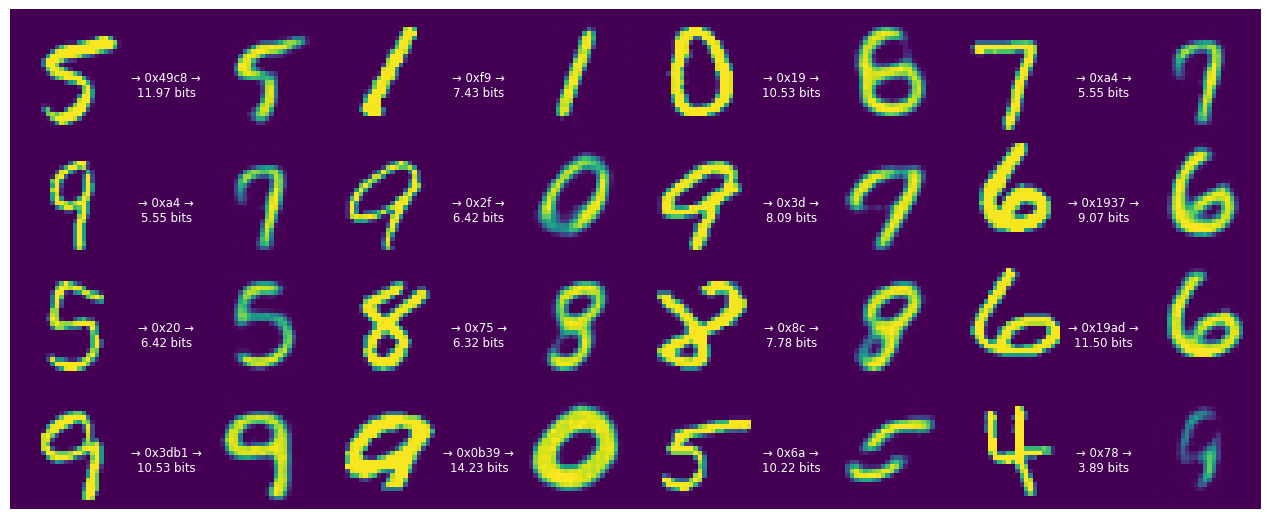

In [ ]:
train_and_visualize_model(lmbda=300)


The strings begin to get much shorter now, on the order of one byte per digit. However, this comes at a cost. More digits are becoming unrecognizable.

This demonstrates that this model is agnostic to human perceptions of error, it just measures the absolute deviation in terms of pixel values. To achieve a better perceived image quality, we would need to replace the pixel loss with a perceptual loss.

## Use the decoder as a generative model.

If we feed the decoder random bits, this will effectively sample from the distribution that the model learned to represent digits.

First, re-instantiate the compressor/decompressor without a sanity check that would detect if the input string isn't completely decoded.

In [ ]:
compressor, decompressor = make_mnist_codec(trainer, decode_sanity_check=False)


Now, feed long enough random strings into the decompressor so that it can decode/sample digits from them.

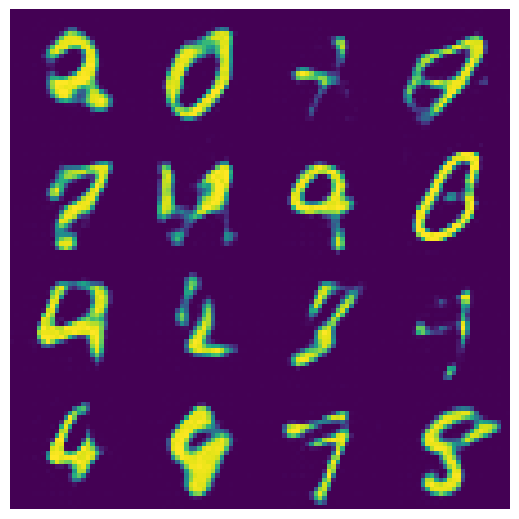

In [ ]:
import os

strings = tf.constant([os.urandom(8) for _ in range(16)])
samples = decompressor(strings)

fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(5, 5))
axes = axes.ravel()
for i in range(len(axes)):
  axes[i].imshow(tf.squeeze(samples[i]))
  axes[i].axis("off")
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
